# Общие сведения

## Description

Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS (осень 2023).

Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

На станице с данными  можно загрузить два файла - train.csv (содержит колонки признаков и целевую переменную) и test.csv (содержит только колонки признаков).

В качестве ответа необходимо загрузить предсказания вероятностей ухода клиентов для test.csv.

Пример файла с предскзааниями - submission.csv. Названия признаков и целевой пременной есть в baseline ноутбуке. (baseline - базовое решение, с которым обычно сравниают более продвинутые алгоритмы.)


<div style='border:solid green 3px; padding: 20px'>
    
**Необходимо спрогнозировать отток клиентов телеком компании**. Это задача классификации: нужно определить, уйдет ли клиент или нет. Целевой признак: Churn. Метрика: ROC-AUC.    

## Evaluation

В данном соревновании решения будут сравниваться по метрике ROC-AUC. Для получения полного балла за соревнование не достаточно получить высокое значение метрики, подробные критерии есть в baseline ноутбуке и на stepik.

## Citation

RunFMe. (2021). Предсказание оттока пользователей (весна 2021). Kaggle. https://kaggle.com/competitions/advanced-dls-spring-2021

# Загрузка данных. Первичный анализ

## Подключение необходимых библиотек для работы кода

In [1]:
# для анализа и работы с данных
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


# для графического отображения результатов
import seaborn as sns

# алгоритмы машинного обучения
import catboost as cb
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

# метрики для алгоритмов ML
from sklearn.metrics import roc_auc_score, roc_curve

# для игнорирования ошибок в проекте
import warnings
warnings.filterwarnings("ignore")

# настройка отображения чисел и таблиц
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.width', 500)

# общее формление для графиков
sns.set(style="white", palette="Paired")

# константы
RANDOM_STATE = 2023

# Первая часть. Исследование

## Загрузка данных

In [2]:
# загрузка датафрейма
data_origin = pd.read_csv('D:/__________________/train.csv')

In [3]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [4]:
data = data_origin

In [5]:
def prepare_data(df):
    df = df.replace(" ", np.nan)
    df['TotalSpent'] = pd.to_numeric(df['TotalSpent'])

    return df

data = prepare_data(data)

In [6]:
# функиия для вывода основных показателей трех датафреймов
def df_info(df):
    '''
    функция для вывода основных показателей датафреймов
    
    '''
    print("-"*100)
    print('Общая информамия о датафрейме:')
    print("-"*100)
    print(df.info())
    
    print("-"*100)
    print('Первые 5 строк таблицы')
    print("-"*100)
    display(df.head(5))
    
    print("-"*100)
    print('Количество пропусков')
    print("-"*100)
    print(df.isnull().sum().sort_values(ascending=False))
    
    print("-"*100)
    print('Статистические данные датафрейма')
    print("-"*100)
    display(np.round(df.describe(), 2).T)
    
    print("-"*100)
    print('Количество дубликатов:')
    print("-"*100)
    display(df.duplicated().sum())
    
    print("-"*100)
    print('Визуализация пропущенных данных по строкам датафрейма')
    print("-"*100)
    sns.heatmap(df.isna().transpose(), cbar_kws={'label': 'Пропуски в данных'})
    plt.show()

----------------------------------------------------------------------------------------------------
Общая информамия о датафрейме:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5273 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.5000,1026.3500,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.8500,1872.2000,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.9000,75.9000,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.3000,2570.0000,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.2500,6758.4500,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


----------------------------------------------------------------------------------------------------
Количество пропусков
----------------------------------------------------------------------------------------------------
TotalSpent                  9
ClientPeriod                0
HasOnlineBackup             0
PaymentMethod               0
IsBillingPaperless          0
HasContractPhone            0
HasMovieSubscription        0
HasOnlineTV                 0
HasTechSupportAccess        0
HasDeviceProtection         0
HasOnlineSecurityService    0
MonthlySpending             0
HasInternetService          0
HasMultiplePhoneNumbers     0
HasPhoneService             0
HasChild                    0
HasPartner                  0
IsSeniorCitizen             0
Sex                         0
Churn                       0
dtype: int64
----------------------------------------------------------------------------------------------------
Статистические данные датафрейма
------------------------------

,count,mean,std,min,25%,50%,75%,max
ClientPeriod,5282.0000,32.4000,24.5500,0.0000,9.0000,29.0000,55.0000,72.0000
MonthlySpending,5282.0000,64.9200,30.1800,18.2500,35.4600,70.4000,90.0500,118.7500
TotalSpent,5273.0000,2291.3900,2269.0100,18.8000,401.1000,1410.2500,3807.3500,8684.8000
IsSeniorCitizen,5282.0000,0.1600,0.3700,0.0000,0.0000,0.0000,0.0000,1.0000
Churn,5282.0000,0.2600,0.4400,0.0000,0.0000,0.0000,1.0000,1.0000


----------------------------------------------------------------------------------------------------
Количество дубликатов:
----------------------------------------------------------------------------------------------------


14

----------------------------------------------------------------------------------------------------
Визуализация пропущенных данных по строкам датафрейма
----------------------------------------------------------------------------------------------------


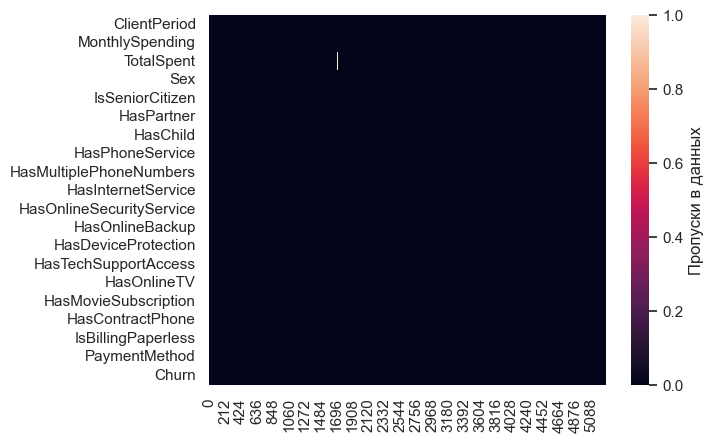

In [7]:
df_info(data)

In [8]:
data.isna().sum().sum()

9

In [9]:
data.isna().mean()

ClientPeriod               0.0000
MonthlySpending            0.0000
TotalSpent                 0.0017
Sex                        0.0000
IsSeniorCitizen            0.0000
HasPartner                 0.0000
HasChild                   0.0000
HasPhoneService            0.0000
HasMultiplePhoneNumbers    0.0000
HasInternetService         0.0000
HasOnlineSecurityService   0.0000
HasOnlineBackup            0.0000
HasDeviceProtection        0.0000
HasTechSupportAccess       0.0000
HasOnlineTV                0.0000
HasMovieSubscription       0.0000
HasContractPhone           0.0000
IsBillingPaperless         0.0000
PaymentMethod              0.0000
Churn                      0.0000
dtype: float64

In [10]:
data = data.dropna()

# Анализ данных (EDA)

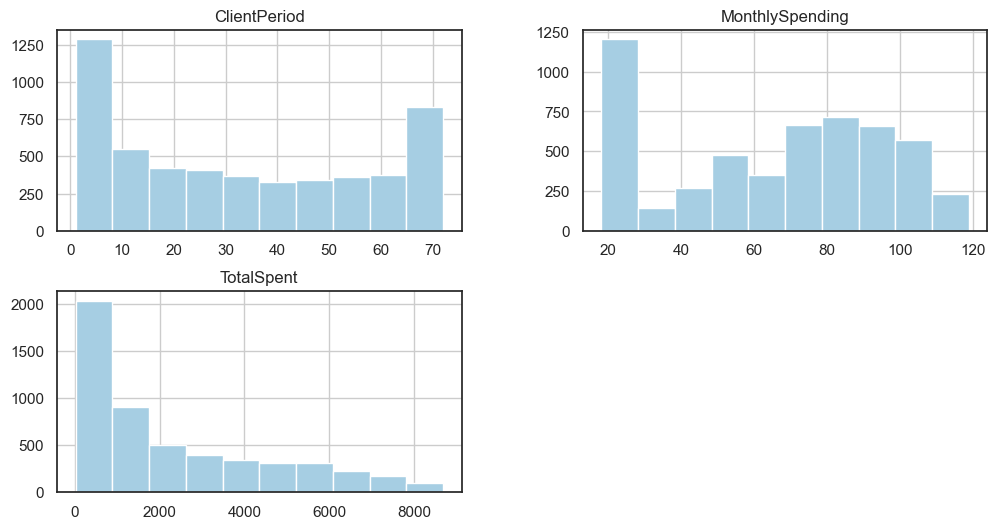

In [11]:
data.hist(column=num_cols, figsize=(12, 6))
plt.show()

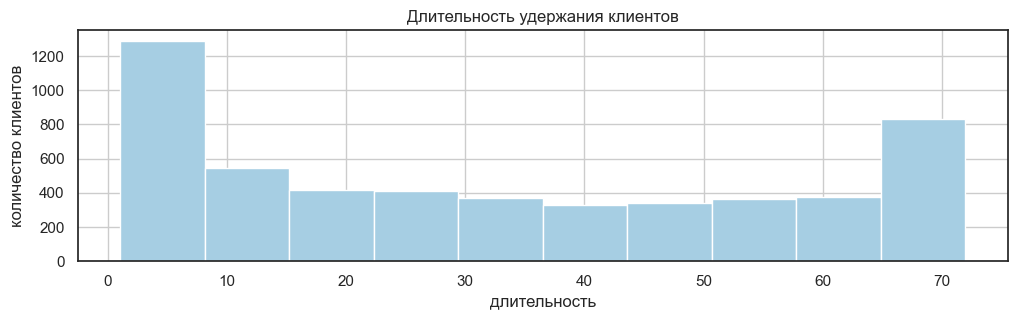

In [12]:
# график зависимости количества клиентов от их длительности их удержаниянны
plt.figure(figsize = (12, 3))
data['ClientPeriod'].hist()
plt.title('Длительность удержания клиентов')
plt.xlabel('длительность')
plt.ylabel('количество клиентов')
plt.show();

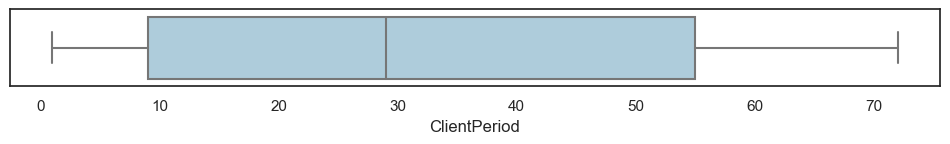

In [13]:
# диаграмма размаха
plt.figure(figsize=(12, 1))
sns.boxplot(x=data['ClientPeriod'])
plt.show()

In [14]:
data[num_cols].corr().style.background_gradient().set_precision(2)

,ClientPeriod,MonthlySpending,TotalSpent
ClientPeriod,1.00,0.25,0.83
MonthlySpending,0.25,1.00,0.65
TotalSpent,0.83,0.65,1.00


In [15]:
data[cat_cols[0]].value_counts().index

Index(['Male', 'Female'], dtype='object')

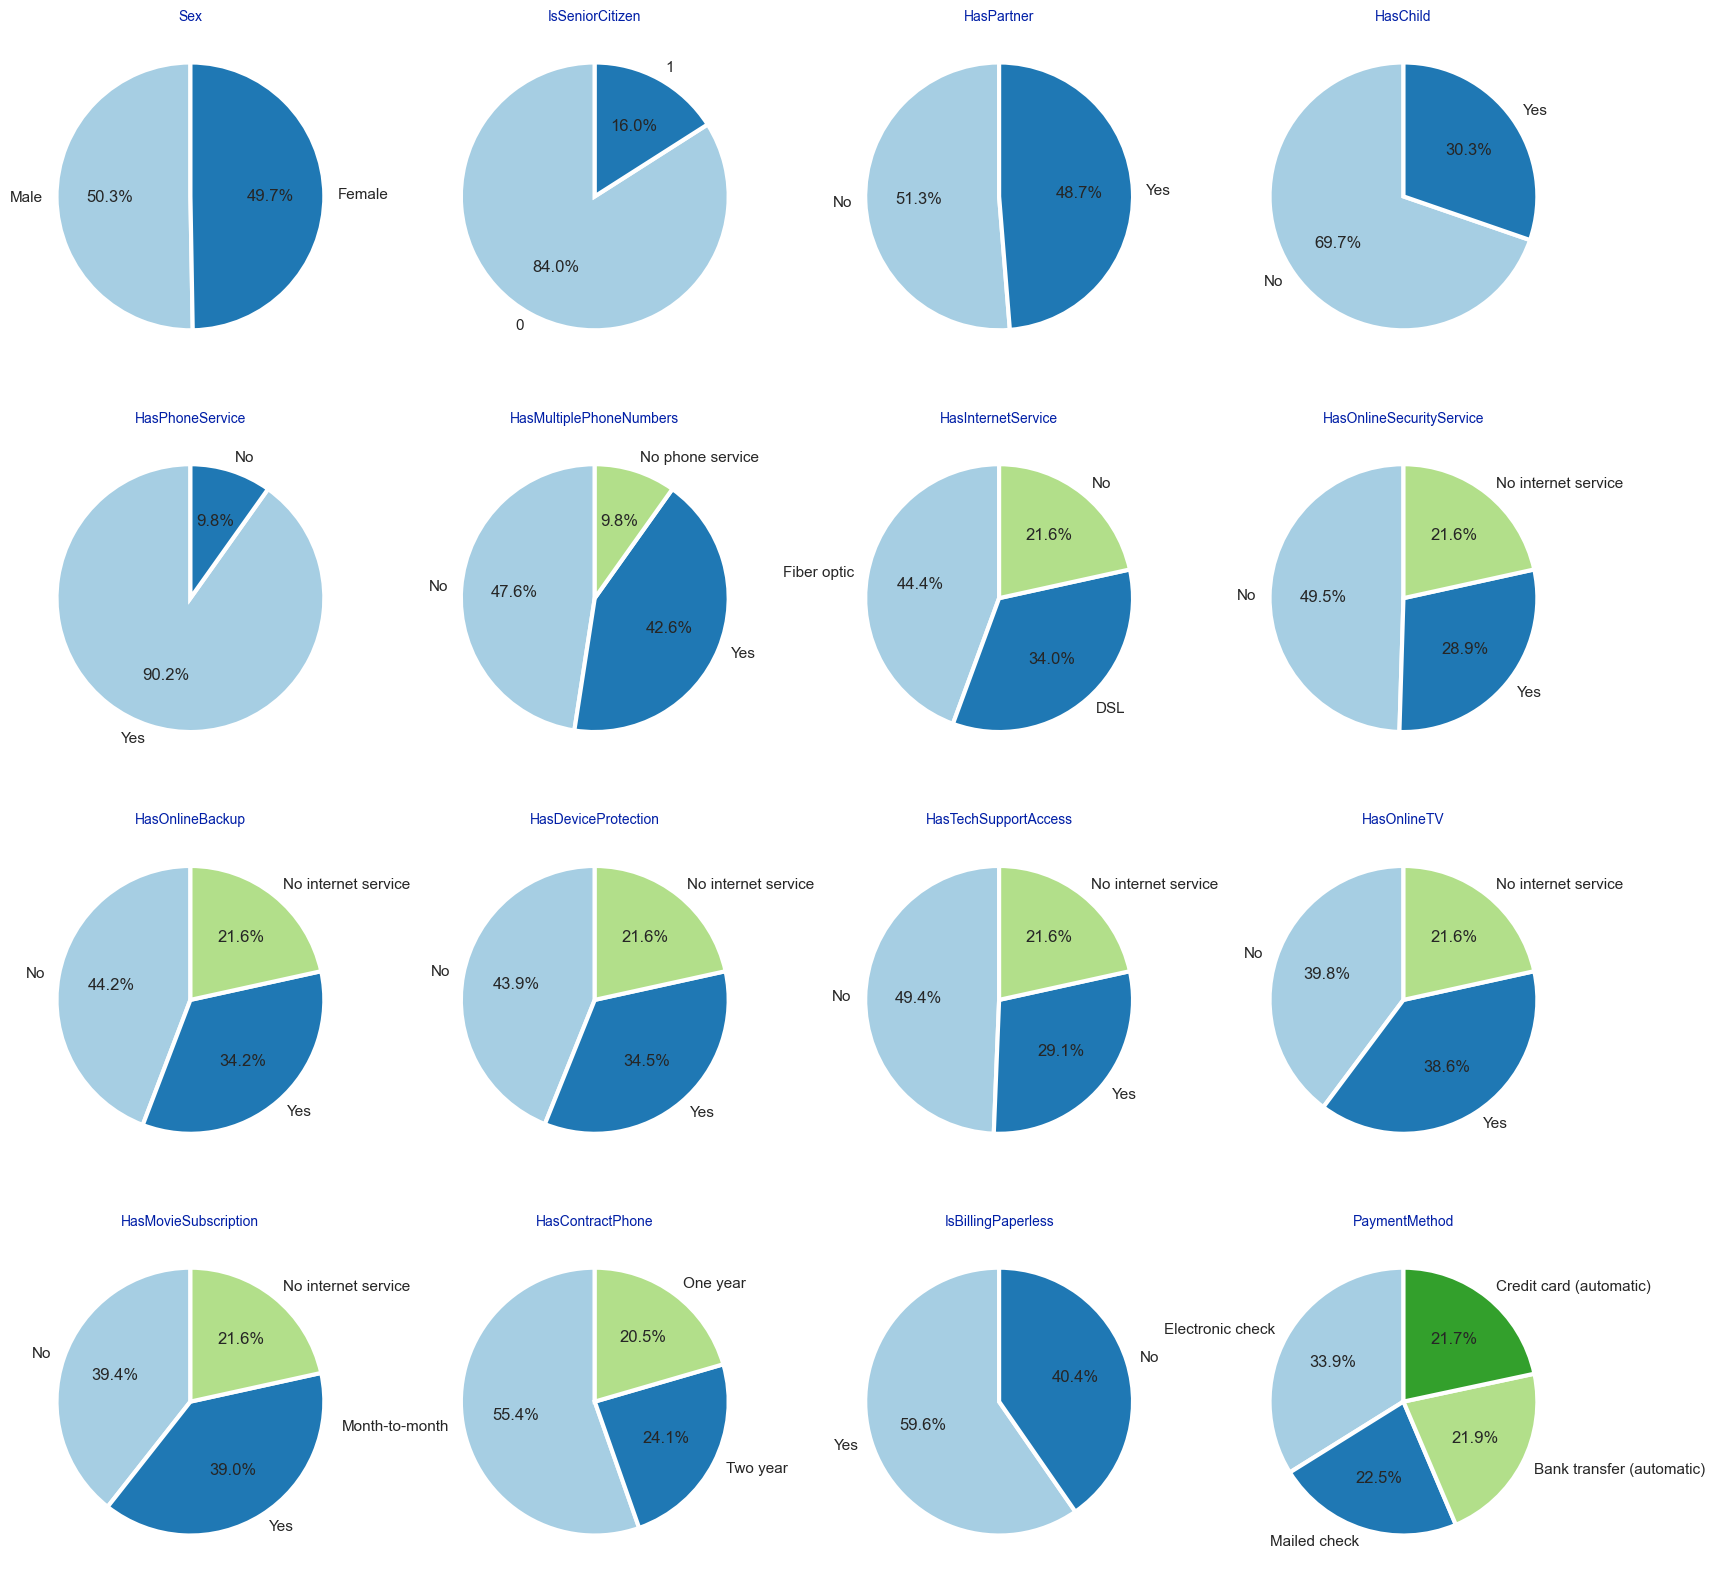

In [16]:
fg, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for i, cat in enumerate(cat_cols):
    axs[i//4,i%4].pie(data[cat].value_counts(),
                      autopct='%1.1f%%',
                      labels=data[cat].value_counts().index,
                      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                      startangle=90)

    axs[i//4,i%4].set_title(cat, fontsize=10, color='#001ea6')

In [17]:
 # обновим data_origin
data_origin = data

# Обучение моделей ML

## Применение линейных моделей

In [18]:
def label_onehot_encoding(df):
    df = df.apply(LabelEncoder().fit_transform)
    df = pd.get_dummies(df, columns=cat_cols)

    return df

In [19]:
data = label_onehot_encoding(data)

In [20]:
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=RANDOM_STATE)
)

grd_search = GridSearchCV(clf,
                          param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001] },
                          scoring='roc_auc')

In [21]:
X, y = data.drop(columns=target_col), data[target_col]

In [22]:
grd_search.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=2023))]),
             param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01,
                                                   0.001]},
             scoring='roc_auc')

In [23]:
grd_search.best_score_

0.8460370635675348

In [24]:
grd_search.best_params_

{'logisticregression__C': 0.1}

In [25]:
def show_plot(model, X_train, y_train):
    y_train_pred = model.predict_proba(X_train)[:,1]

    train_auc = roc_auc_score(y_train, y_train_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(*roc_curve(y_train, y_train_pred)[:2], label='train AUC={:.4f}'.format(train_auc))

    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

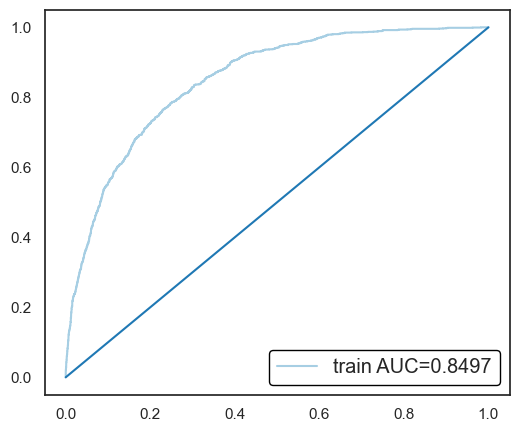

In [26]:
show_plot(grd_search, data.drop(columns=target_col), data[target_col])

## Градиентный бустинг

In [27]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data_origin.drop(columns=target_col),
    data_origin[target_col],
    train_size=0.8
)

In [28]:
boosted_catty = cb.CatBoostClassifier(cat_features=cat_cols, verbose=False, random_state=RANDOM_STATE)

boosted_catty.fit(X_train, y_train)

In [29]:
def show_roc_curve_of_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(*roc_curve(y_train, y_train_pred)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_test, y_test_pred)[:2], label='test AUC={:.4f}'.format(test_auc))

    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

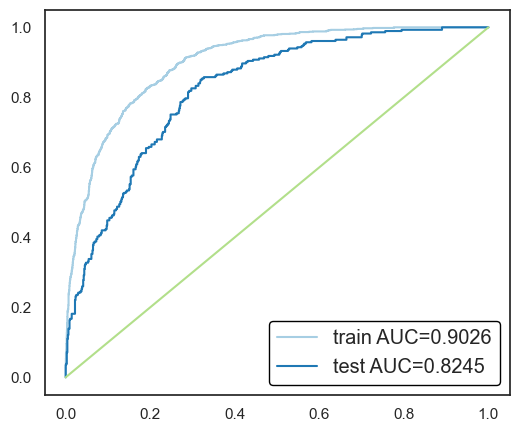

In [30]:
show_roc_curve_of_model(boosted_catty, X_train, X_test, y_train, y_test)

## Grid shearch num 1

In [31]:
params = {
    'n_estimators': [10, 50],
    'max_depth': [3, 4],
    'subsample': [0.3, 0.6],
    'l2_leaf_reg': [0.1, 1],
    'random_strength': np.linspace(1, 12, 2),
    'eta': np.linspace(0.1, 0.7, 3),
    'min_data_in_leaf': [5]
}

In [32]:
# Grid Search
grid_boosted_catty = cb.CatBoostClassifier(cat_features=cat_cols,
                                          eval_metric='AUC:hints=skip_train~false',
                                          logging_level='Silent')

grid_boosted_catty.grid_search(params,
                        X_train, y_train,
                        plot=True,
                        refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8369435	best: 0.8369435 (0)	total: 248ms	remaining: 23.6s
1:	loss: 0.8554570	best: 0.8554570 (1)	total: 418ms	remaining: 19.7s
2:	loss: 0.8513461	best: 0.8554570 (1)	total: 574ms	remaining: 17.8s
3:	loss: 0.8462900	best: 0.8554570 (1)	total: 811ms	remaining: 18.7s
4:	loss: 0.8584833	best: 0.8584833 (4)	total: 1.04s	remaining: 18.9s
5:	loss: 0.8536104	best: 0.8584833 (4)	total: 1.27s	remaining: 19s
6:	loss: 0.8603665	best: 0.8603665 (6)	total: 2.44s	remaining: 31s
7:	loss: 0.8575454	best: 0.8603665 (6)	total: 3.6s	remaining: 39.6s
8:	loss: 0.8513718	best: 0.8603665 (6)	total: 4.72s	remaining: 45.6s
9:	loss: 0.8622827	best: 0.8622827 (9)	total: 5.61s	remaining: 48.3s
10:	loss: 0.8601320	best: 0.8622827 (9)	total: 6.47s	remaining: 50s
11:	loss: 0.8544750	best: 0.8622827 (9)	total: 7.39s	remaining: 51.7s
12:	loss: 0.8462057	best: 0.8622827 (9)	total: 7.5s	remaining: 47.9s
13:	loss: 0.8405011	best: 0.8622827 (9)	total: 7.64s	remaining: 44.8s
14:	loss: 0.8464622	best: 0.8622827 (9

{'params': {'min_data_in_leaf': 5,
  'depth': 3,
  'iterations': 50,
  'subsample': 0.6,
  'random_strength': 1.0,
  'learning_rate': 0.4,
  'l2_leaf_reg': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
   

`` {'params': {'min_data_in_leaf': 5,
  'depth': 3,
  'l2_leaf_reg': 1,
  'iterations': 50,
  'subsample': 0.6,
  'random_strength': 1.0,
  'learning_rate': 0.4},``

In [33]:
best_params =  {'min_data_in_leaf': 5,
  'depth': 3,
  'l2_leaf_reg': 1,
  'iterations': 50,
  'subsample': 0.6,
  'random_strength': 1.0,
  'learning_rate': 0.4}

In [34]:
grid_boosted_catty = cb.CatBoostClassifier(**best_params,
                                                 silent=True,
                                                 cat_features=cat_cols,
                                                 eval_metric='AUC:hints=skip_train~false')

grid_boosted_catty.fit(X_train, y_train)

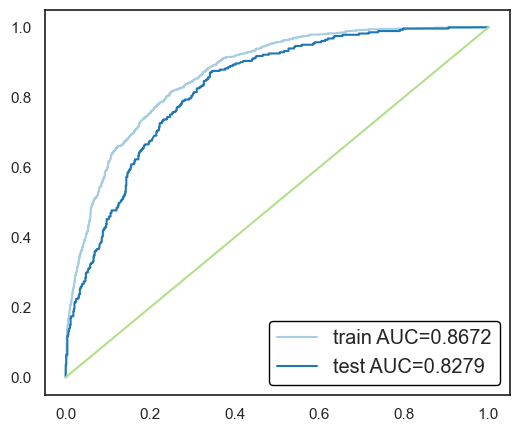

In [35]:
show_roc_curve_of_model(grid_boosted_catty, X_train, X_test, y_train, y_test)

## Grid search num 2

In [36]:
model = cb.CatBoostClassifier(loss_function='Logloss', cat_features=cat_cols, random_state=RANDOM_STATE)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [1, 3, 5]}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6767771	test: 0.6769696	best: 0.6769696 (0)	total: 19.3ms	remaining: 19.3s
1:	learn: 0.6596631	test: 0.6594417	best: 0.6594417 (1)	total: 35.7ms	remaining: 17.8s
2:	learn: 0.6437399	test: 0.6433828	best: 0.6433828 (2)	total: 54.9ms	remaining: 18.2s
3:	learn: 0.6286107	test: 0.6279007	best: 0.6279007 (3)	total: 92.8ms	remaining: 23.1s
4:	learn: 0.6159708	test: 0.6148566	best: 0.6148566 (4)	total: 112ms	remaining: 22.4s
5:	learn: 0.6027966	test: 0.6013246	best: 0.6013246 (5)	total: 133ms	remaining: 22.1s
6:	learn: 0.5912842	test: 0.5894586	best: 0.5894586 (6)	total: 174ms	remaining: 24.7s
7:	learn: 0.5809465	test: 0.5784944	best: 0.5784944 (7)	total: 194ms	remaining: 24s
8:	learn: 0.5709189	test: 0.5678602	best: 0.5678602 (8)	total: 213ms	remaining: 23.4s
9:	learn: 0.5616463	test: 0.5584354	best: 0.5584354 (9)	total: 246ms	remaining: 24.4s
10:	learn: 0.5533443	test: 0.5496701	best: 0.5496701 (10)	total: 280ms	remaining: 25.2s
11:	learn: 0.5452513	test: 0.5413429	best: 0.54134

97:	learn: 0.4083050	test: 0.4024368	best: 0.4024368 (97)	total: 2.43s	remaining: 22.3s
98:	learn: 0.4081147	test: 0.4023810	best: 0.4023810 (98)	total: 2.44s	remaining: 22.3s
99:	learn: 0.4079293	test: 0.4022423	best: 0.4022423 (99)	total: 2.47s	remaining: 22.2s
100:	learn: 0.4078165	test: 0.4021604	best: 0.4021604 (100)	total: 2.5s	remaining: 22.3s
101:	learn: 0.4077325	test: 0.4021280	best: 0.4021280 (101)	total: 2.52s	remaining: 22.2s
102:	learn: 0.4075868	test: 0.4020250	best: 0.4020250 (102)	total: 2.54s	remaining: 22.1s
103:	learn: 0.4071697	test: 0.4019728	best: 0.4019728 (103)	total: 2.56s	remaining: 22s
104:	learn: 0.4069076	test: 0.4017173	best: 0.4017173 (104)	total: 2.58s	remaining: 22s
105:	learn: 0.4067660	test: 0.4016732	best: 0.4016732 (105)	total: 2.61s	remaining: 22s
106:	learn: 0.4063123	test: 0.4013407	best: 0.4013407 (106)	total: 2.66s	remaining: 22.2s
107:	learn: 0.4060207	test: 0.4013550	best: 0.4013407 (106)	total: 2.69s	remaining: 22.2s
108:	learn: 0.4056114	t

191:	learn: 0.3937334	test: 0.3941705	best: 0.3941705 (191)	total: 4.63s	remaining: 19.5s
192:	learn: 0.3937330	test: 0.3941716	best: 0.3941705 (191)	total: 4.64s	remaining: 19.4s
193:	learn: 0.3935425	test: 0.3941614	best: 0.3941614 (193)	total: 4.66s	remaining: 19.4s
194:	learn: 0.3934155	test: 0.3941478	best: 0.3941478 (194)	total: 4.68s	remaining: 19.3s
195:	learn: 0.3932494	test: 0.3940127	best: 0.3940127 (195)	total: 4.7s	remaining: 19.3s
196:	learn: 0.3931899	test: 0.3939967	best: 0.3939967 (196)	total: 4.72s	remaining: 19.2s
197:	learn: 0.3931548	test: 0.3939949	best: 0.3939949 (197)	total: 4.74s	remaining: 19.2s
198:	learn: 0.3930885	test: 0.3940045	best: 0.3939949 (197)	total: 4.78s	remaining: 19.2s
199:	learn: 0.3930449	test: 0.3939838	best: 0.3939838 (199)	total: 4.8s	remaining: 19.2s
200:	learn: 0.3928666	test: 0.3938444	best: 0.3938444 (200)	total: 4.82s	remaining: 19.2s
201:	learn: 0.3928365	test: 0.3938164	best: 0.3938164 (201)	total: 4.83s	remaining: 19.1s
202:	learn: 

288:	learn: 0.3833411	test: 0.3924860	best: 0.3923699 (275)	total: 7.03s	remaining: 17.3s
289:	learn: 0.3831548	test: 0.3923192	best: 0.3923192 (289)	total: 7.05s	remaining: 17.3s
290:	learn: 0.3830531	test: 0.3923102	best: 0.3923102 (290)	total: 7.07s	remaining: 17.2s
291:	learn: 0.3829633	test: 0.3922998	best: 0.3922998 (291)	total: 7.11s	remaining: 17.2s
292:	learn: 0.3829064	test: 0.3922750	best: 0.3922750 (292)	total: 7.13s	remaining: 17.2s
293:	learn: 0.3828578	test: 0.3922775	best: 0.3922750 (292)	total: 7.15s	remaining: 17.2s
294:	learn: 0.3828108	test: 0.3922767	best: 0.3922750 (292)	total: 7.19s	remaining: 17.2s
295:	learn: 0.3827629	test: 0.3922835	best: 0.3922750 (292)	total: 7.21s	remaining: 17.1s
296:	learn: 0.3827375	test: 0.3922793	best: 0.3922750 (292)	total: 7.23s	remaining: 17.1s
297:	learn: 0.3825585	test: 0.3922580	best: 0.3922580 (297)	total: 7.26s	remaining: 17.1s
298:	learn: 0.3825168	test: 0.3922526	best: 0.3922526 (298)	total: 7.28s	remaining: 17.1s
299:	learn

389:	learn: 0.3720059	test: 0.3926264	best: 0.3919155 (320)	total: 9.44s	remaining: 14.8s
390:	learn: 0.3719382	test: 0.3926761	best: 0.3919155 (320)	total: 9.47s	remaining: 14.8s
391:	learn: 0.3718451	test: 0.3925863	best: 0.3919155 (320)	total: 9.49s	remaining: 14.7s
392:	learn: 0.3717913	test: 0.3925780	best: 0.3919155 (320)	total: 9.52s	remaining: 14.7s
393:	learn: 0.3717300	test: 0.3925745	best: 0.3919155 (320)	total: 9.54s	remaining: 14.7s
394:	learn: 0.3716498	test: 0.3925595	best: 0.3919155 (320)	total: 9.56s	remaining: 14.6s
395:	learn: 0.3715697	test: 0.3926059	best: 0.3919155 (320)	total: 9.58s	remaining: 14.6s
396:	learn: 0.3715108	test: 0.3925673	best: 0.3919155 (320)	total: 9.6s	remaining: 14.6s
397:	learn: 0.3714806	test: 0.3925424	best: 0.3919155 (320)	total: 9.62s	remaining: 14.6s
398:	learn: 0.3713580	test: 0.3924610	best: 0.3919155 (320)	total: 9.64s	remaining: 14.5s
399:	learn: 0.3712794	test: 0.3924815	best: 0.3919155 (320)	total: 9.67s	remaining: 14.5s
400:	learn:

482:	learn: 0.3634639	test: 0.3923932	best: 0.3919155 (320)	total: 11.7s	remaining: 12.5s
483:	learn: 0.3634013	test: 0.3923483	best: 0.3919155 (320)	total: 11.7s	remaining: 12.5s
484:	learn: 0.3633641	test: 0.3923658	best: 0.3919155 (320)	total: 11.7s	remaining: 12.5s
485:	learn: 0.3633362	test: 0.3923672	best: 0.3919155 (320)	total: 11.8s	remaining: 12.4s
486:	learn: 0.3632827	test: 0.3923509	best: 0.3919155 (320)	total: 11.8s	remaining: 12.4s
487:	learn: 0.3630821	test: 0.3922814	best: 0.3919155 (320)	total: 11.8s	remaining: 12.4s
488:	learn: 0.3629319	test: 0.3922554	best: 0.3919155 (320)	total: 11.8s	remaining: 12.4s
489:	learn: 0.3628963	test: 0.3922649	best: 0.3919155 (320)	total: 11.8s	remaining: 12.3s
490:	learn: 0.3626964	test: 0.3923349	best: 0.3919155 (320)	total: 11.9s	remaining: 12.3s
491:	learn: 0.3626659	test: 0.3923333	best: 0.3919155 (320)	total: 11.9s	remaining: 12.3s
492:	learn: 0.3626152	test: 0.3923707	best: 0.3919155 (320)	total: 11.9s	remaining: 12.3s
493:	learn

581:	learn: 0.3546354	test: 0.3933209	best: 0.3919155 (320)	total: 14.1s	remaining: 10.1s
582:	learn: 0.3545501	test: 0.3933274	best: 0.3919155 (320)	total: 14.1s	remaining: 10.1s
583:	learn: 0.3544762	test: 0.3932861	best: 0.3919155 (320)	total: 14.1s	remaining: 10.1s
584:	learn: 0.3544205	test: 0.3932865	best: 0.3919155 (320)	total: 14.1s	remaining: 10s
585:	learn: 0.3542792	test: 0.3931850	best: 0.3919155 (320)	total: 14.2s	remaining: 10s
586:	learn: 0.3542469	test: 0.3931922	best: 0.3919155 (320)	total: 14.2s	remaining: 9.99s
587:	learn: 0.3541853	test: 0.3932559	best: 0.3919155 (320)	total: 14.2s	remaining: 9.96s
588:	learn: 0.3540928	test: 0.3933459	best: 0.3919155 (320)	total: 14.2s	remaining: 9.94s
589:	learn: 0.3540743	test: 0.3933405	best: 0.3919155 (320)	total: 14.3s	remaining: 9.91s
590:	learn: 0.3539760	test: 0.3933623	best: 0.3919155 (320)	total: 14.3s	remaining: 9.88s
591:	learn: 0.3539152	test: 0.3933304	best: 0.3919155 (320)	total: 14.3s	remaining: 9.86s
592:	learn: 0.

680:	learn: 0.3465391	test: 0.3939422	best: 0.3919155 (320)	total: 16.3s	remaining: 7.64s
681:	learn: 0.3464634	test: 0.3940117	best: 0.3919155 (320)	total: 16.3s	remaining: 7.62s
682:	learn: 0.3462940	test: 0.3938909	best: 0.3919155 (320)	total: 16.4s	remaining: 7.61s
683:	learn: 0.3462694	test: 0.3938981	best: 0.3919155 (320)	total: 16.4s	remaining: 7.58s
684:	learn: 0.3461929	test: 0.3939247	best: 0.3919155 (320)	total: 16.4s	remaining: 7.56s
685:	learn: 0.3460674	test: 0.3938550	best: 0.3919155 (320)	total: 16.5s	remaining: 7.54s
686:	learn: 0.3460361	test: 0.3938520	best: 0.3919155 (320)	total: 16.5s	remaining: 7.51s
687:	learn: 0.3459849	test: 0.3938928	best: 0.3919155 (320)	total: 16.5s	remaining: 7.49s
688:	learn: 0.3458945	test: 0.3940014	best: 0.3919155 (320)	total: 16.5s	remaining: 7.46s
689:	learn: 0.3458222	test: 0.3939806	best: 0.3919155 (320)	total: 16.6s	remaining: 7.44s
690:	learn: 0.3456843	test: 0.3939488	best: 0.3919155 (320)	total: 16.6s	remaining: 7.42s
691:	learn

773:	learn: 0.3394812	test: 0.3950844	best: 0.3919155 (320)	total: 18.5s	remaining: 5.4s
774:	learn: 0.3393584	test: 0.3951536	best: 0.3919155 (320)	total: 18.6s	remaining: 5.39s
775:	learn: 0.3391540	test: 0.3951261	best: 0.3919155 (320)	total: 18.6s	remaining: 5.37s
776:	learn: 0.3391467	test: 0.3951448	best: 0.3919155 (320)	total: 18.6s	remaining: 5.34s
777:	learn: 0.3389747	test: 0.3950845	best: 0.3919155 (320)	total: 18.6s	remaining: 5.32s
778:	learn: 0.3388501	test: 0.3950230	best: 0.3919155 (320)	total: 18.7s	remaining: 5.29s
779:	learn: 0.3387167	test: 0.3949676	best: 0.3919155 (320)	total: 18.7s	remaining: 5.27s
780:	learn: 0.3386069	test: 0.3948369	best: 0.3919155 (320)	total: 18.7s	remaining: 5.25s
781:	learn: 0.3385303	test: 0.3947979	best: 0.3919155 (320)	total: 18.7s	remaining: 5.22s
782:	learn: 0.3384677	test: 0.3948080	best: 0.3919155 (320)	total: 18.8s	remaining: 5.2s
783:	learn: 0.3383727	test: 0.3948064	best: 0.3919155 (320)	total: 18.8s	remaining: 5.18s
784:	learn: 

868:	learn: 0.3319541	test: 0.3962176	best: 0.3919155 (320)	total: 20.9s	remaining: 3.15s
869:	learn: 0.3319176	test: 0.3962097	best: 0.3919155 (320)	total: 20.9s	remaining: 3.13s
870:	learn: 0.3317513	test: 0.3961797	best: 0.3919155 (320)	total: 21s	remaining: 3.1s
871:	learn: 0.3317056	test: 0.3961527	best: 0.3919155 (320)	total: 21s	remaining: 3.08s
872:	learn: 0.3316375	test: 0.3961285	best: 0.3919155 (320)	total: 21s	remaining: 3.06s
873:	learn: 0.3315809	test: 0.3961722	best: 0.3919155 (320)	total: 21s	remaining: 3.03s
874:	learn: 0.3315209	test: 0.3961513	best: 0.3919155 (320)	total: 21s	remaining: 3.01s
875:	learn: 0.3314367	test: 0.3961658	best: 0.3919155 (320)	total: 21.1s	remaining: 2.98s
876:	learn: 0.3313938	test: 0.3961538	best: 0.3919155 (320)	total: 21.1s	remaining: 2.96s
877:	learn: 0.3313165	test: 0.3963803	best: 0.3919155 (320)	total: 21.1s	remaining: 2.93s
878:	learn: 0.3312812	test: 0.3964005	best: 0.3919155 (320)	total: 21.1s	remaining: 2.91s
879:	learn: 0.3312420

966:	learn: 0.3253739	test: 0.3971505	best: 0.3919155 (320)	total: 23.3s	remaining: 796ms
967:	learn: 0.3253137	test: 0.3971497	best: 0.3919155 (320)	total: 23.4s	remaining: 772ms
968:	learn: 0.3252558	test: 0.3971484	best: 0.3919155 (320)	total: 23.4s	remaining: 748ms
969:	learn: 0.3251873	test: 0.3971691	best: 0.3919155 (320)	total: 23.4s	remaining: 724ms
970:	learn: 0.3251602	test: 0.3971781	best: 0.3919155 (320)	total: 23.4s	remaining: 700ms
971:	learn: 0.3251024	test: 0.3972175	best: 0.3919155 (320)	total: 23.5s	remaining: 676ms
972:	learn: 0.3249897	test: 0.3972896	best: 0.3919155 (320)	total: 23.5s	remaining: 651ms
973:	learn: 0.3248441	test: 0.3974103	best: 0.3919155 (320)	total: 23.5s	remaining: 627ms
974:	learn: 0.3248074	test: 0.3973725	best: 0.3919155 (320)	total: 23.5s	remaining: 603ms
975:	learn: 0.3247680	test: 0.3974128	best: 0.3919155 (320)	total: 23.5s	remaining: 579ms
976:	learn: 0.3246799	test: 0.3974495	best: 0.3919155 (320)	total: 23.6s	remaining: 555ms
977:	learn

58:	learn: 0.3921320	test: 0.3931886	best: 0.3931886 (58)	total: 1.41s	remaining: 22.4s
59:	learn: 0.3919780	test: 0.3932169	best: 0.3931886 (58)	total: 1.43s	remaining: 22.4s
60:	learn: 0.3916014	test: 0.3931238	best: 0.3931238 (60)	total: 1.46s	remaining: 22.5s
61:	learn: 0.3909759	test: 0.3934174	best: 0.3931238 (60)	total: 1.48s	remaining: 22.4s
62:	learn: 0.3908588	test: 0.3934988	best: 0.3931238 (60)	total: 1.5s	remaining: 22.3s
63:	learn: 0.3905542	test: 0.3934701	best: 0.3931238 (60)	total: 1.52s	remaining: 22.2s
64:	learn: 0.3902153	test: 0.3934466	best: 0.3931238 (60)	total: 1.55s	remaining: 22.3s
65:	learn: 0.3897034	test: 0.3932464	best: 0.3931238 (60)	total: 1.57s	remaining: 22.3s
66:	learn: 0.3891981	test: 0.3933399	best: 0.3931238 (60)	total: 1.6s	remaining: 22.3s
67:	learn: 0.3888420	test: 0.3933574	best: 0.3931238 (60)	total: 1.62s	remaining: 22.1s
68:	learn: 0.3884665	test: 0.3931253	best: 0.3931238 (60)	total: 1.65s	remaining: 22.2s
69:	learn: 0.3882437	test: 0.39283

151:	learn: 0.3622258	test: 0.3924671	best: 0.3909670 (104)	total: 3.54s	remaining: 19.8s
152:	learn: 0.3617964	test: 0.3927255	best: 0.3909670 (104)	total: 3.58s	remaining: 19.8s
153:	learn: 0.3616682	test: 0.3927426	best: 0.3909670 (104)	total: 3.6s	remaining: 19.8s
154:	learn: 0.3615778	test: 0.3927824	best: 0.3909670 (104)	total: 3.67s	remaining: 20s
155:	learn: 0.3612201	test: 0.3927399	best: 0.3909670 (104)	total: 3.69s	remaining: 20s
156:	learn: 0.3611300	test: 0.3927578	best: 0.3909670 (104)	total: 3.71s	remaining: 19.9s
157:	learn: 0.3610267	test: 0.3927621	best: 0.3909670 (104)	total: 3.73s	remaining: 19.9s
158:	learn: 0.3606946	test: 0.3927570	best: 0.3909670 (104)	total: 3.75s	remaining: 19.8s
159:	learn: 0.3603615	test: 0.3927723	best: 0.3909670 (104)	total: 3.78s	remaining: 19.9s
160:	learn: 0.3600118	test: 0.3925771	best: 0.3909670 (104)	total: 3.81s	remaining: 19.9s
161:	learn: 0.3599484	test: 0.3925751	best: 0.3909670 (104)	total: 3.84s	remaining: 19.9s
162:	learn: 0.3

245:	learn: 0.3370385	test: 0.3952397	best: 0.3909670 (104)	total: 5.78s	remaining: 17.7s
246:	learn: 0.3369080	test: 0.3952552	best: 0.3909670 (104)	total: 5.81s	remaining: 17.7s
247:	learn: 0.3364720	test: 0.3953326	best: 0.3909670 (104)	total: 5.83s	remaining: 17.7s
248:	learn: 0.3362900	test: 0.3954021	best: 0.3909670 (104)	total: 5.85s	remaining: 17.6s
249:	learn: 0.3360100	test: 0.3953087	best: 0.3909670 (104)	total: 5.9s	remaining: 17.7s
250:	learn: 0.3358369	test: 0.3954765	best: 0.3909670 (104)	total: 5.92s	remaining: 17.7s
251:	learn: 0.3357047	test: 0.3956334	best: 0.3909670 (104)	total: 5.94s	remaining: 17.6s
252:	learn: 0.3353930	test: 0.3956288	best: 0.3909670 (104)	total: 5.96s	remaining: 17.6s
253:	learn: 0.3352861	test: 0.3956441	best: 0.3909670 (104)	total: 5.98s	remaining: 17.6s
254:	learn: 0.3351923	test: 0.3955191	best: 0.3909670 (104)	total: 6.01s	remaining: 17.6s
255:	learn: 0.3350332	test: 0.3952983	best: 0.3909670 (104)	total: 6.05s	remaining: 17.6s
256:	learn:

345:	learn: 0.3149005	test: 0.3986253	best: 0.3909670 (104)	total: 8.23s	remaining: 15.6s
346:	learn: 0.3147706	test: 0.3984296	best: 0.3909670 (104)	total: 8.25s	remaining: 15.5s
347:	learn: 0.3145184	test: 0.3985195	best: 0.3909670 (104)	total: 8.27s	remaining: 15.5s
348:	learn: 0.3142088	test: 0.3984479	best: 0.3909670 (104)	total: 8.29s	remaining: 15.5s
349:	learn: 0.3139076	test: 0.3993913	best: 0.3909670 (104)	total: 8.31s	remaining: 15.4s
350:	learn: 0.3138329	test: 0.3993961	best: 0.3909670 (104)	total: 8.33s	remaining: 15.4s
351:	learn: 0.3137045	test: 0.3993502	best: 0.3909670 (104)	total: 8.36s	remaining: 15.4s
352:	learn: 0.3136171	test: 0.3993452	best: 0.3909670 (104)	total: 8.39s	remaining: 15.4s
353:	learn: 0.3134362	test: 0.3994336	best: 0.3909670 (104)	total: 8.41s	remaining: 15.3s
354:	learn: 0.3130198	test: 0.3993748	best: 0.3909670 (104)	total: 8.44s	remaining: 15.3s
355:	learn: 0.3126007	test: 0.3993527	best: 0.3909670 (104)	total: 8.47s	remaining: 15.3s
356:	learn

438:	learn: 0.2987250	test: 0.4054126	best: 0.3909670 (104)	total: 10.4s	remaining: 13.3s
439:	learn: 0.2986540	test: 0.4052644	best: 0.3909670 (104)	total: 10.4s	remaining: 13.2s
440:	learn: 0.2985093	test: 0.4061279	best: 0.3909670 (104)	total: 10.4s	remaining: 13.2s
441:	learn: 0.2983486	test: 0.4063303	best: 0.3909670 (104)	total: 10.5s	remaining: 13.2s
442:	learn: 0.2981822	test: 0.4063319	best: 0.3909670 (104)	total: 10.5s	remaining: 13.2s
443:	learn: 0.2981212	test: 0.4063716	best: 0.3909670 (104)	total: 10.5s	remaining: 13.2s
444:	learn: 0.2980808	test: 0.4063786	best: 0.3909670 (104)	total: 10.5s	remaining: 13.1s
445:	learn: 0.2979181	test: 0.4062182	best: 0.3909670 (104)	total: 10.5s	remaining: 13.1s
446:	learn: 0.2976847	test: 0.4067079	best: 0.3909670 (104)	total: 10.6s	remaining: 13.1s
447:	learn: 0.2972949	test: 0.4068418	best: 0.3909670 (104)	total: 10.6s	remaining: 13.1s
448:	learn: 0.2969399	test: 0.4069118	best: 0.3909670 (104)	total: 10.6s	remaining: 13.1s
449:	learn

536:	learn: 0.2823262	test: 0.4085767	best: 0.3909670 (104)	total: 12.8s	remaining: 11s
537:	learn: 0.2822216	test: 0.4085628	best: 0.3909670 (104)	total: 12.8s	remaining: 11s
538:	learn: 0.2818800	test: 0.4087496	best: 0.3909670 (104)	total: 12.8s	remaining: 10.9s
539:	learn: 0.2816619	test: 0.4089030	best: 0.3909670 (104)	total: 12.8s	remaining: 10.9s
540:	learn: 0.2815572	test: 0.4087937	best: 0.3909670 (104)	total: 12.9s	remaining: 10.9s
541:	learn: 0.2815148	test: 0.4087237	best: 0.3909670 (104)	total: 12.9s	remaining: 10.9s
542:	learn: 0.2813581	test: 0.4086887	best: 0.3909670 (104)	total: 12.9s	remaining: 10.9s
543:	learn: 0.2811761	test: 0.4088984	best: 0.3909670 (104)	total: 12.9s	remaining: 10.9s
544:	learn: 0.2810931	test: 0.4088812	best: 0.3909670 (104)	total: 13s	remaining: 10.8s
545:	learn: 0.2810615	test: 0.4089225	best: 0.3909670 (104)	total: 13s	remaining: 10.8s
546:	learn: 0.2810089	test: 0.4087915	best: 0.3909670 (104)	total: 13s	remaining: 10.8s
547:	learn: 0.280993

637:	learn: 0.2669541	test: 0.4118070	best: 0.3909670 (104)	total: 15.3s	remaining: 8.65s
638:	learn: 0.2667859	test: 0.4118378	best: 0.3909670 (104)	total: 15.3s	remaining: 8.64s
639:	learn: 0.2665973	test: 0.4118736	best: 0.3909670 (104)	total: 15.3s	remaining: 8.61s
640:	learn: 0.2665893	test: 0.4118711	best: 0.3909670 (104)	total: 15.3s	remaining: 8.59s
641:	learn: 0.2665377	test: 0.4118451	best: 0.3909670 (104)	total: 15.4s	remaining: 8.57s
642:	learn: 0.2664553	test: 0.4118284	best: 0.3909670 (104)	total: 15.4s	remaining: 8.54s
643:	learn: 0.2662372	test: 0.4117756	best: 0.3909670 (104)	total: 15.4s	remaining: 8.51s
644:	learn: 0.2662296	test: 0.4117738	best: 0.3909670 (104)	total: 15.4s	remaining: 8.49s
645:	learn: 0.2661322	test: 0.4116752	best: 0.3909670 (104)	total: 15.4s	remaining: 8.46s
646:	learn: 0.2659683	test: 0.4116558	best: 0.3909670 (104)	total: 15.5s	remaining: 8.44s
647:	learn: 0.2657977	test: 0.4116564	best: 0.3909670 (104)	total: 15.5s	remaining: 8.41s
648:	learn

732:	learn: 0.2540865	test: 0.4133408	best: 0.3909670 (104)	total: 17.6s	remaining: 6.42s
733:	learn: 0.2540477	test: 0.4133037	best: 0.3909670 (104)	total: 17.7s	remaining: 6.4s
734:	learn: 0.2539201	test: 0.4132953	best: 0.3909670 (104)	total: 17.7s	remaining: 6.38s
735:	learn: 0.2537511	test: 0.4131744	best: 0.3909670 (104)	total: 17.7s	remaining: 6.35s
736:	learn: 0.2537304	test: 0.4131317	best: 0.3909670 (104)	total: 17.7s	remaining: 6.33s
737:	learn: 0.2536351	test: 0.4132708	best: 0.3909670 (104)	total: 17.7s	remaining: 6.3s
738:	learn: 0.2535505	test: 0.4133468	best: 0.3909670 (104)	total: 17.8s	remaining: 6.27s
739:	learn: 0.2534189	test: 0.4134157	best: 0.3909670 (104)	total: 17.8s	remaining: 6.25s
740:	learn: 0.2533260	test: 0.4133625	best: 0.3909670 (104)	total: 17.8s	remaining: 6.22s
741:	learn: 0.2532954	test: 0.4133789	best: 0.3909670 (104)	total: 17.8s	remaining: 6.2s
742:	learn: 0.2531944	test: 0.4134403	best: 0.3909670 (104)	total: 17.9s	remaining: 6.18s
743:	learn: 0

829:	learn: 0.2424441	test: 0.4179169	best: 0.3909670 (104)	total: 19.9s	remaining: 4.08s
830:	learn: 0.2423681	test: 0.4178902	best: 0.3909670 (104)	total: 19.9s	remaining: 4.05s
831:	learn: 0.2420363	test: 0.4179421	best: 0.3909670 (104)	total: 19.9s	remaining: 4.03s
832:	learn: 0.2419641	test: 0.4180727	best: 0.3909670 (104)	total: 20s	remaining: 4s
833:	learn: 0.2417238	test: 0.4181885	best: 0.3909670 (104)	total: 20s	remaining: 3.98s
834:	learn: 0.2413094	test: 0.4181378	best: 0.3909670 (104)	total: 20s	remaining: 3.96s
835:	learn: 0.2412298	test: 0.4182636	best: 0.3909670 (104)	total: 20.1s	remaining: 3.94s
836:	learn: 0.2411480	test: 0.4182025	best: 0.3909670 (104)	total: 20.1s	remaining: 3.91s
837:	learn: 0.2410437	test: 0.4181561	best: 0.3909670 (104)	total: 20.1s	remaining: 3.89s
838:	learn: 0.2410071	test: 0.4182123	best: 0.3909670 (104)	total: 20.1s	remaining: 3.86s
839:	learn: 0.2409064	test: 0.4181811	best: 0.3909670 (104)	total: 20.2s	remaining: 3.84s
840:	learn: 0.24080

927:	learn: 0.2297174	test: 0.4201395	best: 0.3909670 (104)	total: 22.4s	remaining: 1.73s
928:	learn: 0.2297111	test: 0.4201412	best: 0.3909670 (104)	total: 22.4s	remaining: 1.71s
929:	learn: 0.2296891	test: 0.4201452	best: 0.3909670 (104)	total: 22.4s	remaining: 1.69s
930:	learn: 0.2296157	test: 0.4202184	best: 0.3909670 (104)	total: 22.4s	remaining: 1.66s
931:	learn: 0.2295333	test: 0.4200907	best: 0.3909670 (104)	total: 22.5s	remaining: 1.64s
932:	learn: 0.2295279	test: 0.4200957	best: 0.3909670 (104)	total: 22.5s	remaining: 1.61s
933:	learn: 0.2294905	test: 0.4200548	best: 0.3909670 (104)	total: 22.5s	remaining: 1.59s
934:	learn: 0.2294330	test: 0.4200230	best: 0.3909670 (104)	total: 22.5s	remaining: 1.57s
935:	learn: 0.2293816	test: 0.4201044	best: 0.3909670 (104)	total: 22.6s	remaining: 1.54s
936:	learn: 0.2293778	test: 0.4200911	best: 0.3909670 (104)	total: 22.6s	remaining: 1.52s
937:	learn: 0.2292595	test: 0.4202211	best: 0.3909670 (104)	total: 22.6s	remaining: 1.5s
938:	learn:

20:	learn: 0.4914671	test: 0.4851527	best: 0.4851527 (20)	total: 460ms	remaining: 21.4s
21:	learn: 0.4867925	test: 0.4805321	best: 0.4805321 (21)	total: 483ms	remaining: 21.5s
22:	learn: 0.4829249	test: 0.4761618	best: 0.4761618 (22)	total: 506ms	remaining: 21.5s
23:	learn: 0.4795770	test: 0.4729804	best: 0.4729804 (23)	total: 526ms	remaining: 21.4s
24:	learn: 0.4761353	test: 0.4694512	best: 0.4694512 (24)	total: 593ms	remaining: 23.1s
25:	learn: 0.4724278	test: 0.4657279	best: 0.4657279 (25)	total: 625ms	remaining: 23.4s
26:	learn: 0.4693877	test: 0.4628178	best: 0.4628178 (26)	total: 644ms	remaining: 23.2s
27:	learn: 0.4671406	test: 0.4607674	best: 0.4607674 (27)	total: 663ms	remaining: 23s
28:	learn: 0.4637299	test: 0.4571824	best: 0.4571824 (28)	total: 682ms	remaining: 22.8s
29:	learn: 0.4607751	test: 0.4541662	best: 0.4541662 (29)	total: 711ms	remaining: 23s
30:	learn: 0.4578619	test: 0.4513992	best: 0.4513992 (30)	total: 730ms	remaining: 22.8s
31:	learn: 0.4554707	test: 0.4488358

120:	learn: 0.4025344	test: 0.3988133	best: 0.3988133 (120)	total: 2.91s	remaining: 21.2s
121:	learn: 0.4025213	test: 0.3987970	best: 0.3987970 (121)	total: 2.92s	remaining: 21s
122:	learn: 0.4022786	test: 0.3989136	best: 0.3987970 (121)	total: 2.94s	remaining: 21s
123:	learn: 0.4021878	test: 0.3989102	best: 0.3987970 (121)	total: 2.96s	remaining: 20.9s
124:	learn: 0.4020429	test: 0.3987671	best: 0.3987671 (124)	total: 2.98s	remaining: 20.9s
125:	learn: 0.4019444	test: 0.3987410	best: 0.3987410 (125)	total: 3.01s	remaining: 20.9s
126:	learn: 0.4018019	test: 0.3986507	best: 0.3986507 (126)	total: 3.03s	remaining: 20.8s
127:	learn: 0.4016545	test: 0.3986296	best: 0.3986296 (127)	total: 3.05s	remaining: 20.8s
128:	learn: 0.4016211	test: 0.3986282	best: 0.3986282 (128)	total: 3.08s	remaining: 20.8s
129:	learn: 0.4014979	test: 0.3985789	best: 0.3985789 (129)	total: 3.1s	remaining: 20.7s
130:	learn: 0.4012790	test: 0.3983467	best: 0.3983467 (130)	total: 3.12s	remaining: 20.7s
131:	learn: 0.4

219:	learn: 0.3916726	test: 0.3935735	best: 0.3935735 (219)	total: 5.11s	remaining: 18.1s
220:	learn: 0.3916726	test: 0.3935740	best: 0.3935735 (219)	total: 5.13s	remaining: 18.1s
221:	learn: 0.3915167	test: 0.3935325	best: 0.3935325 (221)	total: 5.15s	remaining: 18.1s
222:	learn: 0.3914870	test: 0.3935065	best: 0.3935065 (222)	total: 5.17s	remaining: 18s
223:	learn: 0.3913480	test: 0.3933662	best: 0.3933662 (223)	total: 5.2s	remaining: 18s
224:	learn: 0.3912220	test: 0.3933428	best: 0.3933428 (224)	total: 5.22s	remaining: 18s
225:	learn: 0.3910872	test: 0.3933166	best: 0.3933166 (225)	total: 5.24s	remaining: 17.9s
226:	learn: 0.3910478	test: 0.3933140	best: 0.3933140 (226)	total: 5.28s	remaining: 18s
227:	learn: 0.3908200	test: 0.3932572	best: 0.3932572 (227)	total: 5.31s	remaining: 18s
228:	learn: 0.3907968	test: 0.3932545	best: 0.3932545 (228)	total: 5.32s	remaining: 17.9s
229:	learn: 0.3905662	test: 0.3933253	best: 0.3932545 (228)	total: 5.35s	remaining: 17.9s
230:	learn: 0.3904721

311:	learn: 0.3822328	test: 0.3927671	best: 0.3922167 (285)	total: 7.32s	remaining: 16.1s
312:	learn: 0.3820374	test: 0.3927957	best: 0.3922167 (285)	total: 7.35s	remaining: 16.1s
313:	learn: 0.3818813	test: 0.3927818	best: 0.3922167 (285)	total: 7.37s	remaining: 16.1s
314:	learn: 0.3816259	test: 0.3927411	best: 0.3922167 (285)	total: 7.39s	remaining: 16.1s
315:	learn: 0.3815580	test: 0.3927767	best: 0.3922167 (285)	total: 7.41s	remaining: 16s
316:	learn: 0.3813759	test: 0.3927209	best: 0.3922167 (285)	total: 7.43s	remaining: 16s
317:	learn: 0.3811489	test: 0.3927054	best: 0.3922167 (285)	total: 7.45s	remaining: 16s
318:	learn: 0.3810225	test: 0.3926419	best: 0.3922167 (285)	total: 7.47s	remaining: 15.9s
319:	learn: 0.3809266	test: 0.3926286	best: 0.3922167 (285)	total: 7.49s	remaining: 15.9s
320:	learn: 0.3808681	test: 0.3926220	best: 0.3922167 (285)	total: 7.51s	remaining: 15.9s
321:	learn: 0.3808681	test: 0.3926224	best: 0.3922167 (285)	total: 7.52s	remaining: 15.8s
322:	learn: 0.38

405:	learn: 0.3726006	test: 0.3929403	best: 0.3922167 (285)	total: 9.53s	remaining: 13.9s
406:	learn: 0.3723674	test: 0.3928497	best: 0.3922167 (285)	total: 9.55s	remaining: 13.9s
407:	learn: 0.3722733	test: 0.3928614	best: 0.3922167 (285)	total: 9.59s	remaining: 13.9s
408:	learn: 0.3721912	test: 0.3928707	best: 0.3922167 (285)	total: 9.61s	remaining: 13.9s
409:	learn: 0.3721027	test: 0.3928661	best: 0.3922167 (285)	total: 9.63s	remaining: 13.9s
410:	learn: 0.3720155	test: 0.3928754	best: 0.3922167 (285)	total: 9.65s	remaining: 13.8s
411:	learn: 0.3718222	test: 0.3929498	best: 0.3922167 (285)	total: 9.67s	remaining: 13.8s
412:	learn: 0.3717557	test: 0.3929953	best: 0.3922167 (285)	total: 9.69s	remaining: 13.8s
413:	learn: 0.3716980	test: 0.3929936	best: 0.3922167 (285)	total: 9.71s	remaining: 13.7s
414:	learn: 0.3716495	test: 0.3930172	best: 0.3922167 (285)	total: 9.74s	remaining: 13.7s
415:	learn: 0.3715381	test: 0.3929869	best: 0.3922167 (285)	total: 9.77s	remaining: 13.7s
416:	learn

506:	learn: 0.3639868	test: 0.3942049	best: 0.3922167 (285)	total: 12s	remaining: 11.6s
507:	learn: 0.3639488	test: 0.3941997	best: 0.3922167 (285)	total: 12s	remaining: 11.6s
508:	learn: 0.3639151	test: 0.3941916	best: 0.3922167 (285)	total: 12s	remaining: 11.6s
509:	learn: 0.3637393	test: 0.3941598	best: 0.3922167 (285)	total: 12s	remaining: 11.6s
510:	learn: 0.3635937	test: 0.3942479	best: 0.3922167 (285)	total: 12.1s	remaining: 11.5s
511:	learn: 0.3635144	test: 0.3942303	best: 0.3922167 (285)	total: 12.1s	remaining: 11.5s
512:	learn: 0.3634627	test: 0.3942838	best: 0.3922167 (285)	total: 12.1s	remaining: 11.5s
513:	learn: 0.3634058	test: 0.3942826	best: 0.3922167 (285)	total: 12.1s	remaining: 11.5s
514:	learn: 0.3633461	test: 0.3942841	best: 0.3922167 (285)	total: 12.2s	remaining: 11.4s
515:	learn: 0.3633217	test: 0.3943008	best: 0.3922167 (285)	total: 12.2s	remaining: 11.4s
516:	learn: 0.3632866	test: 0.3943236	best: 0.3922167 (285)	total: 12.2s	remaining: 11.4s
517:	learn: 0.3632

601:	learn: 0.3574707	test: 0.3947948	best: 0.3922167 (285)	total: 14.1s	remaining: 9.35s
602:	learn: 0.3573943	test: 0.3947906	best: 0.3922167 (285)	total: 14.2s	remaining: 9.33s
603:	learn: 0.3573063	test: 0.3947561	best: 0.3922167 (285)	total: 14.2s	remaining: 9.31s
604:	learn: 0.3572569	test: 0.3947672	best: 0.3922167 (285)	total: 14.2s	remaining: 9.28s
605:	learn: 0.3572384	test: 0.3947664	best: 0.3922167 (285)	total: 14.2s	remaining: 9.26s
606:	learn: 0.3571729	test: 0.3947832	best: 0.3922167 (285)	total: 14.3s	remaining: 9.23s
607:	learn: 0.3570804	test: 0.3947716	best: 0.3922167 (285)	total: 14.3s	remaining: 9.21s
608:	learn: 0.3570362	test: 0.3947663	best: 0.3922167 (285)	total: 14.3s	remaining: 9.18s
609:	learn: 0.3568506	test: 0.3947870	best: 0.3922167 (285)	total: 14.3s	remaining: 9.16s
610:	learn: 0.3568310	test: 0.3947851	best: 0.3922167 (285)	total: 14.4s	remaining: 9.14s
611:	learn: 0.3567417	test: 0.3948377	best: 0.3922167 (285)	total: 14.4s	remaining: 9.14s
612:	learn

694:	learn: 0.3507187	test: 0.3955970	best: 0.3922167 (285)	total: 16.3s	remaining: 7.17s
695:	learn: 0.3505777	test: 0.3957892	best: 0.3922167 (285)	total: 16.4s	remaining: 7.15s
696:	learn: 0.3505633	test: 0.3957874	best: 0.3922167 (285)	total: 16.4s	remaining: 7.13s
697:	learn: 0.3505241	test: 0.3958052	best: 0.3922167 (285)	total: 16.4s	remaining: 7.1s
698:	learn: 0.3504736	test: 0.3958213	best: 0.3922167 (285)	total: 16.4s	remaining: 7.08s
699:	learn: 0.3504367	test: 0.3958383	best: 0.3922167 (285)	total: 16.5s	remaining: 7.05s
700:	learn: 0.3503580	test: 0.3958317	best: 0.3922167 (285)	total: 16.5s	remaining: 7.03s
701:	learn: 0.3503053	test: 0.3958918	best: 0.3922167 (285)	total: 16.5s	remaining: 7s
702:	learn: 0.3502524	test: 0.3959131	best: 0.3922167 (285)	total: 16.5s	remaining: 6.98s
703:	learn: 0.3502113	test: 0.3959144	best: 0.3922167 (285)	total: 16.5s	remaining: 6.95s
704:	learn: 0.3501058	test: 0.3959990	best: 0.3922167 (285)	total: 16.6s	remaining: 6.93s
705:	learn: 0.

789:	learn: 0.3448405	test: 0.3971721	best: 0.3922167 (285)	total: 18.5s	remaining: 4.93s
790:	learn: 0.3447260	test: 0.3971243	best: 0.3922167 (285)	total: 18.6s	remaining: 4.9s
791:	learn: 0.3446549	test: 0.3971290	best: 0.3922167 (285)	total: 18.6s	remaining: 4.88s
792:	learn: 0.3445216	test: 0.3970591	best: 0.3922167 (285)	total: 18.6s	remaining: 4.86s
793:	learn: 0.3444181	test: 0.3971066	best: 0.3922167 (285)	total: 18.6s	remaining: 4.83s
794:	learn: 0.3443342	test: 0.3970988	best: 0.3922167 (285)	total: 18.7s	remaining: 4.81s
795:	learn: 0.3442767	test: 0.3971704	best: 0.3922167 (285)	total: 18.7s	remaining: 4.79s
796:	learn: 0.3441957	test: 0.3971472	best: 0.3922167 (285)	total: 18.7s	remaining: 4.76s
797:	learn: 0.3441487	test: 0.3971796	best: 0.3922167 (285)	total: 18.7s	remaining: 4.74s
798:	learn: 0.3441326	test: 0.3971832	best: 0.3922167 (285)	total: 18.7s	remaining: 4.71s
799:	learn: 0.3440431	test: 0.3972684	best: 0.3922167 (285)	total: 18.8s	remaining: 4.69s
800:	learn:

885:	learn: 0.3376314	test: 0.3974054	best: 0.3922167 (285)	total: 21.1s	remaining: 2.71s
886:	learn: 0.3375672	test: 0.3974150	best: 0.3922167 (285)	total: 21.1s	remaining: 2.69s
887:	learn: 0.3374962	test: 0.3974220	best: 0.3922167 (285)	total: 21.1s	remaining: 2.66s
888:	learn: 0.3373543	test: 0.3974503	best: 0.3922167 (285)	total: 21.1s	remaining: 2.64s
889:	learn: 0.3372923	test: 0.3974791	best: 0.3922167 (285)	total: 21.2s	remaining: 2.62s
890:	learn: 0.3372274	test: 0.3974857	best: 0.3922167 (285)	total: 21.2s	remaining: 2.59s
891:	learn: 0.3371776	test: 0.3975544	best: 0.3922167 (285)	total: 21.2s	remaining: 2.57s
892:	learn: 0.3371407	test: 0.3975649	best: 0.3922167 (285)	total: 21.2s	remaining: 2.54s
893:	learn: 0.3370609	test: 0.3975519	best: 0.3922167 (285)	total: 21.3s	remaining: 2.52s
894:	learn: 0.3370137	test: 0.3976202	best: 0.3922167 (285)	total: 21.3s	remaining: 2.5s
895:	learn: 0.3369953	test: 0.3976393	best: 0.3922167 (285)	total: 21.3s	remaining: 2.47s
896:	learn:

983:	learn: 0.3315979	test: 0.3981718	best: 0.3922167 (285)	total: 23.5s	remaining: 382ms
984:	learn: 0.3315666	test: 0.3981748	best: 0.3922167 (285)	total: 23.5s	remaining: 358ms
985:	learn: 0.3314389	test: 0.3981034	best: 0.3922167 (285)	total: 23.5s	remaining: 334ms
986:	learn: 0.3314075	test: 0.3981062	best: 0.3922167 (285)	total: 23.6s	remaining: 311ms
987:	learn: 0.3313121	test: 0.3981817	best: 0.3922167 (285)	total: 23.6s	remaining: 287ms
988:	learn: 0.3312353	test: 0.3982250	best: 0.3922167 (285)	total: 23.6s	remaining: 263ms
989:	learn: 0.3311489	test: 0.3981743	best: 0.3922167 (285)	total: 23.6s	remaining: 239ms
990:	learn: 0.3311098	test: 0.3981240	best: 0.3922167 (285)	total: 23.7s	remaining: 215ms
991:	learn: 0.3310800	test: 0.3981217	best: 0.3922167 (285)	total: 23.7s	remaining: 191ms
992:	learn: 0.3310651	test: 0.3981213	best: 0.3922167 (285)	total: 23.7s	remaining: 167ms
993:	learn: 0.3310249	test: 0.3981524	best: 0.3922167 (285)	total: 23.7s	remaining: 143ms
994:	learn

81:	learn: 0.3862907	test: 0.3908493	best: 0.3904940 (68)	total: 1.81s	remaining: 20.2s
82:	learn: 0.3861689	test: 0.3908412	best: 0.3904940 (68)	total: 1.83s	remaining: 20.2s
83:	learn: 0.3854711	test: 0.3910581	best: 0.3904940 (68)	total: 1.84s	remaining: 20.1s
84:	learn: 0.3849019	test: 0.3905779	best: 0.3904940 (68)	total: 1.87s	remaining: 20.1s
85:	learn: 0.3843252	test: 0.3904845	best: 0.3904845 (85)	total: 1.89s	remaining: 20.1s
86:	learn: 0.3839900	test: 0.3906061	best: 0.3904845 (85)	total: 1.92s	remaining: 20.1s
87:	learn: 0.3838650	test: 0.3907609	best: 0.3904845 (85)	total: 1.95s	remaining: 20.2s
88:	learn: 0.3835755	test: 0.3905914	best: 0.3904845 (85)	total: 1.98s	remaining: 20.3s
89:	learn: 0.3829088	test: 0.3906634	best: 0.3904845 (85)	total: 2s	remaining: 20.2s
90:	learn: 0.3826693	test: 0.3906063	best: 0.3904845 (85)	total: 2.02s	remaining: 20.2s
91:	learn: 0.3822713	test: 0.3904130	best: 0.3904130 (91)	total: 2.04s	remaining: 20.2s
92:	learn: 0.3817342	test: 0.390208

173:	learn: 0.3571079	test: 0.3907705	best: 0.3899701 (102)	total: 3.98s	remaining: 18.9s
174:	learn: 0.3569659	test: 0.3906928	best: 0.3899701 (102)	total: 4s	remaining: 18.8s
175:	learn: 0.3568336	test: 0.3907851	best: 0.3899701 (102)	total: 4.02s	remaining: 18.8s
176:	learn: 0.3566315	test: 0.3908015	best: 0.3899701 (102)	total: 4.04s	remaining: 18.8s
177:	learn: 0.3565003	test: 0.3907890	best: 0.3899701 (102)	total: 4.05s	remaining: 18.7s
178:	learn: 0.3563473	test: 0.3908028	best: 0.3899701 (102)	total: 4.07s	remaining: 18.7s
179:	learn: 0.3558148	test: 0.3906006	best: 0.3899701 (102)	total: 4.14s	remaining: 18.9s
180:	learn: 0.3555355	test: 0.3906367	best: 0.3899701 (102)	total: 4.16s	remaining: 18.8s
181:	learn: 0.3554251	test: 0.3907247	best: 0.3899701 (102)	total: 4.18s	remaining: 18.8s
182:	learn: 0.3552803	test: 0.3907706	best: 0.3899701 (102)	total: 4.2s	remaining: 18.8s
183:	learn: 0.3551932	test: 0.3906899	best: 0.3899701 (102)	total: 4.22s	remaining: 18.7s
184:	learn: 0.

269:	learn: 0.3347757	test: 0.3946363	best: 0.3899701 (102)	total: 6.43s	remaining: 17.4s
270:	learn: 0.3347554	test: 0.3946659	best: 0.3899701 (102)	total: 6.45s	remaining: 17.4s
271:	learn: 0.3345419	test: 0.3947103	best: 0.3899701 (102)	total: 6.47s	remaining: 17.3s
272:	learn: 0.3344941	test: 0.3947036	best: 0.3899701 (102)	total: 6.49s	remaining: 17.3s
273:	learn: 0.3341391	test: 0.3944804	best: 0.3899701 (102)	total: 6.51s	remaining: 17.3s
274:	learn: 0.3335078	test: 0.3946386	best: 0.3899701 (102)	total: 6.53s	remaining: 17.2s
275:	learn: 0.3334784	test: 0.3946744	best: 0.3899701 (102)	total: 6.55s	remaining: 17.2s
276:	learn: 0.3333598	test: 0.3946981	best: 0.3899701 (102)	total: 6.57s	remaining: 17.1s
277:	learn: 0.3332623	test: 0.3945302	best: 0.3899701 (102)	total: 6.58s	remaining: 17.1s
278:	learn: 0.3330922	test: 0.3943846	best: 0.3899701 (102)	total: 6.6s	remaining: 17.1s
279:	learn: 0.3330238	test: 0.3943750	best: 0.3899701 (102)	total: 6.62s	remaining: 17s
280:	learn: 0

364:	learn: 0.3175768	test: 0.3993113	best: 0.3899701 (102)	total: 8.4s	remaining: 14.6s
365:	learn: 0.3174796	test: 0.3991008	best: 0.3899701 (102)	total: 8.42s	remaining: 14.6s
366:	learn: 0.3173624	test: 0.3990919	best: 0.3899701 (102)	total: 8.44s	remaining: 14.6s
367:	learn: 0.3172384	test: 0.3990907	best: 0.3899701 (102)	total: 8.47s	remaining: 14.5s
368:	learn: 0.3171664	test: 0.3990864	best: 0.3899701 (102)	total: 8.49s	remaining: 14.5s
369:	learn: 0.3168000	test: 0.3991572	best: 0.3899701 (102)	total: 8.52s	remaining: 14.5s
370:	learn: 0.3165885	test: 0.3992162	best: 0.3899701 (102)	total: 8.54s	remaining: 14.5s
371:	learn: 0.3163948	test: 0.3990447	best: 0.3899701 (102)	total: 8.56s	remaining: 14.5s
372:	learn: 0.3163463	test: 0.3991748	best: 0.3899701 (102)	total: 8.59s	remaining: 14.4s
373:	learn: 0.3160898	test: 0.3990584	best: 0.3899701 (102)	total: 8.61s	remaining: 14.4s
374:	learn: 0.3160445	test: 0.3990444	best: 0.3899701 (102)	total: 8.63s	remaining: 14.4s
375:	learn:

460:	learn: 0.3037007	test: 0.4023017	best: 0.3899701 (102)	total: 11.1s	remaining: 13s
461:	learn: 0.3036071	test: 0.4021399	best: 0.3899701 (102)	total: 11.1s	remaining: 12.9s
462:	learn: 0.3035637	test: 0.4020821	best: 0.3899701 (102)	total: 11.1s	remaining: 12.9s
463:	learn: 0.3034318	test: 0.4021359	best: 0.3899701 (102)	total: 11.2s	remaining: 12.9s
464:	learn: 0.3030630	test: 0.4022021	best: 0.3899701 (102)	total: 11.2s	remaining: 12.9s
465:	learn: 0.3027050	test: 0.4023472	best: 0.3899701 (102)	total: 11.2s	remaining: 12.9s
466:	learn: 0.3025869	test: 0.4022726	best: 0.3899701 (102)	total: 11.3s	remaining: 12.8s
467:	learn: 0.3025293	test: 0.4023080	best: 0.3899701 (102)	total: 11.3s	remaining: 12.8s
468:	learn: 0.3024084	test: 0.4024249	best: 0.3899701 (102)	total: 11.3s	remaining: 12.8s
469:	learn: 0.3023446	test: 0.4024132	best: 0.3899701 (102)	total: 11.4s	remaining: 12.8s
470:	learn: 0.3022721	test: 0.4024632	best: 0.3899701 (102)	total: 11.4s	remaining: 12.8s
471:	learn: 

556:	learn: 0.2916074	test: 0.4038813	best: 0.3899701 (102)	total: 13.7s	remaining: 10.9s
557:	learn: 0.2915431	test: 0.4038548	best: 0.3899701 (102)	total: 13.8s	remaining: 10.9s
558:	learn: 0.2913355	test: 0.4038708	best: 0.3899701 (102)	total: 13.8s	remaining: 10.9s
559:	learn: 0.2911273	test: 0.4036118	best: 0.3899701 (102)	total: 13.8s	remaining: 10.9s
560:	learn: 0.2909263	test: 0.4039255	best: 0.3899701 (102)	total: 13.9s	remaining: 10.8s
561:	learn: 0.2909034	test: 0.4039358	best: 0.3899701 (102)	total: 13.9s	remaining: 10.8s
562:	learn: 0.2906757	test: 0.4039535	best: 0.3899701 (102)	total: 13.9s	remaining: 10.8s
563:	learn: 0.2906077	test: 0.4040691	best: 0.3899701 (102)	total: 13.9s	remaining: 10.8s
564:	learn: 0.2905349	test: 0.4041652	best: 0.3899701 (102)	total: 14s	remaining: 10.8s
565:	learn: 0.2904455	test: 0.4041671	best: 0.3899701 (102)	total: 14s	remaining: 10.8s
566:	learn: 0.2903578	test: 0.4041081	best: 0.3899701 (102)	total: 14.1s	remaining: 10.7s
567:	learn: 0.

653:	learn: 0.2800286	test: 0.4068618	best: 0.3899701 (102)	total: 16.6s	remaining: 8.77s
654:	learn: 0.2799168	test: 0.4068144	best: 0.3899701 (102)	total: 16.6s	remaining: 8.75s
655:	learn: 0.2796009	test: 0.4067861	best: 0.3899701 (102)	total: 16.6s	remaining: 8.73s
656:	learn: 0.2795162	test: 0.4068403	best: 0.3899701 (102)	total: 16.7s	remaining: 8.7s
657:	learn: 0.2794636	test: 0.4068400	best: 0.3899701 (102)	total: 16.7s	remaining: 8.68s
658:	learn: 0.2793101	test: 0.4069307	best: 0.3899701 (102)	total: 16.7s	remaining: 8.65s
659:	learn: 0.2792031	test: 0.4069036	best: 0.3899701 (102)	total: 16.7s	remaining: 8.62s
660:	learn: 0.2791609	test: 0.4069800	best: 0.3899701 (102)	total: 16.8s	remaining: 8.6s
661:	learn: 0.2791236	test: 0.4070444	best: 0.3899701 (102)	total: 16.8s	remaining: 8.57s
662:	learn: 0.2786386	test: 0.4066760	best: 0.3899701 (102)	total: 16.8s	remaining: 8.55s
663:	learn: 0.2785477	test: 0.4065095	best: 0.3899701 (102)	total: 16.8s	remaining: 8.52s
664:	learn: 

750:	learn: 0.2676022	test: 0.4082371	best: 0.3899701 (102)	total: 19.2s	remaining: 6.38s
751:	learn: 0.2674683	test: 0.4084185	best: 0.3899701 (102)	total: 19.3s	remaining: 6.36s
752:	learn: 0.2673754	test: 0.4083780	best: 0.3899701 (102)	total: 19.3s	remaining: 6.33s
753:	learn: 0.2673735	test: 0.4083845	best: 0.3899701 (102)	total: 19.3s	remaining: 6.3s
754:	learn: 0.2673055	test: 0.4084427	best: 0.3899701 (102)	total: 19.3s	remaining: 6.28s
755:	learn: 0.2672461	test: 0.4084252	best: 0.3899701 (102)	total: 19.4s	remaining: 6.25s
756:	learn: 0.2671638	test: 0.4083426	best: 0.3899701 (102)	total: 19.4s	remaining: 6.22s
757:	learn: 0.2670389	test: 0.4084166	best: 0.3899701 (102)	total: 19.4s	remaining: 6.2s
758:	learn: 0.2667809	test: 0.4089570	best: 0.3899701 (102)	total: 19.4s	remaining: 6.17s
759:	learn: 0.2667274	test: 0.4091165	best: 0.3899701 (102)	total: 19.5s	remaining: 6.16s
760:	learn: 0.2667251	test: 0.4091213	best: 0.3899701 (102)	total: 19.5s	remaining: 6.13s
761:	learn: 

842:	learn: 0.2574304	test: 0.4104508	best: 0.3899701 (102)	total: 21.7s	remaining: 4.04s
843:	learn: 0.2574230	test: 0.4104604	best: 0.3899701 (102)	total: 21.8s	remaining: 4.02s
844:	learn: 0.2573414	test: 0.4105533	best: 0.3899701 (102)	total: 21.8s	remaining: 3.99s
845:	learn: 0.2573107	test: 0.4105828	best: 0.3899701 (102)	total: 21.8s	remaining: 3.97s
846:	learn: 0.2572901	test: 0.4106547	best: 0.3899701 (102)	total: 21.8s	remaining: 3.94s
847:	learn: 0.2571665	test: 0.4106072	best: 0.3899701 (102)	total: 21.8s	remaining: 3.91s
848:	learn: 0.2571175	test: 0.4105960	best: 0.3899701 (102)	total: 21.9s	remaining: 3.89s
849:	learn: 0.2569822	test: 0.4108969	best: 0.3899701 (102)	total: 21.9s	remaining: 3.86s
850:	learn: 0.2568682	test: 0.4108782	best: 0.3899701 (102)	total: 21.9s	remaining: 3.83s
851:	learn: 0.2568145	test: 0.4108288	best: 0.3899701 (102)	total: 21.9s	remaining: 3.81s
852:	learn: 0.2567608	test: 0.4108420	best: 0.3899701 (102)	total: 21.9s	remaining: 3.78s
853:	learn

935:	learn: 0.2479428	test: 0.4136431	best: 0.3899701 (102)	total: 24.2s	remaining: 1.65s
936:	learn: 0.2475516	test: 0.4132660	best: 0.3899701 (102)	total: 24.2s	remaining: 1.63s
937:	learn: 0.2474233	test: 0.4133181	best: 0.3899701 (102)	total: 24.2s	remaining: 1.6s
938:	learn: 0.2473119	test: 0.4133845	best: 0.3899701 (102)	total: 24.3s	remaining: 1.58s
939:	learn: 0.2471535	test: 0.4136780	best: 0.3899701 (102)	total: 24.3s	remaining: 1.55s
940:	learn: 0.2470530	test: 0.4136084	best: 0.3899701 (102)	total: 24.3s	remaining: 1.52s
941:	learn: 0.2470094	test: 0.4136431	best: 0.3899701 (102)	total: 24.3s	remaining: 1.5s
942:	learn: 0.2469343	test: 0.4137594	best: 0.3899701 (102)	total: 24.4s	remaining: 1.47s
943:	learn: 0.2468727	test: 0.4137475	best: 0.3899701 (102)	total: 24.4s	remaining: 1.45s
944:	learn: 0.2467527	test: 0.4135147	best: 0.3899701 (102)	total: 24.4s	remaining: 1.42s
945:	learn: 0.2466710	test: 0.4134600	best: 0.3899701 (102)	total: 24.4s	remaining: 1.4s
946:	learn: 0

31:	learn: 0.4546868	test: 0.4459802	best: 0.4459802 (31)	total: 887ms	remaining: 26.8s
32:	learn: 0.4523741	test: 0.4435898	best: 0.4435898 (32)	total: 908ms	remaining: 26.6s
33:	learn: 0.4501867	test: 0.4413617	best: 0.4413617 (33)	total: 929ms	remaining: 26.4s
34:	learn: 0.4484456	test: 0.4395352	best: 0.4395352 (34)	total: 956ms	remaining: 26.4s
35:	learn: 0.4461568	test: 0.4372175	best: 0.4372175 (35)	total: 981ms	remaining: 26.3s
36:	learn: 0.4441901	test: 0.4353710	best: 0.4353710 (36)	total: 1s	remaining: 26.2s
37:	learn: 0.4427351	test: 0.4337161	best: 0.4337161 (37)	total: 1.03s	remaining: 26s
38:	learn: 0.4411068	test: 0.4320266	best: 0.4320266 (38)	total: 1.05s	remaining: 25.8s
39:	learn: 0.4397940	test: 0.4305097	best: 0.4305097 (39)	total: 1.1s	remaining: 26.4s
40:	learn: 0.4380813	test: 0.4286647	best: 0.4286647 (40)	total: 1.14s	remaining: 26.6s
41:	learn: 0.4367857	test: 0.4275031	best: 0.4275031 (41)	total: 1.16s	remaining: 26.5s
42:	learn: 0.4355537	test: 0.4261937	b

124:	learn: 0.4030927	test: 0.3973209	best: 0.3973209 (124)	total: 3.11s	remaining: 21.8s
125:	learn: 0.4030756	test: 0.3973439	best: 0.3973209 (124)	total: 3.12s	remaining: 21.7s
126:	learn: 0.4029959	test: 0.3973421	best: 0.3973209 (124)	total: 3.14s	remaining: 21.6s
127:	learn: 0.4029953	test: 0.3973379	best: 0.3973209 (124)	total: 3.15s	remaining: 21.5s
128:	learn: 0.4028209	test: 0.3972134	best: 0.3972134 (128)	total: 3.17s	remaining: 21.4s
129:	learn: 0.4026737	test: 0.3972551	best: 0.3972134 (128)	total: 3.2s	remaining: 21.4s
130:	learn: 0.4025093	test: 0.3970763	best: 0.3970763 (130)	total: 3.22s	remaining: 21.3s
131:	learn: 0.4023781	test: 0.3969346	best: 0.3969346 (131)	total: 3.24s	remaining: 21.3s
132:	learn: 0.4022699	test: 0.3968667	best: 0.3968667 (132)	total: 3.25s	remaining: 21.2s
133:	learn: 0.4021669	test: 0.3968228	best: 0.3968228 (133)	total: 3.28s	remaining: 21.2s
134:	learn: 0.4020145	test: 0.3966263	best: 0.3966263 (134)	total: 3.3s	remaining: 21.2s
135:	learn: 

217:	learn: 0.3934114	test: 0.3923630	best: 0.3923071 (215)	total: 5.31s	remaining: 19s
218:	learn: 0.3932748	test: 0.3923271	best: 0.3923071 (215)	total: 5.33s	remaining: 19s
219:	learn: 0.3931531	test: 0.3922912	best: 0.3922912 (219)	total: 5.35s	remaining: 19s
220:	learn: 0.3931307	test: 0.3922885	best: 0.3922885 (220)	total: 5.38s	remaining: 19s
221:	learn: 0.3930633	test: 0.3922815	best: 0.3922815 (221)	total: 5.4s	remaining: 18.9s
222:	learn: 0.3929694	test: 0.3922657	best: 0.3922657 (222)	total: 5.42s	remaining: 18.9s
223:	learn: 0.3928913	test: 0.3922726	best: 0.3922657 (222)	total: 5.43s	remaining: 18.8s
224:	learn: 0.3927631	test: 0.3922663	best: 0.3922657 (222)	total: 5.45s	remaining: 18.8s
225:	learn: 0.3927366	test: 0.3922638	best: 0.3922638 (225)	total: 5.47s	remaining: 18.7s
226:	learn: 0.3926280	test: 0.3922512	best: 0.3922512 (226)	total: 5.49s	remaining: 18.7s
227:	learn: 0.3926246	test: 0.3922506	best: 0.3922506 (227)	total: 5.51s	remaining: 18.7s
228:	learn: 0.39249

317:	learn: 0.3833398	test: 0.3915110	best: 0.3913425 (295)	total: 7.53s	remaining: 16.1s
318:	learn: 0.3832543	test: 0.3915147	best: 0.3913425 (295)	total: 7.55s	remaining: 16.1s
319:	learn: 0.3831346	test: 0.3914623	best: 0.3913425 (295)	total: 7.57s	remaining: 16.1s
320:	learn: 0.3829130	test: 0.3914871	best: 0.3913425 (295)	total: 7.59s	remaining: 16.1s
321:	learn: 0.3828149	test: 0.3914489	best: 0.3913425 (295)	total: 7.61s	remaining: 16s
322:	learn: 0.3827130	test: 0.3913996	best: 0.3913425 (295)	total: 7.63s	remaining: 16s
323:	learn: 0.3826230	test: 0.3913814	best: 0.3913425 (295)	total: 7.65s	remaining: 16s
324:	learn: 0.3825446	test: 0.3913812	best: 0.3913425 (295)	total: 7.68s	remaining: 15.9s
325:	learn: 0.3825024	test: 0.3913737	best: 0.3913425 (295)	total: 7.7s	remaining: 15.9s
326:	learn: 0.3824094	test: 0.3913784	best: 0.3913425 (295)	total: 7.72s	remaining: 15.9s
327:	learn: 0.3822742	test: 0.3912740	best: 0.3912740 (327)	total: 7.74s	remaining: 15.9s
328:	learn: 0.382

411:	learn: 0.3758172	test: 0.3910100	best: 0.3908937 (376)	total: 9.76s	remaining: 13.9s
412:	learn: 0.3757068	test: 0.3909393	best: 0.3908937 (376)	total: 9.78s	remaining: 13.9s
413:	learn: 0.3756561	test: 0.3909513	best: 0.3908937 (376)	total: 9.8s	remaining: 13.9s
414:	learn: 0.3756003	test: 0.3909217	best: 0.3908937 (376)	total: 9.82s	remaining: 13.8s
415:	learn: 0.3755827	test: 0.3909187	best: 0.3908937 (376)	total: 9.84s	remaining: 13.8s
416:	learn: 0.3755409	test: 0.3909053	best: 0.3908937 (376)	total: 9.89s	remaining: 13.8s
417:	learn: 0.3753652	test: 0.3908904	best: 0.3908904 (417)	total: 9.91s	remaining: 13.8s
418:	learn: 0.3751975	test: 0.3909568	best: 0.3908904 (417)	total: 9.94s	remaining: 13.8s
419:	learn: 0.3750888	test: 0.3909241	best: 0.3908904 (417)	total: 9.96s	remaining: 13.7s
420:	learn: 0.3750814	test: 0.3909259	best: 0.3908904 (417)	total: 9.98s	remaining: 13.7s
421:	learn: 0.3750372	test: 0.3909410	best: 0.3908904 (417)	total: 10s	remaining: 13.7s
422:	learn: 0

510:	learn: 0.3681167	test: 0.3914451	best: 0.3908904 (417)	total: 12.2s	remaining: 11.6s
511:	learn: 0.3680587	test: 0.3914351	best: 0.3908904 (417)	total: 12.2s	remaining: 11.6s
512:	learn: 0.3679887	test: 0.3914437	best: 0.3908904 (417)	total: 12.2s	remaining: 11.6s
513:	learn: 0.3678531	test: 0.3915183	best: 0.3908904 (417)	total: 12.2s	remaining: 11.5s
514:	learn: 0.3678067	test: 0.3915100	best: 0.3908904 (417)	total: 12.2s	remaining: 11.5s
515:	learn: 0.3677464	test: 0.3914941	best: 0.3908904 (417)	total: 12.3s	remaining: 11.5s
516:	learn: 0.3677209	test: 0.3915013	best: 0.3908904 (417)	total: 12.3s	remaining: 11.5s
517:	learn: 0.3676202	test: 0.3915544	best: 0.3908904 (417)	total: 12.3s	remaining: 11.4s
518:	learn: 0.3675863	test: 0.3915618	best: 0.3908904 (417)	total: 12.3s	remaining: 11.4s
519:	learn: 0.3675442	test: 0.3915668	best: 0.3908904 (417)	total: 12.3s	remaining: 11.4s
520:	learn: 0.3675378	test: 0.3915682	best: 0.3908904 (417)	total: 12.4s	remaining: 11.4s
521:	learn

609:	learn: 0.3619948	test: 0.3922114	best: 0.3908904 (417)	total: 14.7s	remaining: 9.39s
610:	learn: 0.3619573	test: 0.3921913	best: 0.3908904 (417)	total: 14.7s	remaining: 9.37s
611:	learn: 0.3618839	test: 0.3921770	best: 0.3908904 (417)	total: 14.7s	remaining: 9.34s
612:	learn: 0.3617700	test: 0.3922720	best: 0.3908904 (417)	total: 14.8s	remaining: 9.32s
613:	learn: 0.3616637	test: 0.3923196	best: 0.3908904 (417)	total: 14.8s	remaining: 9.3s
614:	learn: 0.3615799	test: 0.3924043	best: 0.3908904 (417)	total: 14.8s	remaining: 9.27s
615:	learn: 0.3615222	test: 0.3924646	best: 0.3908904 (417)	total: 14.8s	remaining: 9.24s
616:	learn: 0.3614470	test: 0.3924625	best: 0.3908904 (417)	total: 14.9s	remaining: 9.23s
617:	learn: 0.3613383	test: 0.3924500	best: 0.3908904 (417)	total: 14.9s	remaining: 9.2s
618:	learn: 0.3613154	test: 0.3924399	best: 0.3908904 (417)	total: 14.9s	remaining: 9.18s
619:	learn: 0.3611201	test: 0.3924255	best: 0.3908904 (417)	total: 14.9s	remaining: 9.15s
620:	learn: 

708:	learn: 0.3559679	test: 0.3928387	best: 0.3908904 (417)	total: 17.6s	remaining: 7.22s
709:	learn: 0.3559306	test: 0.3928061	best: 0.3908904 (417)	total: 17.6s	remaining: 7.2s
710:	learn: 0.3559128	test: 0.3928210	best: 0.3908904 (417)	total: 17.6s	remaining: 7.17s
711:	learn: 0.3558757	test: 0.3928617	best: 0.3908904 (417)	total: 17.7s	remaining: 7.15s
712:	learn: 0.3557131	test: 0.3928332	best: 0.3908904 (417)	total: 17.7s	remaining: 7.12s
713:	learn: 0.3556125	test: 0.3928336	best: 0.3908904 (417)	total: 17.7s	remaining: 7.1s
714:	learn: 0.3556086	test: 0.3928436	best: 0.3908904 (417)	total: 17.8s	remaining: 7.08s
715:	learn: 0.3555750	test: 0.3928444	best: 0.3908904 (417)	total: 17.8s	remaining: 7.06s
716:	learn: 0.3555725	test: 0.3928451	best: 0.3908904 (417)	total: 17.8s	remaining: 7.03s
717:	learn: 0.3554769	test: 0.3928032	best: 0.3908904 (417)	total: 17.8s	remaining: 7.01s
718:	learn: 0.3554745	test: 0.3928038	best: 0.3908904 (417)	total: 17.9s	remaining: 6.99s
719:	learn: 

807:	learn: 0.3505548	test: 0.3938777	best: 0.3908904 (417)	total: 20.3s	remaining: 4.81s
808:	learn: 0.3505529	test: 0.3938784	best: 0.3908904 (417)	total: 20.3s	remaining: 4.79s
809:	learn: 0.3504300	test: 0.3939253	best: 0.3908904 (417)	total: 20.3s	remaining: 4.76s
810:	learn: 0.3503961	test: 0.3939421	best: 0.3908904 (417)	total: 20.3s	remaining: 4.74s
811:	learn: 0.3503861	test: 0.3939545	best: 0.3908904 (417)	total: 20.4s	remaining: 4.72s
812:	learn: 0.3503660	test: 0.3939796	best: 0.3908904 (417)	total: 20.4s	remaining: 4.69s
813:	learn: 0.3503466	test: 0.3939838	best: 0.3908904 (417)	total: 20.4s	remaining: 4.67s
814:	learn: 0.3503140	test: 0.3939549	best: 0.3908904 (417)	total: 20.5s	remaining: 4.65s
815:	learn: 0.3502732	test: 0.3939762	best: 0.3908904 (417)	total: 20.5s	remaining: 4.62s
816:	learn: 0.3502636	test: 0.3939882	best: 0.3908904 (417)	total: 20.5s	remaining: 4.6s
817:	learn: 0.3501471	test: 0.3939340	best: 0.3908904 (417)	total: 20.5s	remaining: 4.57s
818:	learn:

903:	learn: 0.3449792	test: 0.3942918	best: 0.3908904 (417)	total: 23s	remaining: 2.44s
904:	learn: 0.3449356	test: 0.3942650	best: 0.3908904 (417)	total: 23s	remaining: 2.41s
905:	learn: 0.3448869	test: 0.3942792	best: 0.3908904 (417)	total: 23s	remaining: 2.39s
906:	learn: 0.3448501	test: 0.3943461	best: 0.3908904 (417)	total: 23s	remaining: 2.36s
907:	learn: 0.3448350	test: 0.3943429	best: 0.3908904 (417)	total: 23.1s	remaining: 2.34s
908:	learn: 0.3447148	test: 0.3942621	best: 0.3908904 (417)	total: 23.1s	remaining: 2.31s
909:	learn: 0.3446458	test: 0.3942678	best: 0.3908904 (417)	total: 23.1s	remaining: 2.29s
910:	learn: 0.3446425	test: 0.3942686	best: 0.3908904 (417)	total: 23.1s	remaining: 2.26s
911:	learn: 0.3445880	test: 0.3942954	best: 0.3908904 (417)	total: 23.2s	remaining: 2.24s
912:	learn: 0.3444409	test: 0.3942222	best: 0.3908904 (417)	total: 23.2s	remaining: 2.21s
913:	learn: 0.3444117	test: 0.3942792	best: 0.3908904 (417)	total: 23.2s	remaining: 2.19s
914:	learn: 0.3443

996:	learn: 0.3394097	test: 0.3953253	best: 0.3908904 (417)	total: 25.4s	remaining: 76.4ms
997:	learn: 0.3393780	test: 0.3953096	best: 0.3908904 (417)	total: 25.4s	remaining: 51ms
998:	learn: 0.3393436	test: 0.3953041	best: 0.3908904 (417)	total: 25.5s	remaining: 25.5ms
999:	learn: 0.3392995	test: 0.3953272	best: 0.3908904 (417)	total: 25.5s	remaining: 0us

bestTest = 0.3908904366
bestIteration = 417

4:	loss: 0.3908904	best: 0.3899701 (3)	total: 2m 4s	remaining: 2m 53s
0:	learn: 0.6420018	test: 0.6424980	best: 0.6424980 (0)	total: 18.1ms	remaining: 18.1s
1:	learn: 0.5968012	test: 0.5957262	best: 0.5957262 (1)	total: 35.1ms	remaining: 17.5s
2:	learn: 0.5607630	test: 0.5585515	best: 0.5585515 (2)	total: 54.6ms	remaining: 18.2s
3:	learn: 0.5325095	test: 0.5286561	best: 0.5286561 (3)	total: 87.7ms	remaining: 21.8s
4:	learn: 0.5130484	test: 0.5083762	best: 0.5083762 (4)	total: 109ms	remaining: 21.8s
5:	learn: 0.4946803	test: 0.4896745	best: 0.4896745 (5)	total: 128ms	remaining: 21.2s
6:	le

92:	learn: 0.3864989	test: 0.3911739	best: 0.3911739 (92)	total: 2.07s	remaining: 20.2s
93:	learn: 0.3862704	test: 0.3910479	best: 0.3910479 (93)	total: 2.09s	remaining: 20.2s
94:	learn: 0.3860790	test: 0.3910061	best: 0.3910061 (94)	total: 2.11s	remaining: 20.1s
95:	learn: 0.3854000	test: 0.3910720	best: 0.3910061 (94)	total: 2.13s	remaining: 20.1s
96:	learn: 0.3852759	test: 0.3910752	best: 0.3910061 (94)	total: 2.16s	remaining: 20.1s
97:	learn: 0.3852482	test: 0.3911710	best: 0.3910061 (94)	total: 2.18s	remaining: 20.1s
98:	learn: 0.3849780	test: 0.3910818	best: 0.3910061 (94)	total: 2.21s	remaining: 20.1s
99:	learn: 0.3843055	test: 0.3910287	best: 0.3910061 (94)	total: 2.25s	remaining: 20.2s
100:	learn: 0.3841660	test: 0.3910438	best: 0.3910061 (94)	total: 2.27s	remaining: 20.2s
101:	learn: 0.3839955	test: 0.3910067	best: 0.3910061 (94)	total: 2.29s	remaining: 20.2s
102:	learn: 0.3835585	test: 0.3909161	best: 0.3909161 (102)	total: 2.31s	remaining: 20.1s
103:	learn: 0.3831210	test: 

191:	learn: 0.3616846	test: 0.3948589	best: 0.3907099 (103)	total: 4.51s	remaining: 19s
192:	learn: 0.3615533	test: 0.3948187	best: 0.3907099 (103)	total: 4.53s	remaining: 18.9s
193:	learn: 0.3613778	test: 0.3948212	best: 0.3907099 (103)	total: 4.58s	remaining: 19s
194:	learn: 0.3613607	test: 0.3948245	best: 0.3907099 (103)	total: 4.6s	remaining: 19s
195:	learn: 0.3612939	test: 0.3948684	best: 0.3907099 (103)	total: 4.63s	remaining: 19s
196:	learn: 0.3612873	test: 0.3948701	best: 0.3907099 (103)	total: 4.65s	remaining: 18.9s
197:	learn: 0.3611146	test: 0.3949082	best: 0.3907099 (103)	total: 4.67s	remaining: 18.9s
198:	learn: 0.3605584	test: 0.3950560	best: 0.3907099 (103)	total: 4.7s	remaining: 18.9s
199:	learn: 0.3605428	test: 0.3950891	best: 0.3907099 (103)	total: 4.72s	remaining: 18.9s
200:	learn: 0.3603576	test: 0.3950054	best: 0.3907099 (103)	total: 4.75s	remaining: 18.9s
201:	learn: 0.3602043	test: 0.3949352	best: 0.3907099 (103)	total: 4.76s	remaining: 18.8s
202:	learn: 0.359997

284:	learn: 0.3446138	test: 0.3956380	best: 0.3907099 (103)	total: 6.74s	remaining: 16.9s
285:	learn: 0.3441164	test: 0.3956274	best: 0.3907099 (103)	total: 6.77s	remaining: 16.9s
286:	learn: 0.3437595	test: 0.3959291	best: 0.3907099 (103)	total: 6.8s	remaining: 16.9s
287:	learn: 0.3435706	test: 0.3959794	best: 0.3907099 (103)	total: 6.82s	remaining: 16.9s
288:	learn: 0.3433556	test: 0.3959526	best: 0.3907099 (103)	total: 6.84s	remaining: 16.8s
289:	learn: 0.3430397	test: 0.3959118	best: 0.3907099 (103)	total: 6.86s	remaining: 16.8s
290:	learn: 0.3429703	test: 0.3959680	best: 0.3907099 (103)	total: 6.88s	remaining: 16.8s
291:	learn: 0.3427969	test: 0.3958839	best: 0.3907099 (103)	total: 6.9s	remaining: 16.7s
292:	learn: 0.3427711	test: 0.3958756	best: 0.3907099 (103)	total: 6.93s	remaining: 16.7s
293:	learn: 0.3426860	test: 0.3962504	best: 0.3907099 (103)	total: 6.95s	remaining: 16.7s
294:	learn: 0.3425905	test: 0.3963717	best: 0.3907099 (103)	total: 6.97s	remaining: 16.7s
295:	learn: 

382:	learn: 0.3260297	test: 0.3993684	best: 0.3907099 (103)	total: 9.16s	remaining: 14.8s
383:	learn: 0.3259692	test: 0.3993527	best: 0.3907099 (103)	total: 9.18s	remaining: 14.7s
384:	learn: 0.3258500	test: 0.3991578	best: 0.3907099 (103)	total: 9.2s	remaining: 14.7s
385:	learn: 0.3257958	test: 0.3991437	best: 0.3907099 (103)	total: 9.25s	remaining: 14.7s
386:	learn: 0.3257786	test: 0.3991803	best: 0.3907099 (103)	total: 9.28s	remaining: 14.7s
387:	learn: 0.3255184	test: 0.3990267	best: 0.3907099 (103)	total: 9.3s	remaining: 14.7s
388:	learn: 0.3254028	test: 0.3990857	best: 0.3907099 (103)	total: 9.32s	remaining: 14.6s
389:	learn: 0.3253629	test: 0.3990768	best: 0.3907099 (103)	total: 9.34s	remaining: 14.6s
390:	learn: 0.3252333	test: 0.3991907	best: 0.3907099 (103)	total: 9.37s	remaining: 14.6s
391:	learn: 0.3252289	test: 0.3991935	best: 0.3907099 (103)	total: 9.39s	remaining: 14.6s
392:	learn: 0.3249455	test: 0.3991970	best: 0.3907099 (103)	total: 9.41s	remaining: 14.5s
393:	learn: 

480:	learn: 0.3099612	test: 0.3973583	best: 0.3907099 (103)	total: 11.8s	remaining: 12.7s
481:	learn: 0.3096481	test: 0.3975865	best: 0.3907099 (103)	total: 11.8s	remaining: 12.7s
482:	learn: 0.3095435	test: 0.3976441	best: 0.3907099 (103)	total: 11.9s	remaining: 12.7s
483:	learn: 0.3094489	test: 0.3976874	best: 0.3907099 (103)	total: 11.9s	remaining: 12.7s
484:	learn: 0.3092490	test: 0.3977577	best: 0.3907099 (103)	total: 11.9s	remaining: 12.6s
485:	learn: 0.3086096	test: 0.3972663	best: 0.3907099 (103)	total: 11.9s	remaining: 12.6s
486:	learn: 0.3085390	test: 0.3971792	best: 0.3907099 (103)	total: 11.9s	remaining: 12.6s
487:	learn: 0.3085256	test: 0.3971945	best: 0.3907099 (103)	total: 12s	remaining: 12.6s
488:	learn: 0.3080244	test: 0.3972793	best: 0.3907099 (103)	total: 12s	remaining: 12.5s
489:	learn: 0.3078261	test: 0.3972807	best: 0.3907099 (103)	total: 12s	remaining: 12.5s
490:	learn: 0.3073661	test: 0.3971622	best: 0.3907099 (103)	total: 12s	remaining: 12.5s
491:	learn: 0.3071

573:	learn: 0.2956503	test: 0.3983593	best: 0.3907099 (103)	total: 14.2s	remaining: 10.5s
574:	learn: 0.2955040	test: 0.3985833	best: 0.3907099 (103)	total: 14.2s	remaining: 10.5s
575:	learn: 0.2953935	test: 0.3985511	best: 0.3907099 (103)	total: 14.2s	remaining: 10.5s
576:	learn: 0.2952189	test: 0.3983771	best: 0.3907099 (103)	total: 14.3s	remaining: 10.5s
577:	learn: 0.2949947	test: 0.3985412	best: 0.3907099 (103)	total: 14.3s	remaining: 10.4s
578:	learn: 0.2948743	test: 0.3984336	best: 0.3907099 (103)	total: 14.3s	remaining: 10.4s
579:	learn: 0.2946835	test: 0.3985298	best: 0.3907099 (103)	total: 14.4s	remaining: 10.4s
580:	learn: 0.2943739	test: 0.3989508	best: 0.3907099 (103)	total: 14.4s	remaining: 10.4s
581:	learn: 0.2942250	test: 0.3989694	best: 0.3907099 (103)	total: 14.4s	remaining: 10.4s
582:	learn: 0.2940524	test: 0.3990151	best: 0.3907099 (103)	total: 14.4s	remaining: 10.3s
583:	learn: 0.2938291	test: 0.3987927	best: 0.3907099 (103)	total: 14.5s	remaining: 10.3s
584:	learn

666:	learn: 0.2832120	test: 0.4007899	best: 0.3907099 (103)	total: 16.6s	remaining: 8.31s
667:	learn: 0.2830136	test: 0.4011115	best: 0.3907099 (103)	total: 16.7s	remaining: 8.28s
668:	learn: 0.2829637	test: 0.4012191	best: 0.3907099 (103)	total: 16.7s	remaining: 8.26s
669:	learn: 0.2828776	test: 0.4012801	best: 0.3907099 (103)	total: 16.7s	remaining: 8.24s
670:	learn: 0.2827411	test: 0.4011380	best: 0.3907099 (103)	total: 16.7s	remaining: 8.21s
671:	learn: 0.2826541	test: 0.4011313	best: 0.3907099 (103)	total: 16.8s	remaining: 8.18s
672:	learn: 0.2824436	test: 0.4011433	best: 0.3907099 (103)	total: 16.8s	remaining: 8.16s
673:	learn: 0.2820960	test: 0.4012789	best: 0.3907099 (103)	total: 16.8s	remaining: 8.13s
674:	learn: 0.2820357	test: 0.4012696	best: 0.3907099 (103)	total: 16.9s	remaining: 8.11s
675:	learn: 0.2819628	test: 0.4012306	best: 0.3907099 (103)	total: 16.9s	remaining: 8.09s
676:	learn: 0.2818999	test: 0.4013721	best: 0.3907099 (103)	total: 16.9s	remaining: 8.06s
677:	learn

758:	learn: 0.2719505	test: 0.4025847	best: 0.3907099 (103)	total: 19s	remaining: 6.04s
759:	learn: 0.2719171	test: 0.4025837	best: 0.3907099 (103)	total: 19.1s	remaining: 6.02s
760:	learn: 0.2718336	test: 0.4027153	best: 0.3907099 (103)	total: 19.1s	remaining: 5.99s
761:	learn: 0.2717880	test: 0.4027149	best: 0.3907099 (103)	total: 19.1s	remaining: 5.97s
762:	learn: 0.2717661	test: 0.4027050	best: 0.3907099 (103)	total: 19.1s	remaining: 5.94s
763:	learn: 0.2716651	test: 0.4025212	best: 0.3907099 (103)	total: 19.1s	remaining: 5.91s
764:	learn: 0.2716389	test: 0.4024877	best: 0.3907099 (103)	total: 19.2s	remaining: 5.89s
765:	learn: 0.2714948	test: 0.4026037	best: 0.3907099 (103)	total: 19.2s	remaining: 5.86s
766:	learn: 0.2711683	test: 0.4027111	best: 0.3907099 (103)	total: 19.2s	remaining: 5.83s
767:	learn: 0.2710339	test: 0.4027003	best: 0.3907099 (103)	total: 19.2s	remaining: 5.81s
768:	learn: 0.2710111	test: 0.4027519	best: 0.3907099 (103)	total: 19.3s	remaining: 5.79s
769:	learn: 

854:	learn: 0.2619562	test: 0.4058277	best: 0.3907099 (103)	total: 21.2s	remaining: 3.59s
855:	learn: 0.2618807	test: 0.4058542	best: 0.3907099 (103)	total: 21.2s	remaining: 3.57s
856:	learn: 0.2617427	test: 0.4057603	best: 0.3907099 (103)	total: 21.2s	remaining: 3.54s
857:	learn: 0.2616553	test: 0.4058527	best: 0.3907099 (103)	total: 21.3s	remaining: 3.52s
858:	learn: 0.2614330	test: 0.4057329	best: 0.3907099 (103)	total: 21.3s	remaining: 3.49s
859:	learn: 0.2613958	test: 0.4057609	best: 0.3907099 (103)	total: 21.3s	remaining: 3.47s
860:	learn: 0.2613324	test: 0.4057910	best: 0.3907099 (103)	total: 21.3s	remaining: 3.44s
861:	learn: 0.2613108	test: 0.4058079	best: 0.3907099 (103)	total: 21.3s	remaining: 3.42s
862:	learn: 0.2612520	test: 0.4058199	best: 0.3907099 (103)	total: 21.4s	remaining: 3.39s
863:	learn: 0.2612398	test: 0.4058234	best: 0.3907099 (103)	total: 21.4s	remaining: 3.37s
864:	learn: 0.2612181	test: 0.4058264	best: 0.3907099 (103)	total: 21.4s	remaining: 3.34s
865:	learn

948:	learn: 0.2536915	test: 0.4069479	best: 0.3907099 (103)	total: 23.6s	remaining: 1.27s
949:	learn: 0.2536878	test: 0.4069895	best: 0.3907099 (103)	total: 23.7s	remaining: 1.25s
950:	learn: 0.2534248	test: 0.4074159	best: 0.3907099 (103)	total: 23.7s	remaining: 1.22s
951:	learn: 0.2533428	test: 0.4074885	best: 0.3907099 (103)	total: 23.7s	remaining: 1.2s
952:	learn: 0.2533138	test: 0.4074912	best: 0.3907099 (103)	total: 23.8s	remaining: 1.17s
953:	learn: 0.2532743	test: 0.4074950	best: 0.3907099 (103)	total: 23.8s	remaining: 1.15s
954:	learn: 0.2530618	test: 0.4074621	best: 0.3907099 (103)	total: 23.8s	remaining: 1.12s
955:	learn: 0.2530599	test: 0.4074917	best: 0.3907099 (103)	total: 23.8s	remaining: 1.1s
956:	learn: 0.2530075	test: 0.4075446	best: 0.3907099 (103)	total: 23.9s	remaining: 1.07s
957:	learn: 0.2529215	test: 0.4075127	best: 0.3907099 (103)	total: 23.9s	remaining: 1.05s
958:	learn: 0.2527274	test: 0.4074420	best: 0.3907099 (103)	total: 23.9s	remaining: 1.02s
959:	learn: 

43:	learn: 0.4234041	test: 0.4205370	best: 0.4205370 (43)	total: 2.07s	remaining: 45s
44:	learn: 0.4218088	test: 0.4193585	best: 0.4193585 (44)	total: 2.11s	remaining: 44.7s
45:	learn: 0.4210351	test: 0.4185005	best: 0.4185005 (45)	total: 2.14s	remaining: 44.5s
46:	learn: 0.4200294	test: 0.4174508	best: 0.4174508 (46)	total: 2.23s	remaining: 45.2s
47:	learn: 0.4185355	test: 0.4157831	best: 0.4157831 (47)	total: 2.29s	remaining: 45.4s
48:	learn: 0.4175874	test: 0.4148275	best: 0.4148275 (48)	total: 2.34s	remaining: 45.4s
49:	learn: 0.4170718	test: 0.4143594	best: 0.4143594 (49)	total: 2.4s	remaining: 45.5s
50:	learn: 0.4165035	test: 0.4135860	best: 0.4135860 (50)	total: 2.43s	remaining: 45.2s
51:	learn: 0.4151839	test: 0.4126008	best: 0.4126008 (51)	total: 2.46s	remaining: 44.8s
52:	learn: 0.4138764	test: 0.4117366	best: 0.4117366 (52)	total: 2.51s	remaining: 44.9s
53:	learn: 0.4125522	test: 0.4108304	best: 0.4108304 (53)	total: 2.57s	remaining: 45s
54:	learn: 0.4112474	test: 0.4100600	

138:	learn: 0.3778546	test: 0.3944026	best: 0.3944026 (138)	total: 6.53s	remaining: 40.4s
139:	learn: 0.3776005	test: 0.3943568	best: 0.3943568 (139)	total: 6.6s	remaining: 40.6s
140:	learn: 0.3771846	test: 0.3943472	best: 0.3943472 (140)	total: 6.63s	remaining: 40.4s
141:	learn: 0.3770409	test: 0.3943839	best: 0.3943472 (140)	total: 6.68s	remaining: 40.4s
142:	learn: 0.3769609	test: 0.3943834	best: 0.3943472 (140)	total: 6.74s	remaining: 40.4s
143:	learn: 0.3769609	test: 0.3943837	best: 0.3943472 (140)	total: 6.75s	remaining: 40.1s
144:	learn: 0.3765129	test: 0.3946520	best: 0.3943472 (140)	total: 6.82s	remaining: 40.2s
145:	learn: 0.3764097	test: 0.3946838	best: 0.3943472 (140)	total: 6.86s	remaining: 40.1s
146:	learn: 0.3762902	test: 0.3946724	best: 0.3943472 (140)	total: 6.96s	remaining: 40.4s
147:	learn: 0.3757477	test: 0.3945700	best: 0.3943472 (140)	total: 7.03s	remaining: 40.5s
148:	learn: 0.3757477	test: 0.3945700	best: 0.3943472 (140)	total: 7.07s	remaining: 40.4s
149:	learn:

234:	learn: 0.3589129	test: 0.3938996	best: 0.3936275 (226)	total: 10.8s	remaining: 35.2s
235:	learn: 0.3586144	test: 0.3938172	best: 0.3936275 (226)	total: 10.8s	remaining: 35.1s
236:	learn: 0.3583461	test: 0.3936990	best: 0.3936275 (226)	total: 10.9s	remaining: 35.2s
237:	learn: 0.3577534	test: 0.3938122	best: 0.3936275 (226)	total: 11s	remaining: 35.1s
238:	learn: 0.3577532	test: 0.3938137	best: 0.3936275 (226)	total: 11s	remaining: 35.1s
239:	learn: 0.3572442	test: 0.3937031	best: 0.3936275 (226)	total: 11.1s	remaining: 35s
240:	learn: 0.3570459	test: 0.3934974	best: 0.3934974 (240)	total: 11.1s	remaining: 34.9s
241:	learn: 0.3570456	test: 0.3934990	best: 0.3934974 (240)	total: 11.1s	remaining: 34.8s
242:	learn: 0.3570417	test: 0.3935009	best: 0.3934974 (240)	total: 11.1s	remaining: 34.7s
243:	learn: 0.3567769	test: 0.3934475	best: 0.3934475 (243)	total: 11.2s	remaining: 34.7s
244:	learn: 0.3567086	test: 0.3934281	best: 0.3934281 (244)	total: 11.3s	remaining: 34.7s
245:	learn: 0.35

327:	learn: 0.3367382	test: 0.3950383	best: 0.3933174 (266)	total: 15.1s	remaining: 31s
328:	learn: 0.3366499	test: 0.3950039	best: 0.3933174 (266)	total: 15.2s	remaining: 31s
329:	learn: 0.3361388	test: 0.3949204	best: 0.3933174 (266)	total: 15.2s	remaining: 30.9s
330:	learn: 0.3359598	test: 0.3949109	best: 0.3933174 (266)	total: 15.3s	remaining: 30.9s
331:	learn: 0.3356634	test: 0.3950231	best: 0.3933174 (266)	total: 15.4s	remaining: 30.9s
332:	learn: 0.3355518	test: 0.3950023	best: 0.3933174 (266)	total: 15.4s	remaining: 30.9s
333:	learn: 0.3352390	test: 0.3949024	best: 0.3933174 (266)	total: 15.5s	remaining: 30.9s
334:	learn: 0.3349382	test: 0.3949909	best: 0.3933174 (266)	total: 15.6s	remaining: 30.9s
335:	learn: 0.3348008	test: 0.3949585	best: 0.3933174 (266)	total: 15.7s	remaining: 30.9s
336:	learn: 0.3344209	test: 0.3950923	best: 0.3933174 (266)	total: 15.7s	remaining: 30.9s
337:	learn: 0.3341990	test: 0.3951617	best: 0.3933174 (266)	total: 15.8s	remaining: 30.9s
338:	learn: 0.

423:	learn: 0.3155925	test: 0.3963120	best: 0.3933174 (266)	total: 20.4s	remaining: 27.7s
424:	learn: 0.3154598	test: 0.3963020	best: 0.3933174 (266)	total: 20.4s	remaining: 27.6s
425:	learn: 0.3153116	test: 0.3963223	best: 0.3933174 (266)	total: 20.5s	remaining: 27.6s
426:	learn: 0.3152036	test: 0.3963363	best: 0.3933174 (266)	total: 20.5s	remaining: 27.6s
427:	learn: 0.3149102	test: 0.3962752	best: 0.3933174 (266)	total: 20.6s	remaining: 27.5s
428:	learn: 0.3146076	test: 0.3962757	best: 0.3933174 (266)	total: 20.6s	remaining: 27.5s
429:	learn: 0.3144195	test: 0.3963152	best: 0.3933174 (266)	total: 20.7s	remaining: 27.4s
430:	learn: 0.3141962	test: 0.3961890	best: 0.3933174 (266)	total: 20.7s	remaining: 27.3s
431:	learn: 0.3138352	test: 0.3962581	best: 0.3933174 (266)	total: 20.7s	remaining: 27.3s
432:	learn: 0.3137191	test: 0.3962527	best: 0.3933174 (266)	total: 20.8s	remaining: 27.2s
433:	learn: 0.3132719	test: 0.3961773	best: 0.3933174 (266)	total: 20.9s	remaining: 27.2s
434:	learn

517:	learn: 0.2960996	test: 0.3982847	best: 0.3933174 (266)	total: 25.7s	remaining: 23.9s
518:	learn: 0.2960480	test: 0.3982933	best: 0.3933174 (266)	total: 25.8s	remaining: 23.9s
519:	learn: 0.2957491	test: 0.3983174	best: 0.3933174 (266)	total: 25.9s	remaining: 23.9s
520:	learn: 0.2956622	test: 0.3983327	best: 0.3933174 (266)	total: 25.9s	remaining: 23.8s
521:	learn: 0.2955790	test: 0.3983635	best: 0.3933174 (266)	total: 25.9s	remaining: 23.8s
522:	learn: 0.2954018	test: 0.3984295	best: 0.3933174 (266)	total: 26s	remaining: 23.7s
523:	learn: 0.2953229	test: 0.3984115	best: 0.3933174 (266)	total: 26s	remaining: 23.6s
524:	learn: 0.2951701	test: 0.3985260	best: 0.3933174 (266)	total: 26.1s	remaining: 23.6s
525:	learn: 0.2950390	test: 0.3986397	best: 0.3933174 (266)	total: 26.1s	remaining: 23.5s
526:	learn: 0.2948142	test: 0.3987309	best: 0.3933174 (266)	total: 26.1s	remaining: 23.5s
527:	learn: 0.2947102	test: 0.3987032	best: 0.3933174 (266)	total: 26.2s	remaining: 23.4s
528:	learn: 0.

612:	learn: 0.2803368	test: 0.4021853	best: 0.3933174 (266)	total: 30.8s	remaining: 19.4s
613:	learn: 0.2800950	test: 0.4022415	best: 0.3933174 (266)	total: 30.8s	remaining: 19.4s
614:	learn: 0.2798744	test: 0.4022075	best: 0.3933174 (266)	total: 30.9s	remaining: 19.3s
615:	learn: 0.2796711	test: 0.4024314	best: 0.3933174 (266)	total: 31s	remaining: 19.3s
616:	learn: 0.2796359	test: 0.4024227	best: 0.3933174 (266)	total: 31s	remaining: 19.3s
617:	learn: 0.2794554	test: 0.4022624	best: 0.3933174 (266)	total: 31.1s	remaining: 19.2s
618:	learn: 0.2791622	test: 0.4022861	best: 0.3933174 (266)	total: 31.1s	remaining: 19.2s
619:	learn: 0.2790018	test: 0.4024276	best: 0.3933174 (266)	total: 31.2s	remaining: 19.1s
620:	learn: 0.2788780	test: 0.4025200	best: 0.3933174 (266)	total: 31.2s	remaining: 19s
621:	learn: 0.2787338	test: 0.4024792	best: 0.3933174 (266)	total: 31.3s	remaining: 19s
622:	learn: 0.2786188	test: 0.4026086	best: 0.3933174 (266)	total: 31.3s	remaining: 19s
623:	learn: 0.278398

706:	learn: 0.2654969	test: 0.4034062	best: 0.3933174 (266)	total: 35.3s	remaining: 14.6s
707:	learn: 0.2654404	test: 0.4034386	best: 0.3933174 (266)	total: 35.4s	remaining: 14.6s
708:	learn: 0.2652674	test: 0.4033559	best: 0.3933174 (266)	total: 35.5s	remaining: 14.6s
709:	learn: 0.2650881	test: 0.4033936	best: 0.3933174 (266)	total: 35.5s	remaining: 14.5s
710:	learn: 0.2650510	test: 0.4033559	best: 0.3933174 (266)	total: 35.6s	remaining: 14.5s
711:	learn: 0.2648283	test: 0.4033144	best: 0.3933174 (266)	total: 35.6s	remaining: 14.4s
712:	learn: 0.2646857	test: 0.4033472	best: 0.3933174 (266)	total: 35.7s	remaining: 14.4s
713:	learn: 0.2644490	test: 0.4033571	best: 0.3933174 (266)	total: 35.7s	remaining: 14.3s
714:	learn: 0.2642951	test: 0.4033502	best: 0.3933174 (266)	total: 35.8s	remaining: 14.3s
715:	learn: 0.2641229	test: 0.4033410	best: 0.3933174 (266)	total: 35.9s	remaining: 14.2s
716:	learn: 0.2639119	test: 0.4034391	best: 0.3933174 (266)	total: 35.9s	remaining: 14.2s
717:	learn

802:	learn: 0.2510556	test: 0.4050177	best: 0.3933174 (266)	total: 40.2s	remaining: 9.87s
803:	learn: 0.2508928	test: 0.4050135	best: 0.3933174 (266)	total: 40.3s	remaining: 9.82s
804:	learn: 0.2507531	test: 0.4049633	best: 0.3933174 (266)	total: 40.3s	remaining: 9.77s
805:	learn: 0.2505229	test: 0.4050626	best: 0.3933174 (266)	total: 40.4s	remaining: 9.73s
806:	learn: 0.2503814	test: 0.4050527	best: 0.3933174 (266)	total: 40.5s	remaining: 9.68s
807:	learn: 0.2502915	test: 0.4050369	best: 0.3933174 (266)	total: 40.5s	remaining: 9.62s
808:	learn: 0.2501556	test: 0.4050584	best: 0.3933174 (266)	total: 40.5s	remaining: 9.57s
809:	learn: 0.2499720	test: 0.4051168	best: 0.3933174 (266)	total: 40.6s	remaining: 9.52s
810:	learn: 0.2498397	test: 0.4052281	best: 0.3933174 (266)	total: 40.6s	remaining: 9.46s
811:	learn: 0.2496971	test: 0.4052193	best: 0.3933174 (266)	total: 40.7s	remaining: 9.42s
812:	learn: 0.2496059	test: 0.4051868	best: 0.3933174 (266)	total: 40.7s	remaining: 9.36s
813:	learn

896:	learn: 0.2387505	test: 0.4073679	best: 0.3933174 (266)	total: 45.1s	remaining: 5.17s
897:	learn: 0.2386066	test: 0.4073706	best: 0.3933174 (266)	total: 45.1s	remaining: 5.13s
898:	learn: 0.2385402	test: 0.4074162	best: 0.3933174 (266)	total: 45.2s	remaining: 5.07s
899:	learn: 0.2384422	test: 0.4073832	best: 0.3933174 (266)	total: 45.2s	remaining: 5.02s
900:	learn: 0.2384074	test: 0.4074143	best: 0.3933174 (266)	total: 45.2s	remaining: 4.97s
901:	learn: 0.2382901	test: 0.4073788	best: 0.3933174 (266)	total: 45.3s	remaining: 4.92s
902:	learn: 0.2382716	test: 0.4074226	best: 0.3933174 (266)	total: 45.3s	remaining: 4.87s
903:	learn: 0.2382628	test: 0.4074348	best: 0.3933174 (266)	total: 45.4s	remaining: 4.82s
904:	learn: 0.2381968	test: 0.4076107	best: 0.3933174 (266)	total: 45.4s	remaining: 4.77s
905:	learn: 0.2380621	test: 0.4077200	best: 0.3933174 (266)	total: 45.5s	remaining: 4.72s
906:	learn: 0.2379555	test: 0.4077537	best: 0.3933174 (266)	total: 45.5s	remaining: 4.67s
907:	learn

989:	learn: 0.2282206	test: 0.4088351	best: 0.3933174 (266)	total: 49.8s	remaining: 503ms
990:	learn: 0.2281471	test: 0.4087247	best: 0.3933174 (266)	total: 49.8s	remaining: 452ms
991:	learn: 0.2280202	test: 0.4088493	best: 0.3933174 (266)	total: 49.8s	remaining: 402ms
992:	learn: 0.2279989	test: 0.4088868	best: 0.3933174 (266)	total: 49.9s	remaining: 351ms
993:	learn: 0.2279543	test: 0.4089056	best: 0.3933174 (266)	total: 49.9s	remaining: 301ms
994:	learn: 0.2278833	test: 0.4089050	best: 0.3933174 (266)	total: 50s	remaining: 251ms
995:	learn: 0.2277817	test: 0.4089396	best: 0.3933174 (266)	total: 50s	remaining: 201ms
996:	learn: 0.2276112	test: 0.4089550	best: 0.3933174 (266)	total: 50.1s	remaining: 151ms
997:	learn: 0.2275297	test: 0.4090355	best: 0.3933174 (266)	total: 50.1s	remaining: 100ms
998:	learn: 0.2274001	test: 0.4089976	best: 0.3933174 (266)	total: 50.2s	remaining: 50.2ms
999:	learn: 0.2272782	test: 0.4090095	best: 0.3933174 (266)	total: 50.2s	remaining: 0us

bestTest = 0.3

83:	learn: 0.3456227	test: 0.3956575	best: 0.3923460 (63)	total: 3.86s	remaining: 42.1s
84:	learn: 0.3445032	test: 0.3957256	best: 0.3923460 (63)	total: 3.89s	remaining: 41.9s
85:	learn: 0.3435853	test: 0.3956506	best: 0.3923460 (63)	total: 3.96s	remaining: 42s
86:	learn: 0.3430203	test: 0.3962875	best: 0.3923460 (63)	total: 3.99s	remaining: 41.9s
87:	learn: 0.3420949	test: 0.3962926	best: 0.3923460 (63)	total: 4.02s	remaining: 41.6s
88:	learn: 0.3418908	test: 0.3963651	best: 0.3923460 (63)	total: 4.06s	remaining: 41.5s
89:	learn: 0.3406560	test: 0.3965008	best: 0.3923460 (63)	total: 4.09s	remaining: 41.3s
90:	learn: 0.3400816	test: 0.3963487	best: 0.3923460 (63)	total: 4.13s	remaining: 41.2s
91:	learn: 0.3391150	test: 0.3966477	best: 0.3923460 (63)	total: 4.16s	remaining: 41.1s
92:	learn: 0.3389637	test: 0.3966509	best: 0.3923460 (63)	total: 4.22s	remaining: 41.1s
93:	learn: 0.3378434	test: 0.3970613	best: 0.3923460 (63)	total: 4.3s	remaining: 41.4s
94:	learn: 0.3362524	test: 0.397038

177:	learn: 0.2808429	test: 0.4053691	best: 0.3923460 (63)	total: 8.61s	remaining: 39.7s
178:	learn: 0.2801154	test: 0.4052470	best: 0.3923460 (63)	total: 8.64s	remaining: 39.6s
179:	learn: 0.2794235	test: 0.4056493	best: 0.3923460 (63)	total: 8.71s	remaining: 39.7s
180:	learn: 0.2786334	test: 0.4052818	best: 0.3923460 (63)	total: 8.75s	remaining: 39.6s
181:	learn: 0.2784752	test: 0.4054640	best: 0.3923460 (63)	total: 8.78s	remaining: 39.5s
182:	learn: 0.2782362	test: 0.4055469	best: 0.3923460 (63)	total: 8.81s	remaining: 39.3s
183:	learn: 0.2774018	test: 0.4062314	best: 0.3923460 (63)	total: 8.87s	remaining: 39.3s
184:	learn: 0.2770280	test: 0.4060959	best: 0.3923460 (63)	total: 8.91s	remaining: 39.3s
185:	learn: 0.2765241	test: 0.4058802	best: 0.3923460 (63)	total: 8.97s	remaining: 39.3s
186:	learn: 0.2759607	test: 0.4058244	best: 0.3923460 (63)	total: 9.07s	remaining: 39.5s
187:	learn: 0.2755717	test: 0.4054488	best: 0.3923460 (63)	total: 9.13s	remaining: 39.4s
188:	learn: 0.2748130

271:	learn: 0.2354635	test: 0.4116311	best: 0.3923460 (63)	total: 13.2s	remaining: 35.3s
272:	learn: 0.2350070	test: 0.4117751	best: 0.3923460 (63)	total: 13.2s	remaining: 35.2s
273:	learn: 0.2346667	test: 0.4123153	best: 0.3923460 (63)	total: 13.3s	remaining: 35.2s
274:	learn: 0.2343327	test: 0.4125843	best: 0.3923460 (63)	total: 13.4s	remaining: 35.2s
275:	learn: 0.2338504	test: 0.4124573	best: 0.3923460 (63)	total: 13.4s	remaining: 35.2s
276:	learn: 0.2334036	test: 0.4126534	best: 0.3923460 (63)	total: 13.4s	remaining: 35.1s
277:	learn: 0.2331015	test: 0.4127733	best: 0.3923460 (63)	total: 13.5s	remaining: 35s
278:	learn: 0.2328050	test: 0.4129052	best: 0.3923460 (63)	total: 13.5s	remaining: 35s
279:	learn: 0.2325215	test: 0.4130796	best: 0.3923460 (63)	total: 13.6s	remaining: 35s
280:	learn: 0.2321034	test: 0.4127024	best: 0.3923460 (63)	total: 13.7s	remaining: 35s
281:	learn: 0.2316499	test: 0.4126738	best: 0.3923460 (63)	total: 13.7s	remaining: 34.9s
282:	learn: 0.2315106	test: 0

367:	learn: 0.2008734	test: 0.4210853	best: 0.3923460 (63)	total: 18.4s	remaining: 31.6s
368:	learn: 0.2003789	test: 0.4205477	best: 0.3923460 (63)	total: 18.5s	remaining: 31.6s
369:	learn: 0.1998286	test: 0.4212439	best: 0.3923460 (63)	total: 18.5s	remaining: 31.5s
370:	learn: 0.1993241	test: 0.4209614	best: 0.3923460 (63)	total: 18.5s	remaining: 31.4s
371:	learn: 0.1992284	test: 0.4208024	best: 0.3923460 (63)	total: 18.6s	remaining: 31.4s
372:	learn: 0.1990118	test: 0.4208761	best: 0.3923460 (63)	total: 18.6s	remaining: 31.3s
373:	learn: 0.1988307	test: 0.4208731	best: 0.3923460 (63)	total: 18.7s	remaining: 31.3s
374:	learn: 0.1986827	test: 0.4212655	best: 0.3923460 (63)	total: 18.8s	remaining: 31.3s
375:	learn: 0.1985990	test: 0.4216059	best: 0.3923460 (63)	total: 18.8s	remaining: 31.2s
376:	learn: 0.1982200	test: 0.4208206	best: 0.3923460 (63)	total: 18.8s	remaining: 31.1s
377:	learn: 0.1981079	test: 0.4208709	best: 0.3923460 (63)	total: 18.9s	remaining: 31.1s
378:	learn: 0.1977677

462:	learn: 0.1724600	test: 0.4257113	best: 0.3923460 (63)	total: 23.7s	remaining: 27.5s
463:	learn: 0.1723056	test: 0.4257439	best: 0.3923460 (63)	total: 23.8s	remaining: 27.4s
464:	learn: 0.1721539	test: 0.4259992	best: 0.3923460 (63)	total: 23.8s	remaining: 27.4s
465:	learn: 0.1719488	test: 0.4260257	best: 0.3923460 (63)	total: 23.8s	remaining: 27.3s
466:	learn: 0.1713620	test: 0.4264507	best: 0.3923460 (63)	total: 23.9s	remaining: 27.3s
467:	learn: 0.1709314	test: 0.4266194	best: 0.3923460 (63)	total: 23.9s	remaining: 27.2s
468:	learn: 0.1707913	test: 0.4265445	best: 0.3923460 (63)	total: 24s	remaining: 27.2s
469:	learn: 0.1706305	test: 0.4266348	best: 0.3923460 (63)	total: 24.1s	remaining: 27.1s
470:	learn: 0.1700990	test: 0.4269134	best: 0.3923460 (63)	total: 24.1s	remaining: 27.1s
471:	learn: 0.1699608	test: 0.4269479	best: 0.3923460 (63)	total: 24.1s	remaining: 27s
472:	learn: 0.1697809	test: 0.4269082	best: 0.3923460 (63)	total: 24.2s	remaining: 27s
473:	learn: 0.1694929	test:

557:	learn: 0.1470753	test: 0.4341172	best: 0.3923460 (63)	total: 28.8s	remaining: 22.8s
558:	learn: 0.1469106	test: 0.4342413	best: 0.3923460 (63)	total: 28.9s	remaining: 22.8s
559:	learn: 0.1467262	test: 0.4343141	best: 0.3923460 (63)	total: 28.9s	remaining: 22.7s
560:	learn: 0.1463338	test: 0.4347973	best: 0.3923460 (63)	total: 29s	remaining: 22.7s
561:	learn: 0.1462326	test: 0.4345003	best: 0.3923460 (63)	total: 29s	remaining: 22.6s
562:	learn: 0.1461186	test: 0.4345861	best: 0.3923460 (63)	total: 29.1s	remaining: 22.6s
563:	learn: 0.1460033	test: 0.4346603	best: 0.3923460 (63)	total: 29.1s	remaining: 22.5s
564:	learn: 0.1456260	test: 0.4356057	best: 0.3923460 (63)	total: 29.1s	remaining: 22.4s
565:	learn: 0.1455093	test: 0.4358228	best: 0.3923460 (63)	total: 29.2s	remaining: 22.4s
566:	learn: 0.1453879	test: 0.4360150	best: 0.3923460 (63)	total: 29.2s	remaining: 22.3s
567:	learn: 0.1451287	test: 0.4361613	best: 0.3923460 (63)	total: 29.3s	remaining: 22.3s
568:	learn: 0.1449583	tes

650:	learn: 0.1299678	test: 0.4426615	best: 0.3923460 (63)	total: 33.6s	remaining: 18s
651:	learn: 0.1297775	test: 0.4427598	best: 0.3923460 (63)	total: 33.7s	remaining: 18s
652:	learn: 0.1296109	test: 0.4425675	best: 0.3923460 (63)	total: 33.7s	remaining: 17.9s
653:	learn: 0.1294818	test: 0.4429289	best: 0.3923460 (63)	total: 33.8s	remaining: 17.9s
654:	learn: 0.1294675	test: 0.4429189	best: 0.3923460 (63)	total: 33.8s	remaining: 17.8s
655:	learn: 0.1292935	test: 0.4425576	best: 0.3923460 (63)	total: 33.9s	remaining: 17.8s
656:	learn: 0.1290474	test: 0.4425473	best: 0.3923460 (63)	total: 33.9s	remaining: 17.7s
657:	learn: 0.1287276	test: 0.4425513	best: 0.3923460 (63)	total: 34s	remaining: 17.7s
658:	learn: 0.1286770	test: 0.4425599	best: 0.3923460 (63)	total: 34.1s	remaining: 17.6s
659:	learn: 0.1286023	test: 0.4430686	best: 0.3923460 (63)	total: 34.1s	remaining: 17.6s
660:	learn: 0.1284925	test: 0.4431861	best: 0.3923460 (63)	total: 34.2s	remaining: 17.6s
661:	learn: 0.1281032	test:

746:	learn: 0.1145198	test: 0.4505607	best: 0.3923460 (63)	total: 39.2s	remaining: 13.3s
747:	learn: 0.1144383	test: 0.4506230	best: 0.3923460 (63)	total: 39.2s	remaining: 13.2s
748:	learn: 0.1142878	test: 0.4508253	best: 0.3923460 (63)	total: 39.3s	remaining: 13.2s
749:	learn: 0.1141154	test: 0.4507413	best: 0.3923460 (63)	total: 39.3s	remaining: 13.1s
750:	learn: 0.1139484	test: 0.4506254	best: 0.3923460 (63)	total: 39.4s	remaining: 13.1s
751:	learn: 0.1138115	test: 0.4506855	best: 0.3923460 (63)	total: 39.4s	remaining: 13s
752:	learn: 0.1136048	test: 0.4513700	best: 0.3923460 (63)	total: 39.5s	remaining: 12.9s
753:	learn: 0.1134742	test: 0.4514478	best: 0.3923460 (63)	total: 39.5s	remaining: 12.9s
754:	learn: 0.1132228	test: 0.4516408	best: 0.3923460 (63)	total: 39.6s	remaining: 12.8s
755:	learn: 0.1131672	test: 0.4516533	best: 0.3923460 (63)	total: 39.7s	remaining: 12.8s
756:	learn: 0.1131240	test: 0.4515016	best: 0.3923460 (63)	total: 39.7s	remaining: 12.8s
757:	learn: 0.1130838	t

840:	learn: 0.1019137	test: 0.4606663	best: 0.3923460 (63)	total: 44.4s	remaining: 8.39s
841:	learn: 0.1017157	test: 0.4605502	best: 0.3923460 (63)	total: 44.5s	remaining: 8.34s
842:	learn: 0.1015426	test: 0.4611093	best: 0.3923460 (63)	total: 44.5s	remaining: 8.29s
843:	learn: 0.1014572	test: 0.4610473	best: 0.3923460 (63)	total: 44.6s	remaining: 8.24s
844:	learn: 0.1013671	test: 0.4609507	best: 0.3923460 (63)	total: 44.6s	remaining: 8.19s
845:	learn: 0.1012356	test: 0.4611765	best: 0.3923460 (63)	total: 44.7s	remaining: 8.13s
846:	learn: 0.1010860	test: 0.4610997	best: 0.3923460 (63)	total: 44.7s	remaining: 8.08s
847:	learn: 0.1010350	test: 0.4612771	best: 0.3923460 (63)	total: 44.8s	remaining: 8.03s
848:	learn: 0.1009004	test: 0.4613159	best: 0.3923460 (63)	total: 44.8s	remaining: 7.98s
849:	learn: 0.1007585	test: 0.4613708	best: 0.3923460 (63)	total: 44.9s	remaining: 7.92s
850:	learn: 0.1006957	test: 0.4611969	best: 0.3923460 (63)	total: 45s	remaining: 7.87s
851:	learn: 0.1005596	t

936:	learn: 0.0896813	test: 0.4699474	best: 0.3923460 (63)	total: 49.7s	remaining: 3.34s
937:	learn: 0.0895360	test: 0.4699316	best: 0.3923460 (63)	total: 49.7s	remaining: 3.29s
938:	learn: 0.0893544	test: 0.4703240	best: 0.3923460 (63)	total: 49.8s	remaining: 3.24s
939:	learn: 0.0893175	test: 0.4703137	best: 0.3923460 (63)	total: 49.9s	remaining: 3.18s
940:	learn: 0.0892622	test: 0.4703680	best: 0.3923460 (63)	total: 49.9s	remaining: 3.13s
941:	learn: 0.0891265	test: 0.4705782	best: 0.3923460 (63)	total: 50s	remaining: 3.08s
942:	learn: 0.0889450	test: 0.4706663	best: 0.3923460 (63)	total: 50.1s	remaining: 3.03s
943:	learn: 0.0888727	test: 0.4706255	best: 0.3923460 (63)	total: 50.1s	remaining: 2.97s
944:	learn: 0.0886796	test: 0.4710037	best: 0.3923460 (63)	total: 50.2s	remaining: 2.92s
945:	learn: 0.0884541	test: 0.4708830	best: 0.3923460 (63)	total: 50.3s	remaining: 2.87s
946:	learn: 0.0883417	test: 0.4708563	best: 0.3923460 (63)	total: 50.4s	remaining: 2.82s
947:	learn: 0.0882154	t

28:	learn: 0.4527239	test: 0.4483001	best: 0.4483001 (28)	total: 1.4s	remaining: 46.9s
29:	learn: 0.4499659	test: 0.4457317	best: 0.4457317 (29)	total: 1.45s	remaining: 46.8s
30:	learn: 0.4472099	test: 0.4433794	best: 0.4433794 (30)	total: 1.54s	remaining: 48.3s
31:	learn: 0.4447101	test: 0.4408315	best: 0.4408315 (31)	total: 1.61s	remaining: 48.7s
32:	learn: 0.4423145	test: 0.4385336	best: 0.4385336 (32)	total: 1.72s	remaining: 50.3s
33:	learn: 0.4404805	test: 0.4365982	best: 0.4365982 (33)	total: 1.75s	remaining: 49.6s
34:	learn: 0.4387229	test: 0.4347373	best: 0.4347373 (34)	total: 1.8s	remaining: 49.8s
35:	learn: 0.4369382	test: 0.4329235	best: 0.4329235 (35)	total: 1.88s	remaining: 50.3s
36:	learn: 0.4347391	test: 0.4308101	best: 0.4308101 (36)	total: 1.93s	remaining: 50.2s
37:	learn: 0.4332835	test: 0.4291583	best: 0.4291583 (37)	total: 1.98s	remaining: 50.2s
38:	learn: 0.4311573	test: 0.4271749	best: 0.4271749 (38)	total: 2.03s	remaining: 50.1s
39:	learn: 0.4302668	test: 0.42617

125:	learn: 0.3826769	test: 0.3958651	best: 0.3958482 (123)	total: 6.22s	remaining: 43.1s
126:	learn: 0.3824211	test: 0.3955628	best: 0.3955628 (126)	total: 6.26s	remaining: 43s
127:	learn: 0.3821134	test: 0.3954335	best: 0.3954335 (127)	total: 6.34s	remaining: 43.2s
128:	learn: 0.3819355	test: 0.3952762	best: 0.3952762 (128)	total: 6.42s	remaining: 43.4s
129:	learn: 0.3819092	test: 0.3953011	best: 0.3952762 (128)	total: 6.47s	remaining: 43.3s
130:	learn: 0.3818811	test: 0.3952869	best: 0.3952762 (128)	total: 6.51s	remaining: 43.2s
131:	learn: 0.3813373	test: 0.3953352	best: 0.3952762 (128)	total: 6.56s	remaining: 43.1s
132:	learn: 0.3808778	test: 0.3952657	best: 0.3952657 (132)	total: 6.62s	remaining: 43.2s
133:	learn: 0.3806385	test: 0.3950986	best: 0.3950986 (133)	total: 6.67s	remaining: 43.1s
134:	learn: 0.3805485	test: 0.3951321	best: 0.3950986 (133)	total: 6.7s	remaining: 42.9s
135:	learn: 0.3802685	test: 0.3949818	best: 0.3949818 (135)	total: 6.79s	remaining: 43.1s
136:	learn: 0

221:	learn: 0.3642146	test: 0.3922779	best: 0.3922529 (217)	total: 10.9s	remaining: 38s
222:	learn: 0.3640977	test: 0.3922911	best: 0.3922529 (217)	total: 10.9s	remaining: 38s
223:	learn: 0.3638497	test: 0.3921662	best: 0.3921662 (223)	total: 10.9s	remaining: 37.9s
224:	learn: 0.3637532	test: 0.3921967	best: 0.3921662 (223)	total: 11s	remaining: 38s
225:	learn: 0.3635122	test: 0.3921743	best: 0.3921662 (223)	total: 11.1s	remaining: 38s
226:	learn: 0.3634244	test: 0.3921821	best: 0.3921662 (223)	total: 11.1s	remaining: 37.9s
227:	learn: 0.3632904	test: 0.3921995	best: 0.3921662 (223)	total: 11.2s	remaining: 37.9s
228:	learn: 0.3629829	test: 0.3921630	best: 0.3921630 (228)	total: 11.2s	remaining: 37.8s
229:	learn: 0.3628150	test: 0.3921327	best: 0.3921327 (229)	total: 11.3s	remaining: 37.9s
230:	learn: 0.3627313	test: 0.3920683	best: 0.3920683 (230)	total: 11.4s	remaining: 37.8s
231:	learn: 0.3626025	test: 0.3920393	best: 0.3920393 (231)	total: 11.4s	remaining: 37.7s
232:	learn: 0.362587

315:	learn: 0.3463727	test: 0.3915568	best: 0.3914118 (255)	total: 15.5s	remaining: 33.5s
316:	learn: 0.3459559	test: 0.3915454	best: 0.3914118 (255)	total: 15.5s	remaining: 33.4s
317:	learn: 0.3458416	test: 0.3916342	best: 0.3914118 (255)	total: 15.6s	remaining: 33.4s
318:	learn: 0.3455950	test: 0.3915435	best: 0.3914118 (255)	total: 15.6s	remaining: 33.4s
319:	learn: 0.3452397	test: 0.3916924	best: 0.3914118 (255)	total: 15.7s	remaining: 33.3s
320:	learn: 0.3451857	test: 0.3916788	best: 0.3914118 (255)	total: 15.7s	remaining: 33.3s
321:	learn: 0.3451201	test: 0.3917318	best: 0.3914118 (255)	total: 15.8s	remaining: 33.2s
322:	learn: 0.3448961	test: 0.3917768	best: 0.3914118 (255)	total: 15.8s	remaining: 33.1s
323:	learn: 0.3446237	test: 0.3919195	best: 0.3914118 (255)	total: 15.9s	remaining: 33.1s
324:	learn: 0.3444365	test: 0.3918036	best: 0.3914118 (255)	total: 16s	remaining: 33.1s
325:	learn: 0.3443021	test: 0.3918746	best: 0.3914118 (255)	total: 16s	remaining: 33.1s
326:	learn: 0.

410:	learn: 0.3293527	test: 0.3923967	best: 0.3914118 (255)	total: 20.4s	remaining: 29.3s
411:	learn: 0.3292233	test: 0.3923946	best: 0.3914118 (255)	total: 20.5s	remaining: 29.2s
412:	learn: 0.3289027	test: 0.3924760	best: 0.3914118 (255)	total: 20.5s	remaining: 29.2s
413:	learn: 0.3288196	test: 0.3924429	best: 0.3914118 (255)	total: 20.5s	remaining: 29.1s
414:	learn: 0.3286221	test: 0.3924538	best: 0.3914118 (255)	total: 20.6s	remaining: 29.1s
415:	learn: 0.3285934	test: 0.3924603	best: 0.3914118 (255)	total: 20.7s	remaining: 29s
416:	learn: 0.3283445	test: 0.3926004	best: 0.3914118 (255)	total: 20.7s	remaining: 29s
417:	learn: 0.3283149	test: 0.3926083	best: 0.3914118 (255)	total: 20.8s	remaining: 29s
418:	learn: 0.3282623	test: 0.3926066	best: 0.3914118 (255)	total: 20.9s	remaining: 28.9s
419:	learn: 0.3280796	test: 0.3925676	best: 0.3914118 (255)	total: 20.9s	remaining: 28.8s
420:	learn: 0.3278818	test: 0.3925778	best: 0.3914118 (255)	total: 21s	remaining: 28.8s
421:	learn: 0.3277

506:	learn: 0.3140845	test: 0.3937861	best: 0.3914118 (255)	total: 25.2s	remaining: 24.5s
507:	learn: 0.3140115	test: 0.3937675	best: 0.3914118 (255)	total: 25.2s	remaining: 24.4s
508:	learn: 0.3139955	test: 0.3937808	best: 0.3914118 (255)	total: 25.3s	remaining: 24.4s
509:	learn: 0.3139144	test: 0.3938021	best: 0.3914118 (255)	total: 25.4s	remaining: 24.4s
510:	learn: 0.3137846	test: 0.3937775	best: 0.3914118 (255)	total: 25.4s	remaining: 24.3s
511:	learn: 0.3136598	test: 0.3938585	best: 0.3914118 (255)	total: 25.5s	remaining: 24.3s
512:	learn: 0.3133834	test: 0.3938101	best: 0.3914118 (255)	total: 25.5s	remaining: 24.2s
513:	learn: 0.3133466	test: 0.3938062	best: 0.3914118 (255)	total: 25.5s	remaining: 24.1s
514:	learn: 0.3129472	test: 0.3938714	best: 0.3914118 (255)	total: 25.6s	remaining: 24.1s
515:	learn: 0.3128019	test: 0.3938454	best: 0.3914118 (255)	total: 25.6s	remaining: 24s
516:	learn: 0.3126636	test: 0.3940309	best: 0.3914118 (255)	total: 25.6s	remaining: 24s
517:	learn: 0.

599:	learn: 0.2984945	test: 0.3967313	best: 0.3914118 (255)	total: 30.5s	remaining: 20.3s
600:	learn: 0.2984489	test: 0.3967458	best: 0.3914118 (255)	total: 30.5s	remaining: 20.3s
601:	learn: 0.2982735	test: 0.3967545	best: 0.3914118 (255)	total: 30.6s	remaining: 20.2s
602:	learn: 0.2980526	test: 0.3967514	best: 0.3914118 (255)	total: 30.6s	remaining: 20.2s
603:	learn: 0.2979050	test: 0.3968138	best: 0.3914118 (255)	total: 30.7s	remaining: 20.1s
604:	learn: 0.2974993	test: 0.3969123	best: 0.3914118 (255)	total: 30.7s	remaining: 20.1s
605:	learn: 0.2974520	test: 0.3969234	best: 0.3914118 (255)	total: 30.7s	remaining: 20s
606:	learn: 0.2972125	test: 0.3969210	best: 0.3914118 (255)	total: 30.8s	remaining: 19.9s
607:	learn: 0.2971393	test: 0.3969358	best: 0.3914118 (255)	total: 30.8s	remaining: 19.9s
608:	learn: 0.2970540	test: 0.3969442	best: 0.3914118 (255)	total: 30.9s	remaining: 19.8s
609:	learn: 0.2967888	test: 0.3967443	best: 0.3914118 (255)	total: 30.9s	remaining: 19.8s
610:	learn: 

692:	learn: 0.2851296	test: 0.3981825	best: 0.3914118 (255)	total: 35.4s	remaining: 15.7s
693:	learn: 0.2849662	test: 0.3981296	best: 0.3914118 (255)	total: 35.5s	remaining: 15.7s
694:	learn: 0.2848536	test: 0.3981634	best: 0.3914118 (255)	total: 35.5s	remaining: 15.6s
695:	learn: 0.2846375	test: 0.3983666	best: 0.3914118 (255)	total: 35.6s	remaining: 15.5s
696:	learn: 0.2844783	test: 0.3984124	best: 0.3914118 (255)	total: 35.6s	remaining: 15.5s
697:	learn: 0.2843535	test: 0.3984645	best: 0.3914118 (255)	total: 35.6s	remaining: 15.4s
698:	learn: 0.2839994	test: 0.3985724	best: 0.3914118 (255)	total: 35.7s	remaining: 15.4s
699:	learn: 0.2838657	test: 0.3985348	best: 0.3914118 (255)	total: 35.7s	remaining: 15.3s
700:	learn: 0.2837885	test: 0.3985734	best: 0.3914118 (255)	total: 35.8s	remaining: 15.3s
701:	learn: 0.2836189	test: 0.3986211	best: 0.3914118 (255)	total: 35.8s	remaining: 15.2s
702:	learn: 0.2834811	test: 0.3986400	best: 0.3914118 (255)	total: 35.9s	remaining: 15.2s
703:	learn

787:	learn: 0.2724438	test: 0.4010766	best: 0.3914118 (255)	total: 40.4s	remaining: 10.9s
788:	learn: 0.2722366	test: 0.4013746	best: 0.3914118 (255)	total: 40.4s	remaining: 10.8s
789:	learn: 0.2721985	test: 0.4013705	best: 0.3914118 (255)	total: 40.5s	remaining: 10.8s
790:	learn: 0.2720927	test: 0.4014110	best: 0.3914118 (255)	total: 40.5s	remaining: 10.7s
791:	learn: 0.2719792	test: 0.4014379	best: 0.3914118 (255)	total: 40.6s	remaining: 10.7s
792:	learn: 0.2718517	test: 0.4014442	best: 0.3914118 (255)	total: 40.6s	remaining: 10.6s
793:	learn: 0.2717058	test: 0.4014361	best: 0.3914118 (255)	total: 40.7s	remaining: 10.6s
794:	learn: 0.2716246	test: 0.4014361	best: 0.3914118 (255)	total: 40.7s	remaining: 10.5s
795:	learn: 0.2714558	test: 0.4014045	best: 0.3914118 (255)	total: 40.8s	remaining: 10.4s
796:	learn: 0.2713040	test: 0.4013996	best: 0.3914118 (255)	total: 40.8s	remaining: 10.4s
797:	learn: 0.2710929	test: 0.4015607	best: 0.3914118 (255)	total: 40.8s	remaining: 10.3s
798:	learn

879:	learn: 0.2625375	test: 0.4027238	best: 0.3914118 (255)	total: 45.2s	remaining: 6.16s
880:	learn: 0.2623794	test: 0.4028135	best: 0.3914118 (255)	total: 45.2s	remaining: 6.11s
881:	learn: 0.2622695	test: 0.4027832	best: 0.3914118 (255)	total: 45.3s	remaining: 6.06s
882:	learn: 0.2621274	test: 0.4028577	best: 0.3914118 (255)	total: 45.4s	remaining: 6.01s
883:	learn: 0.2619525	test: 0.4029072	best: 0.3914118 (255)	total: 45.4s	remaining: 5.96s
884:	learn: 0.2619446	test: 0.4029005	best: 0.3914118 (255)	total: 45.5s	remaining: 5.91s
885:	learn: 0.2617209	test: 0.4029133	best: 0.3914118 (255)	total: 45.5s	remaining: 5.85s
886:	learn: 0.2616538	test: 0.4029620	best: 0.3914118 (255)	total: 45.5s	remaining: 5.8s
887:	learn: 0.2615576	test: 0.4028597	best: 0.3914118 (255)	total: 45.6s	remaining: 5.75s
888:	learn: 0.2613315	test: 0.4030036	best: 0.3914118 (255)	total: 45.6s	remaining: 5.69s
889:	learn: 0.2612897	test: 0.4029981	best: 0.3914118 (255)	total: 45.7s	remaining: 5.64s
890:	learn:

973:	learn: 0.2519450	test: 0.4051255	best: 0.3914118 (255)	total: 49.7s	remaining: 1.33s
974:	learn: 0.2518859	test: 0.4051742	best: 0.3914118 (255)	total: 49.7s	remaining: 1.27s
975:	learn: 0.2518804	test: 0.4051794	best: 0.3914118 (255)	total: 49.8s	remaining: 1.22s
976:	learn: 0.2518185	test: 0.4051775	best: 0.3914118 (255)	total: 49.8s	remaining: 1.17s
977:	learn: 0.2516867	test: 0.4052596	best: 0.3914118 (255)	total: 49.8s	remaining: 1.12s
978:	learn: 0.2515304	test: 0.4053297	best: 0.3914118 (255)	total: 49.9s	remaining: 1.07s
979:	learn: 0.2514582	test: 0.4053558	best: 0.3914118 (255)	total: 49.9s	remaining: 1.02s
980:	learn: 0.2512826	test: 0.4055435	best: 0.3914118 (255)	total: 49.9s	remaining: 967ms
981:	learn: 0.2512153	test: 0.4055649	best: 0.3914118 (255)	total: 50s	remaining: 917ms
982:	learn: 0.2511280	test: 0.4055708	best: 0.3914118 (255)	total: 50s	remaining: 866ms
983:	learn: 0.2509537	test: 0.4054334	best: 0.3914118 (255)	total: 50.1s	remaining: 815ms
984:	learn: 0.

67:	learn: 0.3672634	test: 0.3915350	best: 0.3906570 (54)	total: 2.57s	remaining: 35.2s
68:	learn: 0.3672623	test: 0.3915390	best: 0.3906570 (54)	total: 2.59s	remaining: 34.9s
69:	learn: 0.3667418	test: 0.3914205	best: 0.3906570 (54)	total: 2.62s	remaining: 34.8s
70:	learn: 0.3662783	test: 0.3913659	best: 0.3906570 (54)	total: 2.67s	remaining: 35s
71:	learn: 0.3657580	test: 0.3913883	best: 0.3906570 (54)	total: 2.72s	remaining: 35.1s
72:	learn: 0.3653532	test: 0.3913767	best: 0.3906570 (54)	total: 2.75s	remaining: 35s
73:	learn: 0.3652167	test: 0.3913199	best: 0.3906570 (54)	total: 2.81s	remaining: 35.1s
74:	learn: 0.3652167	test: 0.3913203	best: 0.3906570 (54)	total: 2.82s	remaining: 34.8s
75:	learn: 0.3650212	test: 0.3912534	best: 0.3906570 (54)	total: 2.85s	remaining: 34.7s
76:	learn: 0.3644415	test: 0.3912656	best: 0.3906570 (54)	total: 2.89s	remaining: 34.7s
77:	learn: 0.3643377	test: 0.3912015	best: 0.3906570 (54)	total: 2.94s	remaining: 34.7s
78:	learn: 0.3637314	test: 0.3911540

161:	learn: 0.3133492	test: 0.3961649	best: 0.3900719 (91)	total: 7.35s	remaining: 38s
162:	learn: 0.3121824	test: 0.3957805	best: 0.3900719 (91)	total: 7.38s	remaining: 37.9s
163:	learn: 0.3120002	test: 0.3957828	best: 0.3900719 (91)	total: 7.42s	remaining: 37.8s
164:	learn: 0.3109804	test: 0.3958218	best: 0.3900719 (91)	total: 7.46s	remaining: 37.8s
165:	learn: 0.3104791	test: 0.3960236	best: 0.3900719 (91)	total: 7.52s	remaining: 37.8s
166:	learn: 0.3100529	test: 0.3961489	best: 0.3900719 (91)	total: 7.58s	remaining: 37.8s
167:	learn: 0.3094898	test: 0.3963778	best: 0.3900719 (91)	total: 7.62s	remaining: 37.7s
168:	learn: 0.3092034	test: 0.3964244	best: 0.3900719 (91)	total: 7.66s	remaining: 37.7s
169:	learn: 0.3086509	test: 0.3959193	best: 0.3900719 (91)	total: 7.69s	remaining: 37.5s
170:	learn: 0.3080661	test: 0.3959725	best: 0.3900719 (91)	total: 7.77s	remaining: 37.7s
171:	learn: 0.3076247	test: 0.3962879	best: 0.3900719 (91)	total: 7.86s	remaining: 37.8s
172:	learn: 0.3070569	t

256:	learn: 0.2686164	test: 0.4014650	best: 0.3900719 (91)	total: 12.4s	remaining: 36s
257:	learn: 0.2683660	test: 0.4017278	best: 0.3900719 (91)	total: 12.5s	remaining: 36s
258:	learn: 0.2677765	test: 0.4014399	best: 0.3900719 (91)	total: 12.5s	remaining: 35.8s
259:	learn: 0.2672398	test: 0.4016366	best: 0.3900719 (91)	total: 12.6s	remaining: 35.8s
260:	learn: 0.2671719	test: 0.4016785	best: 0.3900719 (91)	total: 12.6s	remaining: 35.8s
261:	learn: 0.2670609	test: 0.4016325	best: 0.3900719 (91)	total: 12.7s	remaining: 35.8s
262:	learn: 0.2664453	test: 0.4015570	best: 0.3900719 (91)	total: 12.8s	remaining: 35.7s
263:	learn: 0.2657394	test: 0.4022605	best: 0.3900719 (91)	total: 12.8s	remaining: 35.6s
264:	learn: 0.2652512	test: 0.4022547	best: 0.3900719 (91)	total: 12.8s	remaining: 35.5s
265:	learn: 0.2650149	test: 0.4024499	best: 0.3900719 (91)	total: 12.9s	remaining: 35.5s
266:	learn: 0.2644447	test: 0.4021617	best: 0.3900719 (91)	total: 12.9s	remaining: 35.4s
267:	learn: 0.2643341	tes

351:	learn: 0.2378892	test: 0.4089684	best: 0.3900719 (91)	total: 17.1s	remaining: 31.5s
352:	learn: 0.2374993	test: 0.4094459	best: 0.3900719 (91)	total: 17.2s	remaining: 31.5s
353:	learn: 0.2374414	test: 0.4095936	best: 0.3900719 (91)	total: 17.2s	remaining: 31.4s
354:	learn: 0.2371496	test: 0.4097726	best: 0.3900719 (91)	total: 17.3s	remaining: 31.4s
355:	learn: 0.2368492	test: 0.4100172	best: 0.3900719 (91)	total: 17.3s	remaining: 31.3s
356:	learn: 0.2362892	test: 0.4100135	best: 0.3900719 (91)	total: 17.4s	remaining: 31.3s
357:	learn: 0.2361478	test: 0.4102836	best: 0.3900719 (91)	total: 17.4s	remaining: 31.2s
358:	learn: 0.2355181	test: 0.4097074	best: 0.3900719 (91)	total: 17.5s	remaining: 31.2s
359:	learn: 0.2349796	test: 0.4096508	best: 0.3900719 (91)	total: 17.5s	remaining: 31.1s
360:	learn: 0.2347867	test: 0.4093604	best: 0.3900719 (91)	total: 17.5s	remaining: 31.1s
361:	learn: 0.2345944	test: 0.4091442	best: 0.3900719 (91)	total: 17.6s	remaining: 31s
362:	learn: 0.2342523	t

446:	learn: 0.2087063	test: 0.4170505	best: 0.3900719 (91)	total: 21.7s	remaining: 26.8s
447:	learn: 0.2083977	test: 0.4173721	best: 0.3900719 (91)	total: 21.8s	remaining: 26.8s
448:	learn: 0.2080982	test: 0.4173937	best: 0.3900719 (91)	total: 21.8s	remaining: 26.8s
449:	learn: 0.2079654	test: 0.4178289	best: 0.3900719 (91)	total: 21.8s	remaining: 26.7s
450:	learn: 0.2076371	test: 0.4177754	best: 0.3900719 (91)	total: 21.9s	remaining: 26.7s
451:	learn: 0.2075638	test: 0.4177956	best: 0.3900719 (91)	total: 22s	remaining: 26.6s
452:	learn: 0.2071212	test: 0.4178710	best: 0.3900719 (91)	total: 22s	remaining: 26.6s
453:	learn: 0.2070754	test: 0.4178485	best: 0.3900719 (91)	total: 22.1s	remaining: 26.6s
454:	learn: 0.2066699	test: 0.4179282	best: 0.3900719 (91)	total: 22.1s	remaining: 26.5s
455:	learn: 0.2063455	test: 0.4181027	best: 0.3900719 (91)	total: 22.2s	remaining: 26.5s
456:	learn: 0.2058437	test: 0.4184712	best: 0.3900719 (91)	total: 22.2s	remaining: 26.4s
457:	learn: 0.2054200	tes

542:	learn: 0.1874706	test: 0.4217803	best: 0.3900719 (91)	total: 26.7s	remaining: 22.5s
543:	learn: 0.1874466	test: 0.4218008	best: 0.3900719 (91)	total: 26.7s	remaining: 22.4s
544:	learn: 0.1870777	test: 0.4219265	best: 0.3900719 (91)	total: 26.8s	remaining: 22.4s
545:	learn: 0.1867247	test: 0.4220136	best: 0.3900719 (91)	total: 26.8s	remaining: 22.3s
546:	learn: 0.1866241	test: 0.4220371	best: 0.3900719 (91)	total: 26.9s	remaining: 22.3s
547:	learn: 0.1862054	test: 0.4222278	best: 0.3900719 (91)	total: 26.9s	remaining: 22.2s
548:	learn: 0.1856005	test: 0.4224313	best: 0.3900719 (91)	total: 26.9s	remaining: 22.1s
549:	learn: 0.1851368	test: 0.4226142	best: 0.3900719 (91)	total: 27s	remaining: 22.1s
550:	learn: 0.1850398	test: 0.4225587	best: 0.3900719 (91)	total: 27.1s	remaining: 22s
551:	learn: 0.1848053	test: 0.4224828	best: 0.3900719 (91)	total: 27.1s	remaining: 22s
552:	learn: 0.1846431	test: 0.4224834	best: 0.3900719 (91)	total: 27.2s	remaining: 22s
553:	learn: 0.1844728	test: 0

635:	learn: 0.1674759	test: 0.4299976	best: 0.3900719 (91)	total: 31.6s	remaining: 18.1s
636:	learn: 0.1673278	test: 0.4299247	best: 0.3900719 (91)	total: 31.6s	remaining: 18s
637:	learn: 0.1671087	test: 0.4300872	best: 0.3900719 (91)	total: 31.7s	remaining: 18s
638:	learn: 0.1669646	test: 0.4301924	best: 0.3900719 (91)	total: 31.7s	remaining: 17.9s
639:	learn: 0.1667561	test: 0.4298882	best: 0.3900719 (91)	total: 31.7s	remaining: 17.8s
640:	learn: 0.1666364	test: 0.4296947	best: 0.3900719 (91)	total: 31.8s	remaining: 17.8s
641:	learn: 0.1664567	test: 0.4296939	best: 0.3900719 (91)	total: 31.8s	remaining: 17.7s
642:	learn: 0.1664064	test: 0.4297650	best: 0.3900719 (91)	total: 31.8s	remaining: 17.7s
643:	learn: 0.1663587	test: 0.4297906	best: 0.3900719 (91)	total: 31.9s	remaining: 17.6s
644:	learn: 0.1662238	test: 0.4298870	best: 0.3900719 (91)	total: 32s	remaining: 17.6s
645:	learn: 0.1660807	test: 0.4298300	best: 0.3900719 (91)	total: 32s	remaining: 17.6s
646:	learn: 0.1660026	test: 0

730:	learn: 0.1499907	test: 0.4341872	best: 0.3900719 (91)	total: 36.4s	remaining: 13.4s
731:	learn: 0.1499351	test: 0.4342714	best: 0.3900719 (91)	total: 36.5s	remaining: 13.4s
732:	learn: 0.1498216	test: 0.4343964	best: 0.3900719 (91)	total: 36.6s	remaining: 13.3s
733:	learn: 0.1494531	test: 0.4347699	best: 0.3900719 (91)	total: 36.6s	remaining: 13.3s
734:	learn: 0.1493720	test: 0.4347739	best: 0.3900719 (91)	total: 36.7s	remaining: 13.2s
735:	learn: 0.1492401	test: 0.4347950	best: 0.3900719 (91)	total: 36.8s	remaining: 13.2s
736:	learn: 0.1491119	test: 0.4351095	best: 0.3900719 (91)	total: 36.8s	remaining: 13.1s
737:	learn: 0.1490369	test: 0.4350918	best: 0.3900719 (91)	total: 36.8s	remaining: 13.1s
738:	learn: 0.1488192	test: 0.4348947	best: 0.3900719 (91)	total: 36.9s	remaining: 13s
739:	learn: 0.1487078	test: 0.4349043	best: 0.3900719 (91)	total: 36.9s	remaining: 13s
740:	learn: 0.1485674	test: 0.4346183	best: 0.3900719 (91)	total: 37s	remaining: 12.9s
741:	learn: 0.1484392	test:

825:	learn: 0.1349681	test: 0.4393753	best: 0.3900719 (91)	total: 41.2s	remaining: 8.68s
826:	learn: 0.1349442	test: 0.4393449	best: 0.3900719 (91)	total: 41.2s	remaining: 8.62s
827:	learn: 0.1348476	test: 0.4394127	best: 0.3900719 (91)	total: 41.3s	remaining: 8.57s
828:	learn: 0.1348216	test: 0.4393431	best: 0.3900719 (91)	total: 41.3s	remaining: 8.52s
829:	learn: 0.1347051	test: 0.4395795	best: 0.3900719 (91)	total: 41.4s	remaining: 8.47s
830:	learn: 0.1345132	test: 0.4399327	best: 0.3900719 (91)	total: 41.4s	remaining: 8.42s
831:	learn: 0.1342735	test: 0.4399250	best: 0.3900719 (91)	total: 41.4s	remaining: 8.37s
832:	learn: 0.1340925	test: 0.4399450	best: 0.3900719 (91)	total: 41.5s	remaining: 8.31s
833:	learn: 0.1340816	test: 0.4399502	best: 0.3900719 (91)	total: 41.5s	remaining: 8.27s
834:	learn: 0.1340322	test: 0.4398620	best: 0.3900719 (91)	total: 41.6s	remaining: 8.22s
835:	learn: 0.1339127	test: 0.4400110	best: 0.3900719 (91)	total: 41.7s	remaining: 8.17s
836:	learn: 0.1338563

920:	learn: 0.1230644	test: 0.4460189	best: 0.3900719 (91)	total: 46.1s	remaining: 3.95s
921:	learn: 0.1228968	test: 0.4460413	best: 0.3900719 (91)	total: 46.1s	remaining: 3.9s
922:	learn: 0.1227807	test: 0.4458688	best: 0.3900719 (91)	total: 46.2s	remaining: 3.85s
923:	learn: 0.1223832	test: 0.4462186	best: 0.3900719 (91)	total: 46.2s	remaining: 3.8s
924:	learn: 0.1223098	test: 0.4460968	best: 0.3900719 (91)	total: 46.3s	remaining: 3.75s
925:	learn: 0.1222570	test: 0.4460715	best: 0.3900719 (91)	total: 46.3s	remaining: 3.7s
926:	learn: 0.1222482	test: 0.4460872	best: 0.3900719 (91)	total: 46.4s	remaining: 3.65s
927:	learn: 0.1221233	test: 0.4460792	best: 0.3900719 (91)	total: 46.4s	remaining: 3.6s
928:	learn: 0.1220701	test: 0.4462352	best: 0.3900719 (91)	total: 46.4s	remaining: 3.55s
929:	learn: 0.1219834	test: 0.4463265	best: 0.3900719 (91)	total: 46.5s	remaining: 3.5s
930:	learn: 0.1219378	test: 0.4463301	best: 0.3900719 (91)	total: 46.6s	remaining: 3.45s
931:	learn: 0.1217880	test

15:	learn: 0.5093597	test: 0.5045014	best: 0.5045014 (15)	total: 720ms	remaining: 44.3s
16:	learn: 0.5028150	test: 0.4980169	best: 0.4980169 (16)	total: 758ms	remaining: 43.8s
17:	learn: 0.4976354	test: 0.4927266	best: 0.4927266 (17)	total: 830ms	remaining: 45.3s
18:	learn: 0.4923237	test: 0.4874465	best: 0.4874465 (18)	total: 864ms	remaining: 44.6s
19:	learn: 0.4874740	test: 0.4825020	best: 0.4825020 (19)	total: 934ms	remaining: 45.8s
20:	learn: 0.4828629	test: 0.4777723	best: 0.4777723 (20)	total: 965ms	remaining: 45s
21:	learn: 0.4780067	test: 0.4731838	best: 0.4731838 (21)	total: 1.01s	remaining: 44.7s
22:	learn: 0.4738892	test: 0.4688670	best: 0.4688670 (22)	total: 1.06s	remaining: 45.3s
23:	learn: 0.4699863	test: 0.4650009	best: 0.4650009 (23)	total: 1.09s	remaining: 44.4s
24:	learn: 0.4658348	test: 0.4608564	best: 0.4608564 (24)	total: 1.17s	remaining: 45.5s
25:	learn: 0.4624301	test: 0.4573971	best: 0.4573971 (25)	total: 1.23s	remaining: 46.1s
26:	learn: 0.4585272	test: 0.45351

109:	learn: 0.3924097	test: 0.3980035	best: 0.3980035 (109)	total: 4.88s	remaining: 39.5s
110:	learn: 0.3919764	test: 0.3977107	best: 0.3977107 (110)	total: 4.91s	remaining: 39.3s
111:	learn: 0.3918164	test: 0.3975977	best: 0.3975977 (111)	total: 4.94s	remaining: 39.2s
112:	learn: 0.3915655	test: 0.3973864	best: 0.3973864 (112)	total: 4.97s	remaining: 39s
113:	learn: 0.3911864	test: 0.3971552	best: 0.3971552 (113)	total: 5s	remaining: 38.9s
114:	learn: 0.3908725	test: 0.3970848	best: 0.3970848 (114)	total: 5.08s	remaining: 39.1s
115:	learn: 0.3906647	test: 0.3971170	best: 0.3970848 (114)	total: 5.14s	remaining: 39.2s
116:	learn: 0.3902657	test: 0.3969961	best: 0.3969961 (116)	total: 5.18s	remaining: 39.1s
117:	learn: 0.3902325	test: 0.3969423	best: 0.3969423 (117)	total: 5.23s	remaining: 39.1s
118:	learn: 0.3898352	test: 0.3970223	best: 0.3969423 (117)	total: 5.25s	remaining: 38.9s
119:	learn: 0.3892967	test: 0.3969436	best: 0.3969423 (117)	total: 5.28s	remaining: 38.8s
120:	learn: 0.3

204:	learn: 0.3737686	test: 0.3942449	best: 0.3942449 (204)	total: 9.08s	remaining: 35.2s
205:	learn: 0.3737508	test: 0.3942711	best: 0.3942449 (204)	total: 9.09s	remaining: 35s
206:	learn: 0.3735301	test: 0.3943466	best: 0.3942449 (204)	total: 9.18s	remaining: 35.2s
207:	learn: 0.3734172	test: 0.3943406	best: 0.3942449 (204)	total: 9.21s	remaining: 35.1s
208:	learn: 0.3729570	test: 0.3945553	best: 0.3942449 (204)	total: 9.3s	remaining: 35.2s
209:	learn: 0.3726595	test: 0.3946557	best: 0.3942449 (204)	total: 9.37s	remaining: 35.3s
210:	learn: 0.3723178	test: 0.3945267	best: 0.3942449 (204)	total: 9.42s	remaining: 35.2s
211:	learn: 0.3718808	test: 0.3946179	best: 0.3942449 (204)	total: 9.49s	remaining: 35.3s
212:	learn: 0.3716324	test: 0.3947468	best: 0.3942449 (204)	total: 9.52s	remaining: 35.2s
213:	learn: 0.3714957	test: 0.3946992	best: 0.3942449 (204)	total: 9.55s	remaining: 35.1s
214:	learn: 0.3714769	test: 0.3946869	best: 0.3942449 (204)	total: 9.58s	remaining: 35s
215:	learn: 0.3

296:	learn: 0.3577965	test: 0.3948127	best: 0.3942449 (204)	total: 13s	remaining: 30.8s
297:	learn: 0.3572930	test: 0.3947948	best: 0.3942449 (204)	total: 13.1s	remaining: 30.8s
298:	learn: 0.3568925	test: 0.3950228	best: 0.3942449 (204)	total: 13.1s	remaining: 30.7s
299:	learn: 0.3565716	test: 0.3948594	best: 0.3942449 (204)	total: 13.1s	remaining: 30.7s
300:	learn: 0.3564471	test: 0.3948836	best: 0.3942449 (204)	total: 13.2s	remaining: 30.6s
301:	learn: 0.3561724	test: 0.3948438	best: 0.3942449 (204)	total: 13.2s	remaining: 30.6s
302:	learn: 0.3561207	test: 0.3948263	best: 0.3942449 (204)	total: 13.3s	remaining: 30.6s
303:	learn: 0.3557125	test: 0.3947448	best: 0.3942449 (204)	total: 13.4s	remaining: 30.6s
304:	learn: 0.3555696	test: 0.3947695	best: 0.3942449 (204)	total: 13.4s	remaining: 30.6s
305:	learn: 0.3555278	test: 0.3947867	best: 0.3942449 (204)	total: 13.5s	remaining: 30.5s
306:	learn: 0.3552746	test: 0.3948852	best: 0.3942449 (204)	total: 13.5s	remaining: 30.5s
307:	learn: 

389:	learn: 0.3424190	test: 0.3959439	best: 0.3942449 (204)	total: 17.6s	remaining: 27.5s
390:	learn: 0.3421589	test: 0.3958936	best: 0.3942449 (204)	total: 17.6s	remaining: 27.5s
391:	learn: 0.3419072	test: 0.3957763	best: 0.3942449 (204)	total: 17.7s	remaining: 27.4s
392:	learn: 0.3417183	test: 0.3958733	best: 0.3942449 (204)	total: 17.8s	remaining: 27.5s
393:	learn: 0.3415399	test: 0.3959722	best: 0.3942449 (204)	total: 17.8s	remaining: 27.4s
394:	learn: 0.3413093	test: 0.3959139	best: 0.3942449 (204)	total: 17.9s	remaining: 27.4s
395:	learn: 0.3411095	test: 0.3959006	best: 0.3942449 (204)	total: 17.9s	remaining: 27.3s
396:	learn: 0.3410403	test: 0.3959070	best: 0.3942449 (204)	total: 18s	remaining: 27.3s
397:	learn: 0.3408729	test: 0.3959416	best: 0.3942449 (204)	total: 18s	remaining: 27.2s
398:	learn: 0.3407397	test: 0.3960329	best: 0.3942449 (204)	total: 18s	remaining: 27.2s
399:	learn: 0.3406862	test: 0.3960222	best: 0.3942449 (204)	total: 18.1s	remaining: 27.2s
400:	learn: 0.34

481:	learn: 0.3279975	test: 0.3970717	best: 0.3942449 (204)	total: 22s	remaining: 23.7s
482:	learn: 0.3278317	test: 0.3971145	best: 0.3942449 (204)	total: 22.1s	remaining: 23.7s
483:	learn: 0.3275527	test: 0.3971309	best: 0.3942449 (204)	total: 22.2s	remaining: 23.6s
484:	learn: 0.3274388	test: 0.3971506	best: 0.3942449 (204)	total: 22.2s	remaining: 23.6s
485:	learn: 0.3273139	test: 0.3971205	best: 0.3942449 (204)	total: 22.3s	remaining: 23.5s
486:	learn: 0.3272139	test: 0.3971040	best: 0.3942449 (204)	total: 22.3s	remaining: 23.5s
487:	learn: 0.3270886	test: 0.3971242	best: 0.3942449 (204)	total: 22.4s	remaining: 23.5s
488:	learn: 0.3268893	test: 0.3970785	best: 0.3942449 (204)	total: 22.4s	remaining: 23.4s
489:	learn: 0.3266977	test: 0.3970903	best: 0.3942449 (204)	total: 22.5s	remaining: 23.4s
490:	learn: 0.3265770	test: 0.3971269	best: 0.3942449 (204)	total: 22.6s	remaining: 23.4s
491:	learn: 0.3264322	test: 0.3971957	best: 0.3942449 (204)	total: 22.6s	remaining: 23.3s
492:	learn: 

574:	learn: 0.3150486	test: 0.3975976	best: 0.3942449 (204)	total: 26.7s	remaining: 19.7s
575:	learn: 0.3150212	test: 0.3976036	best: 0.3942449 (204)	total: 26.7s	remaining: 19.7s
576:	learn: 0.3147500	test: 0.3974830	best: 0.3942449 (204)	total: 26.8s	remaining: 19.6s
577:	learn: 0.3146219	test: 0.3974908	best: 0.3942449 (204)	total: 26.8s	remaining: 19.6s
578:	learn: 0.3145539	test: 0.3975066	best: 0.3942449 (204)	total: 26.9s	remaining: 19.5s
579:	learn: 0.3144752	test: 0.3974282	best: 0.3942449 (204)	total: 26.9s	remaining: 19.5s
580:	learn: 0.3142089	test: 0.3974034	best: 0.3942449 (204)	total: 27s	remaining: 19.4s
581:	learn: 0.3140699	test: 0.3974536	best: 0.3942449 (204)	total: 27s	remaining: 19.4s
582:	learn: 0.3139579	test: 0.3974476	best: 0.3942449 (204)	total: 27s	remaining: 19.3s
583:	learn: 0.3138916	test: 0.3974258	best: 0.3942449 (204)	total: 27.1s	remaining: 19.3s
584:	learn: 0.3138029	test: 0.3973807	best: 0.3942449 (204)	total: 27.2s	remaining: 19.3s
585:	learn: 0.31

671:	learn: 0.3018266	test: 0.3990570	best: 0.3942449 (204)	total: 31.5s	remaining: 15.4s
672:	learn: 0.3017042	test: 0.3990674	best: 0.3942449 (204)	total: 31.6s	remaining: 15.3s
673:	learn: 0.3015967	test: 0.3991174	best: 0.3942449 (204)	total: 31.6s	remaining: 15.3s
674:	learn: 0.3015181	test: 0.3990882	best: 0.3942449 (204)	total: 31.6s	remaining: 15.2s
675:	learn: 0.3014654	test: 0.3991381	best: 0.3942449 (204)	total: 31.7s	remaining: 15.2s
676:	learn: 0.3013816	test: 0.3991380	best: 0.3942449 (204)	total: 31.7s	remaining: 15.1s
677:	learn: 0.3012736	test: 0.3992319	best: 0.3942449 (204)	total: 31.8s	remaining: 15.1s
678:	learn: 0.3011086	test: 0.3992961	best: 0.3942449 (204)	total: 31.8s	remaining: 15.1s
679:	learn: 0.3008450	test: 0.3992520	best: 0.3942449 (204)	total: 31.9s	remaining: 15s
680:	learn: 0.3007023	test: 0.3992663	best: 0.3942449 (204)	total: 32s	remaining: 15s
681:	learn: 0.3006235	test: 0.3992694	best: 0.3942449 (204)	total: 32.1s	remaining: 14.9s
682:	learn: 0.30

765:	learn: 0.2909023	test: 0.4009140	best: 0.3942449 (204)	total: 36.3s	remaining: 11.1s
766:	learn: 0.2907855	test: 0.4009349	best: 0.3942449 (204)	total: 36.4s	remaining: 11s
767:	learn: 0.2905990	test: 0.4008701	best: 0.3942449 (204)	total: 36.4s	remaining: 11s
768:	learn: 0.2904641	test: 0.4010476	best: 0.3942449 (204)	total: 36.5s	remaining: 11s
769:	learn: 0.2902931	test: 0.4011454	best: 0.3942449 (204)	total: 36.5s	remaining: 10.9s
770:	learn: 0.2901998	test: 0.4012030	best: 0.3942449 (204)	total: 36.6s	remaining: 10.9s
771:	learn: 0.2900915	test: 0.4012055	best: 0.3942449 (204)	total: 36.6s	remaining: 10.8s
772:	learn: 0.2899841	test: 0.4012662	best: 0.3942449 (204)	total: 36.7s	remaining: 10.8s
773:	learn: 0.2897748	test: 0.4013168	best: 0.3942449 (204)	total: 36.7s	remaining: 10.7s
774:	learn: 0.2895521	test: 0.4012711	best: 0.3942449 (204)	total: 36.8s	remaining: 10.7s
775:	learn: 0.2894805	test: 0.4012746	best: 0.3942449 (204)	total: 36.8s	remaining: 10.6s
776:	learn: 0.28

857:	learn: 0.2795570	test: 0.4025285	best: 0.3942449 (204)	total: 41.1s	remaining: 6.81s
858:	learn: 0.2794016	test: 0.4025290	best: 0.3942449 (204)	total: 41.2s	remaining: 6.76s
859:	learn: 0.2793704	test: 0.4025166	best: 0.3942449 (204)	total: 41.2s	remaining: 6.71s
860:	learn: 0.2791779	test: 0.4025713	best: 0.3942449 (204)	total: 41.3s	remaining: 6.66s
861:	learn: 0.2790554	test: 0.4026226	best: 0.3942449 (204)	total: 41.3s	remaining: 6.61s
862:	learn: 0.2789219	test: 0.4028034	best: 0.3942449 (204)	total: 41.4s	remaining: 6.57s
863:	learn: 0.2788086	test: 0.4028067	best: 0.3942449 (204)	total: 41.4s	remaining: 6.52s
864:	learn: 0.2786984	test: 0.4028062	best: 0.3942449 (204)	total: 41.5s	remaining: 6.48s
865:	learn: 0.2786503	test: 0.4028800	best: 0.3942449 (204)	total: 41.6s	remaining: 6.44s
866:	learn: 0.2784723	test: 0.4028494	best: 0.3942449 (204)	total: 41.7s	remaining: 6.39s
867:	learn: 0.2783501	test: 0.4028467	best: 0.3942449 (204)	total: 41.7s	remaining: 6.34s
868:	learn

951:	learn: 0.2697495	test: 0.4033888	best: 0.3942449 (204)	total: 45.4s	remaining: 2.29s
952:	learn: 0.2696647	test: 0.4033956	best: 0.3942449 (204)	total: 45.4s	remaining: 2.24s
953:	learn: 0.2694763	test: 0.4032685	best: 0.3942449 (204)	total: 45.5s	remaining: 2.19s
954:	learn: 0.2693540	test: 0.4032921	best: 0.3942449 (204)	total: 45.5s	remaining: 2.14s
955:	learn: 0.2693324	test: 0.4033135	best: 0.3942449 (204)	total: 45.6s	remaining: 2.1s
956:	learn: 0.2691916	test: 0.4033071	best: 0.3942449 (204)	total: 45.6s	remaining: 2.05s
957:	learn: 0.2691582	test: 0.4033205	best: 0.3942449 (204)	total: 45.7s	remaining: 2s
958:	learn: 0.2690646	test: 0.4032834	best: 0.3942449 (204)	total: 45.7s	remaining: 1.95s
959:	learn: 0.2689225	test: 0.4032451	best: 0.3942449 (204)	total: 45.8s	remaining: 1.91s
960:	learn: 0.2689123	test: 0.4032491	best: 0.3942449 (204)	total: 45.8s	remaining: 1.86s
961:	learn: 0.2688533	test: 0.4031888	best: 0.3942449 (204)	total: 45.8s	remaining: 1.81s
962:	learn: 0.

46:	learn: 0.3850474	test: 0.3928337	best: 0.3928337 (46)	total: 1.85s	remaining: 37.5s
47:	learn: 0.3842448	test: 0.3924261	best: 0.3924261 (47)	total: 1.91s	remaining: 37.9s
48:	learn: 0.3842151	test: 0.3925043	best: 0.3924261 (47)	total: 1.95s	remaining: 37.9s
49:	learn: 0.3841493	test: 0.3926025	best: 0.3924261 (47)	total: 1.98s	remaining: 37.6s
50:	learn: 0.3835448	test: 0.3928625	best: 0.3924261 (47)	total: 2.01s	remaining: 37.4s
51:	learn: 0.3826799	test: 0.3919517	best: 0.3919517 (51)	total: 2.05s	remaining: 37.3s
52:	learn: 0.3818546	test: 0.3914396	best: 0.3914396 (52)	total: 2.1s	remaining: 37.5s
53:	learn: 0.3817033	test: 0.3914794	best: 0.3914396 (52)	total: 2.12s	remaining: 37.2s
54:	learn: 0.3811509	test: 0.3914273	best: 0.3914273 (54)	total: 2.2s	remaining: 37.8s
55:	learn: 0.3801134	test: 0.3913540	best: 0.3913540 (55)	total: 2.25s	remaining: 37.9s
56:	learn: 0.3798217	test: 0.3912310	best: 0.3912310 (56)	total: 2.29s	remaining: 37.9s
57:	learn: 0.3798130	test: 0.39123

139:	learn: 0.3395936	test: 0.3894383	best: 0.3884905 (118)	total: 6.05s	remaining: 37.1s
140:	learn: 0.3393770	test: 0.3893512	best: 0.3884905 (118)	total: 6.11s	remaining: 37.2s
141:	learn: 0.3388780	test: 0.3896101	best: 0.3884905 (118)	total: 6.15s	remaining: 37.2s
142:	learn: 0.3385677	test: 0.3897056	best: 0.3884905 (118)	total: 6.22s	remaining: 37.3s
143:	learn: 0.3370030	test: 0.3900173	best: 0.3884905 (118)	total: 6.28s	remaining: 37.3s
144:	learn: 0.3360616	test: 0.3898748	best: 0.3884905 (118)	total: 6.34s	remaining: 37.4s
145:	learn: 0.3353369	test: 0.3898732	best: 0.3884905 (118)	total: 6.37s	remaining: 37.3s
146:	learn: 0.3351276	test: 0.3898066	best: 0.3884905 (118)	total: 6.4s	remaining: 37.2s
147:	learn: 0.3343841	test: 0.3901544	best: 0.3884905 (118)	total: 6.44s	remaining: 37.1s
148:	learn: 0.3341710	test: 0.3902164	best: 0.3884905 (118)	total: 6.5s	remaining: 37.1s
149:	learn: 0.3337316	test: 0.3899857	best: 0.3884905 (118)	total: 6.54s	remaining: 37.1s
150:	learn: 

233:	learn: 0.2942618	test: 0.3951831	best: 0.3884905 (118)	total: 10.7s	remaining: 35s
234:	learn: 0.2939179	test: 0.3951947	best: 0.3884905 (118)	total: 10.8s	remaining: 35s
235:	learn: 0.2932324	test: 0.3956560	best: 0.3884905 (118)	total: 10.8s	remaining: 35s
236:	learn: 0.2927447	test: 0.3957703	best: 0.3884905 (118)	total: 10.8s	remaining: 34.9s
237:	learn: 0.2923996	test: 0.3957524	best: 0.3884905 (118)	total: 10.9s	remaining: 34.9s
238:	learn: 0.2917634	test: 0.3959549	best: 0.3884905 (118)	total: 11s	remaining: 34.9s
239:	learn: 0.2912063	test: 0.3958654	best: 0.3884905 (118)	total: 11s	remaining: 34.9s
240:	learn: 0.2905317	test: 0.3958679	best: 0.3884905 (118)	total: 11.1s	remaining: 34.8s
241:	learn: 0.2897688	test: 0.3960982	best: 0.3884905 (118)	total: 11.1s	remaining: 34.8s
242:	learn: 0.2894529	test: 0.3964899	best: 0.3884905 (118)	total: 11.2s	remaining: 34.9s
243:	learn: 0.2892721	test: 0.3965094	best: 0.3884905 (118)	total: 11.2s	remaining: 34.8s
244:	learn: 0.288619

327:	learn: 0.2587046	test: 0.4037131	best: 0.3884905 (118)	total: 15.4s	remaining: 31.6s
328:	learn: 0.2585820	test: 0.4037427	best: 0.3884905 (118)	total: 15.5s	remaining: 31.5s
329:	learn: 0.2584336	test: 0.4037365	best: 0.3884905 (118)	total: 15.5s	remaining: 31.4s
330:	learn: 0.2583194	test: 0.4037674	best: 0.3884905 (118)	total: 15.5s	remaining: 31.4s
331:	learn: 0.2581398	test: 0.4037737	best: 0.3884905 (118)	total: 15.5s	remaining: 31.3s
332:	learn: 0.2574706	test: 0.4036675	best: 0.3884905 (118)	total: 15.6s	remaining: 31.2s
333:	learn: 0.2574356	test: 0.4036529	best: 0.3884905 (118)	total: 15.6s	remaining: 31.2s
334:	learn: 0.2569847	test: 0.4038284	best: 0.3884905 (118)	total: 15.7s	remaining: 31.1s
335:	learn: 0.2567983	test: 0.4038870	best: 0.3884905 (118)	total: 15.7s	remaining: 31.1s
336:	learn: 0.2567263	test: 0.4039278	best: 0.3884905 (118)	total: 15.8s	remaining: 31s
337:	learn: 0.2563519	test: 0.4039199	best: 0.3884905 (118)	total: 15.8s	remaining: 31s
338:	learn: 0.

422:	learn: 0.2334184	test: 0.4079401	best: 0.3884905 (118)	total: 20.3s	remaining: 27.7s
423:	learn: 0.2333091	test: 0.4079837	best: 0.3884905 (118)	total: 20.3s	remaining: 27.6s
424:	learn: 0.2330989	test: 0.4079827	best: 0.3884905 (118)	total: 20.4s	remaining: 27.6s
425:	learn: 0.2330431	test: 0.4079750	best: 0.3884905 (118)	total: 20.4s	remaining: 27.5s
426:	learn: 0.2329294	test: 0.4079215	best: 0.3884905 (118)	total: 20.5s	remaining: 27.5s
427:	learn: 0.2328715	test: 0.4079209	best: 0.3884905 (118)	total: 20.5s	remaining: 27.4s
428:	learn: 0.2323056	test: 0.4078625	best: 0.3884905 (118)	total: 20.6s	remaining: 27.4s
429:	learn: 0.2315941	test: 0.4079937	best: 0.3884905 (118)	total: 20.6s	remaining: 27.4s
430:	learn: 0.2308351	test: 0.4083997	best: 0.3884905 (118)	total: 20.7s	remaining: 27.4s
431:	learn: 0.2304376	test: 0.4084123	best: 0.3884905 (118)	total: 20.8s	remaining: 27.3s
432:	learn: 0.2302319	test: 0.4084018	best: 0.3884905 (118)	total: 20.8s	remaining: 27.2s
433:	learn

514:	learn: 0.2119295	test: 0.4115633	best: 0.3884905 (118)	total: 24.9s	remaining: 23.5s
515:	learn: 0.2116357	test: 0.4113472	best: 0.3884905 (118)	total: 25s	remaining: 23.4s
516:	learn: 0.2115352	test: 0.4113957	best: 0.3884905 (118)	total: 25s	remaining: 23.4s
517:	learn: 0.2115232	test: 0.4114380	best: 0.3884905 (118)	total: 25.1s	remaining: 23.3s
518:	learn: 0.2114872	test: 0.4114398	best: 0.3884905 (118)	total: 25.2s	remaining: 23.3s
519:	learn: 0.2109686	test: 0.4111778	best: 0.3884905 (118)	total: 25.2s	remaining: 23.3s
520:	learn: 0.2108727	test: 0.4110829	best: 0.3884905 (118)	total: 25.3s	remaining: 23.3s
521:	learn: 0.2108136	test: 0.4110482	best: 0.3884905 (118)	total: 25.4s	remaining: 23.2s
522:	learn: 0.2105736	test: 0.4114098	best: 0.3884905 (118)	total: 25.4s	remaining: 23.2s
523:	learn: 0.2103373	test: 0.4115189	best: 0.3884905 (118)	total: 25.4s	remaining: 23.1s
524:	learn: 0.2100119	test: 0.4115993	best: 0.3884905 (118)	total: 25.5s	remaining: 23s
525:	learn: 0.20

609:	learn: 0.1953563	test: 0.4173443	best: 0.3884905 (118)	total: 29.7s	remaining: 19s
610:	learn: 0.1953227	test: 0.4173400	best: 0.3884905 (118)	total: 29.8s	remaining: 18.9s
611:	learn: 0.1952486	test: 0.4173519	best: 0.3884905 (118)	total: 29.8s	remaining: 18.9s
612:	learn: 0.1950243	test: 0.4174185	best: 0.3884905 (118)	total: 29.8s	remaining: 18.8s
613:	learn: 0.1949392	test: 0.4174148	best: 0.3884905 (118)	total: 29.9s	remaining: 18.8s
614:	learn: 0.1948042	test: 0.4174320	best: 0.3884905 (118)	total: 29.9s	remaining: 18.7s
615:	learn: 0.1947596	test: 0.4174454	best: 0.3884905 (118)	total: 29.9s	remaining: 18.7s
616:	learn: 0.1946791	test: 0.4174748	best: 0.3884905 (118)	total: 30s	remaining: 18.6s
617:	learn: 0.1941324	test: 0.4173609	best: 0.3884905 (118)	total: 30s	remaining: 18.6s
618:	learn: 0.1938787	test: 0.4177587	best: 0.3884905 (118)	total: 30.1s	remaining: 18.5s
619:	learn: 0.1934407	test: 0.4179007	best: 0.3884905 (118)	total: 30.1s	remaining: 18.5s
620:	learn: 0.19

702:	learn: 0.1784689	test: 0.4201801	best: 0.3884905 (118)	total: 34.3s	remaining: 14.5s
703:	learn: 0.1784385	test: 0.4202085	best: 0.3884905 (118)	total: 34.4s	remaining: 14.5s
704:	learn: 0.1783801	test: 0.4202487	best: 0.3884905 (118)	total: 34.4s	remaining: 14.4s
705:	learn: 0.1782140	test: 0.4204746	best: 0.3884905 (118)	total: 34.5s	remaining: 14.3s
706:	learn: 0.1781840	test: 0.4204375	best: 0.3884905 (118)	total: 34.5s	remaining: 14.3s
707:	learn: 0.1779262	test: 0.4201266	best: 0.3884905 (118)	total: 34.6s	remaining: 14.3s
708:	learn: 0.1777801	test: 0.4204994	best: 0.3884905 (118)	total: 34.7s	remaining: 14.2s
709:	learn: 0.1776150	test: 0.4206339	best: 0.3884905 (118)	total: 34.7s	remaining: 14.2s
710:	learn: 0.1775572	test: 0.4207107	best: 0.3884905 (118)	total: 34.8s	remaining: 14.1s
711:	learn: 0.1772765	test: 0.4210226	best: 0.3884905 (118)	total: 34.8s	remaining: 14.1s
712:	learn: 0.1772463	test: 0.4210879	best: 0.3884905 (118)	total: 34.9s	remaining: 14s
713:	learn: 

794:	learn: 0.1645695	test: 0.4246036	best: 0.3884905 (118)	total: 39.2s	remaining: 10.1s
795:	learn: 0.1644393	test: 0.4247615	best: 0.3884905 (118)	total: 39.3s	remaining: 10.1s
796:	learn: 0.1644207	test: 0.4247722	best: 0.3884905 (118)	total: 39.3s	remaining: 10s
797:	learn: 0.1643406	test: 0.4248220	best: 0.3884905 (118)	total: 39.4s	remaining: 9.96s
798:	learn: 0.1642980	test: 0.4247932	best: 0.3884905 (118)	total: 39.4s	remaining: 9.92s
799:	learn: 0.1642724	test: 0.4247749	best: 0.3884905 (118)	total: 39.5s	remaining: 9.87s
800:	learn: 0.1642112	test: 0.4247870	best: 0.3884905 (118)	total: 39.5s	remaining: 9.81s
801:	learn: 0.1640361	test: 0.4248461	best: 0.3884905 (118)	total: 39.5s	remaining: 9.76s
802:	learn: 0.1638998	test: 0.4249772	best: 0.3884905 (118)	total: 39.6s	remaining: 9.71s
803:	learn: 0.1637403	test: 0.4251992	best: 0.3884905 (118)	total: 39.6s	remaining: 9.65s
804:	learn: 0.1635611	test: 0.4252217	best: 0.3884905 (118)	total: 39.7s	remaining: 9.61s
805:	learn: 

887:	learn: 0.1514966	test: 0.4303637	best: 0.3884905 (118)	total: 43.7s	remaining: 5.51s
888:	learn: 0.1514520	test: 0.4303645	best: 0.3884905 (118)	total: 43.8s	remaining: 5.47s
889:	learn: 0.1513621	test: 0.4305674	best: 0.3884905 (118)	total: 43.8s	remaining: 5.42s
890:	learn: 0.1511721	test: 0.4305515	best: 0.3884905 (118)	total: 43.9s	remaining: 5.37s
891:	learn: 0.1511644	test: 0.4305828	best: 0.3884905 (118)	total: 43.9s	remaining: 5.32s
892:	learn: 0.1511499	test: 0.4305966	best: 0.3884905 (118)	total: 43.9s	remaining: 5.26s
893:	learn: 0.1508866	test: 0.4307152	best: 0.3884905 (118)	total: 44s	remaining: 5.22s
894:	learn: 0.1508473	test: 0.4306736	best: 0.3884905 (118)	total: 44.1s	remaining: 5.17s
895:	learn: 0.1507834	test: 0.4306498	best: 0.3884905 (118)	total: 44.1s	remaining: 5.12s
896:	learn: 0.1506693	test: 0.4308008	best: 0.3884905 (118)	total: 44.1s	remaining: 5.07s
897:	learn: 0.1505668	test: 0.4307957	best: 0.3884905 (118)	total: 44.2s	remaining: 5.02s
898:	learn: 

979:	learn: 0.1407209	test: 0.4336565	best: 0.3884905 (118)	total: 48.4s	remaining: 987ms
980:	learn: 0.1406721	test: 0.4336978	best: 0.3884905 (118)	total: 48.5s	remaining: 938ms
981:	learn: 0.1406586	test: 0.4337413	best: 0.3884905 (118)	total: 48.5s	remaining: 889ms
982:	learn: 0.1405481	test: 0.4336011	best: 0.3884905 (118)	total: 48.5s	remaining: 839ms
983:	learn: 0.1404368	test: 0.4335700	best: 0.3884905 (118)	total: 48.6s	remaining: 790ms
984:	learn: 0.1401571	test: 0.4335790	best: 0.3884905 (118)	total: 48.6s	remaining: 741ms
985:	learn: 0.1398644	test: 0.4333606	best: 0.3884905 (118)	total: 48.7s	remaining: 691ms
986:	learn: 0.1397828	test: 0.4333066	best: 0.3884905 (118)	total: 48.7s	remaining: 642ms
987:	learn: 0.1397297	test: 0.4335511	best: 0.3884905 (118)	total: 48.8s	remaining: 593ms
988:	learn: 0.1395229	test: 0.4337438	best: 0.3884905 (118)	total: 48.9s	remaining: 544ms
989:	learn: 0.1393798	test: 0.4341306	best: 0.3884905 (118)	total: 49s	remaining: 494ms
990:	learn: 

71:	learn: 0.3635471	test: 0.4094791	best: 0.4088403 (56)	total: 3.14s	remaining: 40.5s
72:	learn: 0.3630558	test: 0.4095890	best: 0.4088403 (56)	total: 3.17s	remaining: 40.3s
73:	learn: 0.3628565	test: 0.4094580	best: 0.4088403 (56)	total: 3.21s	remaining: 40.2s
74:	learn: 0.3623420	test: 0.4094671	best: 0.4088403 (56)	total: 3.25s	remaining: 40.1s
75:	learn: 0.3620721	test: 0.4094370	best: 0.4088403 (56)	total: 3.31s	remaining: 40.3s
76:	learn: 0.3620690	test: 0.4094348	best: 0.4088403 (56)	total: 3.33s	remaining: 39.9s
77:	learn: 0.3616553	test: 0.4095023	best: 0.4088403 (56)	total: 3.4s	remaining: 40.2s
78:	learn: 0.3616057	test: 0.4095019	best: 0.4088403 (56)	total: 3.44s	remaining: 40.1s
79:	learn: 0.3614053	test: 0.4094949	best: 0.4088403 (56)	total: 3.47s	remaining: 39.9s
80:	learn: 0.3609857	test: 0.4095748	best: 0.4088403 (56)	total: 3.53s	remaining: 40s
81:	learn: 0.3609851	test: 0.4095780	best: 0.4088403 (56)	total: 3.58s	remaining: 40.1s
82:	learn: 0.3602181	test: 0.409170

166:	learn: 0.3130107	test: 0.4144709	best: 0.4088403 (56)	total: 8.06s	remaining: 40.2s
167:	learn: 0.3125980	test: 0.4144909	best: 0.4088403 (56)	total: 8.11s	remaining: 40.2s
168:	learn: 0.3121164	test: 0.4145743	best: 0.4088403 (56)	total: 8.16s	remaining: 40.1s
169:	learn: 0.3118236	test: 0.4146155	best: 0.4088403 (56)	total: 8.2s	remaining: 40s
170:	learn: 0.3111478	test: 0.4148913	best: 0.4088403 (56)	total: 8.26s	remaining: 40s
171:	learn: 0.3105322	test: 0.4149252	best: 0.4088403 (56)	total: 8.32s	remaining: 40.1s
172:	learn: 0.3104747	test: 0.4148945	best: 0.4088403 (56)	total: 8.36s	remaining: 40s
173:	learn: 0.3097820	test: 0.4147247	best: 0.4088403 (56)	total: 8.4s	remaining: 39.9s
174:	learn: 0.3096341	test: 0.4147270	best: 0.4088403 (56)	total: 8.48s	remaining: 40s
175:	learn: 0.3094823	test: 0.4147094	best: 0.4088403 (56)	total: 8.55s	remaining: 40s
176:	learn: 0.3086968	test: 0.4148878	best: 0.4088403 (56)	total: 8.58s	remaining: 39.9s
177:	learn: 0.3078768	test: 0.415

262:	learn: 0.2758858	test: 0.4213401	best: 0.4088403 (56)	total: 12.8s	remaining: 35.8s
263:	learn: 0.2757588	test: 0.4213936	best: 0.4088403 (56)	total: 12.9s	remaining: 35.9s
264:	learn: 0.2755786	test: 0.4212219	best: 0.4088403 (56)	total: 12.9s	remaining: 35.9s
265:	learn: 0.2752766	test: 0.4216467	best: 0.4088403 (56)	total: 13s	remaining: 35.9s
266:	learn: 0.2751383	test: 0.4218181	best: 0.4088403 (56)	total: 13s	remaining: 35.8s
267:	learn: 0.2745263	test: 0.4217563	best: 0.4088403 (56)	total: 13.1s	remaining: 35.8s
268:	learn: 0.2742146	test: 0.4218893	best: 0.4088403 (56)	total: 13.2s	remaining: 35.9s
269:	learn: 0.2740454	test: 0.4219644	best: 0.4088403 (56)	total: 13.3s	remaining: 35.8s
270:	learn: 0.2735622	test: 0.4222728	best: 0.4088403 (56)	total: 13.3s	remaining: 35.8s
271:	learn: 0.2731792	test: 0.4222458	best: 0.4088403 (56)	total: 13.4s	remaining: 35.8s
272:	learn: 0.2729949	test: 0.4222297	best: 0.4088403 (56)	total: 13.4s	remaining: 35.7s
273:	learn: 0.2726463	tes

355:	learn: 0.2414751	test: 0.4322261	best: 0.4088403 (56)	total: 18.1s	remaining: 32.7s
356:	learn: 0.2410068	test: 0.4327833	best: 0.4088403 (56)	total: 18.1s	remaining: 32.6s
357:	learn: 0.2403055	test: 0.4331358	best: 0.4088403 (56)	total: 18.2s	remaining: 32.6s
358:	learn: 0.2401417	test: 0.4332454	best: 0.4088403 (56)	total: 18.2s	remaining: 32.6s
359:	learn: 0.2399421	test: 0.4337232	best: 0.4088403 (56)	total: 18.3s	remaining: 32.6s
360:	learn: 0.2396416	test: 0.4336928	best: 0.4088403 (56)	total: 18.4s	remaining: 32.6s
361:	learn: 0.2392444	test: 0.4338591	best: 0.4088403 (56)	total: 18.5s	remaining: 32.6s
362:	learn: 0.2391745	test: 0.4339301	best: 0.4088403 (56)	total: 18.5s	remaining: 32.5s
363:	learn: 0.2387563	test: 0.4341981	best: 0.4088403 (56)	total: 18.6s	remaining: 32.5s
364:	learn: 0.2385623	test: 0.4342342	best: 0.4088403 (56)	total: 18.6s	remaining: 32.4s
365:	learn: 0.2384798	test: 0.4342372	best: 0.4088403 (56)	total: 18.7s	remaining: 32.3s
366:	learn: 0.2380754

448:	learn: 0.2171202	test: 0.4418265	best: 0.4088403 (56)	total: 23.4s	remaining: 28.7s
449:	learn: 0.2170606	test: 0.4416631	best: 0.4088403 (56)	total: 23.5s	remaining: 28.7s
450:	learn: 0.2166784	test: 0.4417142	best: 0.4088403 (56)	total: 23.5s	remaining: 28.6s
451:	learn: 0.2166647	test: 0.4417190	best: 0.4088403 (56)	total: 23.6s	remaining: 28.6s
452:	learn: 0.2165888	test: 0.4417584	best: 0.4088403 (56)	total: 23.6s	remaining: 28.5s
453:	learn: 0.2163163	test: 0.4418044	best: 0.4088403 (56)	total: 23.7s	remaining: 28.5s
454:	learn: 0.2161738	test: 0.4419226	best: 0.4088403 (56)	total: 23.7s	remaining: 28.4s
455:	learn: 0.2161577	test: 0.4419208	best: 0.4088403 (56)	total: 23.8s	remaining: 28.3s
456:	learn: 0.2160103	test: 0.4420412	best: 0.4088403 (56)	total: 23.8s	remaining: 28.3s
457:	learn: 0.2158187	test: 0.4422498	best: 0.4088403 (56)	total: 23.9s	remaining: 28.3s
458:	learn: 0.2156884	test: 0.4422440	best: 0.4088403 (56)	total: 23.9s	remaining: 28.2s
459:	learn: 0.2154857

545:	learn: 0.1934321	test: 0.4478406	best: 0.4088403 (56)	total: 28.8s	remaining: 23.9s
546:	learn: 0.1931965	test: 0.4479052	best: 0.4088403 (56)	total: 28.8s	remaining: 23.9s
547:	learn: 0.1929336	test: 0.4478686	best: 0.4088403 (56)	total: 28.9s	remaining: 23.8s
548:	learn: 0.1928114	test: 0.4480208	best: 0.4088403 (56)	total: 28.9s	remaining: 23.7s
549:	learn: 0.1927199	test: 0.4482041	best: 0.4088403 (56)	total: 29s	remaining: 23.7s
550:	learn: 0.1927044	test: 0.4482443	best: 0.4088403 (56)	total: 29s	remaining: 23.7s
551:	learn: 0.1926258	test: 0.4483834	best: 0.4088403 (56)	total: 29.1s	remaining: 23.6s
552:	learn: 0.1924832	test: 0.4486171	best: 0.4088403 (56)	total: 29.2s	remaining: 23.6s
553:	learn: 0.1923341	test: 0.4485812	best: 0.4088403 (56)	total: 29.3s	remaining: 23.6s
554:	learn: 0.1921652	test: 0.4485876	best: 0.4088403 (56)	total: 29.3s	remaining: 23.5s
555:	learn: 0.1920794	test: 0.4484031	best: 0.4088403 (56)	total: 29.3s	remaining: 23.4s
556:	learn: 0.1918255	tes

640:	learn: 0.1747394	test: 0.4594223	best: 0.4088403 (56)	total: 33.9s	remaining: 19s
641:	learn: 0.1746291	test: 0.4594797	best: 0.4088403 (56)	total: 34s	remaining: 19s
642:	learn: 0.1744901	test: 0.4595233	best: 0.4088403 (56)	total: 34s	remaining: 18.9s
643:	learn: 0.1743582	test: 0.4595621	best: 0.4088403 (56)	total: 34.1s	remaining: 18.8s
644:	learn: 0.1742259	test: 0.4596891	best: 0.4088403 (56)	total: 34.1s	remaining: 18.8s
645:	learn: 0.1740583	test: 0.4596494	best: 0.4088403 (56)	total: 34.2s	remaining: 18.7s
646:	learn: 0.1739896	test: 0.4595929	best: 0.4088403 (56)	total: 34.2s	remaining: 18.7s
647:	learn: 0.1737698	test: 0.4596733	best: 0.4088403 (56)	total: 34.3s	remaining: 18.6s
648:	learn: 0.1736387	test: 0.4596619	best: 0.4088403 (56)	total: 34.3s	remaining: 18.6s
649:	learn: 0.1735593	test: 0.4596931	best: 0.4088403 (56)	total: 34.4s	remaining: 18.5s
650:	learn: 0.1733195	test: 0.4596653	best: 0.4088403 (56)	total: 34.5s	remaining: 18.5s
651:	learn: 0.1733051	test: 0

736:	learn: 0.1582063	test: 0.4670715	best: 0.4088403 (56)	total: 39.2s	remaining: 14s
737:	learn: 0.1581901	test: 0.4670516	best: 0.4088403 (56)	total: 39.2s	remaining: 13.9s
738:	learn: 0.1579054	test: 0.4670038	best: 0.4088403 (56)	total: 39.3s	remaining: 13.9s
739:	learn: 0.1577958	test: 0.4670431	best: 0.4088403 (56)	total: 39.3s	remaining: 13.8s
740:	learn: 0.1577556	test: 0.4670719	best: 0.4088403 (56)	total: 39.4s	remaining: 13.8s
741:	learn: 0.1574628	test: 0.4672078	best: 0.4088403 (56)	total: 39.4s	remaining: 13.7s
742:	learn: 0.1571993	test: 0.4672453	best: 0.4088403 (56)	total: 39.5s	remaining: 13.7s
743:	learn: 0.1571795	test: 0.4672845	best: 0.4088403 (56)	total: 39.5s	remaining: 13.6s
744:	learn: 0.1568491	test: 0.4675272	best: 0.4088403 (56)	total: 39.6s	remaining: 13.5s
745:	learn: 0.1566852	test: 0.4676017	best: 0.4088403 (56)	total: 39.6s	remaining: 13.5s
746:	learn: 0.1564640	test: 0.4678093	best: 0.4088403 (56)	total: 39.7s	remaining: 13.4s
747:	learn: 0.1561129	t

832:	learn: 0.1440654	test: 0.4784883	best: 0.4088403 (56)	total: 44.1s	remaining: 8.84s
833:	learn: 0.1440058	test: 0.4785395	best: 0.4088403 (56)	total: 44.1s	remaining: 8.78s
834:	learn: 0.1438215	test: 0.4786571	best: 0.4088403 (56)	total: 44.2s	remaining: 8.73s
835:	learn: 0.1437620	test: 0.4786588	best: 0.4088403 (56)	total: 44.2s	remaining: 8.68s
836:	learn: 0.1436925	test: 0.4786575	best: 0.4088403 (56)	total: 44.3s	remaining: 8.62s
837:	learn: 0.1435610	test: 0.4787443	best: 0.4088403 (56)	total: 44.3s	remaining: 8.57s
838:	learn: 0.1432009	test: 0.4785806	best: 0.4088403 (56)	total: 44.4s	remaining: 8.51s
839:	learn: 0.1430799	test: 0.4787415	best: 0.4088403 (56)	total: 44.4s	remaining: 8.46s
840:	learn: 0.1428642	test: 0.4786621	best: 0.4088403 (56)	total: 44.5s	remaining: 8.41s
841:	learn: 0.1428417	test: 0.4786885	best: 0.4088403 (56)	total: 44.5s	remaining: 8.36s
842:	learn: 0.1427617	test: 0.4787314	best: 0.4088403 (56)	total: 44.6s	remaining: 8.3s
843:	learn: 0.1426670	

927:	learn: 0.1319540	test: 0.4925452	best: 0.4088403 (56)	total: 48.8s	remaining: 3.79s
928:	learn: 0.1319269	test: 0.4925767	best: 0.4088403 (56)	total: 48.8s	remaining: 3.73s
929:	learn: 0.1318697	test: 0.4925744	best: 0.4088403 (56)	total: 48.9s	remaining: 3.68s
930:	learn: 0.1317873	test: 0.4926022	best: 0.4088403 (56)	total: 48.9s	remaining: 3.63s
931:	learn: 0.1317428	test: 0.4926660	best: 0.4088403 (56)	total: 49s	remaining: 3.57s
932:	learn: 0.1315707	test: 0.4929185	best: 0.4088403 (56)	total: 49.1s	remaining: 3.52s
933:	learn: 0.1315502	test: 0.4928367	best: 0.4088403 (56)	total: 49.1s	remaining: 3.47s
934:	learn: 0.1314966	test: 0.4932585	best: 0.4088403 (56)	total: 49.2s	remaining: 3.42s
935:	learn: 0.1314101	test: 0.4935167	best: 0.4088403 (56)	total: 49.2s	remaining: 3.36s
936:	learn: 0.1313972	test: 0.4934948	best: 0.4088403 (56)	total: 49.3s	remaining: 3.31s
937:	learn: 0.1313056	test: 0.4934948	best: 0.4088403 (56)	total: 49.3s	remaining: 3.26s
938:	learn: 0.1312742	t

20:	learn: 0.3992194	test: 0.4156472	best: 0.4156472 (20)	total: 1.12s	remaining: 52.3s
21:	learn: 0.3972779	test: 0.4152246	best: 0.4152246 (21)	total: 1.15s	remaining: 51.3s
22:	learn: 0.3944671	test: 0.4150294	best: 0.4150294 (22)	total: 1.2s	remaining: 51.1s
23:	learn: 0.3927749	test: 0.4144728	best: 0.4144728 (23)	total: 1.25s	remaining: 50.8s
24:	learn: 0.3914403	test: 0.4134997	best: 0.4134997 (24)	total: 1.34s	remaining: 52.2s
25:	learn: 0.3905264	test: 0.4129456	best: 0.4129456 (25)	total: 1.42s	remaining: 53.3s
26:	learn: 0.3882903	test: 0.4132384	best: 0.4129456 (25)	total: 1.46s	remaining: 52.8s
27:	learn: 0.3858970	test: 0.4128620	best: 0.4128620 (27)	total: 1.5s	remaining: 52.2s
28:	learn: 0.3845450	test: 0.4123814	best: 0.4123814 (28)	total: 1.55s	remaining: 52s
29:	learn: 0.3829256	test: 0.4119350	best: 0.4119350 (29)	total: 1.63s	remaining: 52.7s
30:	learn: 0.3817676	test: 0.4117926	best: 0.4117926 (30)	total: 1.69s	remaining: 52.9s
31:	learn: 0.3798461	test: 0.4112195

114:	learn: 0.3328237	test: 0.4129456	best: 0.4084199 (50)	total: 5.75s	remaining: 44.2s
115:	learn: 0.3323186	test: 0.4134441	best: 0.4084199 (50)	total: 5.78s	remaining: 44s
116:	learn: 0.3320865	test: 0.4133452	best: 0.4084199 (50)	total: 5.91s	remaining: 44.6s
117:	learn: 0.3319069	test: 0.4132866	best: 0.4084199 (50)	total: 5.99s	remaining: 44.7s
118:	learn: 0.3314293	test: 0.4133869	best: 0.4084199 (50)	total: 6.06s	remaining: 44.9s
119:	learn: 0.3306120	test: 0.4132886	best: 0.4084199 (50)	total: 6.12s	remaining: 44.9s
120:	learn: 0.3302363	test: 0.4130925	best: 0.4084199 (50)	total: 6.18s	remaining: 44.9s
121:	learn: 0.3298316	test: 0.4131191	best: 0.4084199 (50)	total: 6.22s	remaining: 44.8s
122:	learn: 0.3295211	test: 0.4131208	best: 0.4084199 (50)	total: 6.27s	remaining: 44.7s
123:	learn: 0.3290192	test: 0.4136204	best: 0.4084199 (50)	total: 6.33s	remaining: 44.7s
124:	learn: 0.3288026	test: 0.4135425	best: 0.4084199 (50)	total: 6.37s	remaining: 44.6s
125:	learn: 0.3283434	t

208:	learn: 0.2872733	test: 0.4220693	best: 0.4084199 (50)	total: 10.6s	remaining: 40.1s
209:	learn: 0.2866964	test: 0.4221416	best: 0.4084199 (50)	total: 10.7s	remaining: 40.2s
210:	learn: 0.2865619	test: 0.4221722	best: 0.4084199 (50)	total: 10.7s	remaining: 40.1s
211:	learn: 0.2864364	test: 0.4221375	best: 0.4084199 (50)	total: 10.7s	remaining: 39.9s
212:	learn: 0.2858451	test: 0.4219906	best: 0.4084199 (50)	total: 10.8s	remaining: 39.9s
213:	learn: 0.2849169	test: 0.4217630	best: 0.4084199 (50)	total: 10.9s	remaining: 39.9s
214:	learn: 0.2845698	test: 0.4219078	best: 0.4084199 (50)	total: 11s	remaining: 40.1s
215:	learn: 0.2843816	test: 0.4219438	best: 0.4084199 (50)	total: 11s	remaining: 40s
216:	learn: 0.2840027	test: 0.4220210	best: 0.4084199 (50)	total: 11.1s	remaining: 40s
217:	learn: 0.2832226	test: 0.4221335	best: 0.4084199 (50)	total: 11.1s	remaining: 39.9s
218:	learn: 0.2828621	test: 0.4221338	best: 0.4084199 (50)	total: 11.2s	remaining: 39.8s
219:	learn: 0.2825967	test: 0

302:	learn: 0.2501025	test: 0.4271864	best: 0.4084199 (50)	total: 15.5s	remaining: 35.6s
303:	learn: 0.2497629	test: 0.4272713	best: 0.4084199 (50)	total: 15.5s	remaining: 35.5s
304:	learn: 0.2497115	test: 0.4272727	best: 0.4084199 (50)	total: 15.6s	remaining: 35.5s
305:	learn: 0.2495595	test: 0.4272701	best: 0.4084199 (50)	total: 15.6s	remaining: 35.4s
306:	learn: 0.2493185	test: 0.4271867	best: 0.4084199 (50)	total: 15.7s	remaining: 35.3s
307:	learn: 0.2489762	test: 0.4270543	best: 0.4084199 (50)	total: 15.7s	remaining: 35.2s
308:	learn: 0.2482836	test: 0.4273063	best: 0.4084199 (50)	total: 15.8s	remaining: 35.3s
309:	learn: 0.2481510	test: 0.4274444	best: 0.4084199 (50)	total: 15.8s	remaining: 35.3s
310:	learn: 0.2479499	test: 0.4274964	best: 0.4084199 (50)	total: 15.9s	remaining: 35.2s
311:	learn: 0.2478102	test: 0.4275514	best: 0.4084199 (50)	total: 15.9s	remaining: 35.2s
312:	learn: 0.2477537	test: 0.4275718	best: 0.4084199 (50)	total: 16s	remaining: 35.1s
313:	learn: 0.2475810	t

396:	learn: 0.2216854	test: 0.4361348	best: 0.4084199 (50)	total: 20.1s	remaining: 30.5s
397:	learn: 0.2214887	test: 0.4362670	best: 0.4084199 (50)	total: 20.1s	remaining: 30.4s
398:	learn: 0.2210358	test: 0.4362959	best: 0.4084199 (50)	total: 20.2s	remaining: 30.4s
399:	learn: 0.2208965	test: 0.4362989	best: 0.4084199 (50)	total: 20.2s	remaining: 30.3s
400:	learn: 0.2206984	test: 0.4362443	best: 0.4084199 (50)	total: 20.3s	remaining: 30.3s
401:	learn: 0.2203828	test: 0.4365105	best: 0.4084199 (50)	total: 20.3s	remaining: 30.2s
402:	learn: 0.2201438	test: 0.4364976	best: 0.4084199 (50)	total: 20.4s	remaining: 30.2s
403:	learn: 0.2200671	test: 0.4365697	best: 0.4084199 (50)	total: 20.5s	remaining: 30.2s
404:	learn: 0.2199937	test: 0.4363675	best: 0.4084199 (50)	total: 20.5s	remaining: 30.1s
405:	learn: 0.2199620	test: 0.4363591	best: 0.4084199 (50)	total: 20.6s	remaining: 30.1s
406:	learn: 0.2195497	test: 0.4364881	best: 0.4084199 (50)	total: 20.6s	remaining: 30s
407:	learn: 0.2192185	t

490:	learn: 0.1976972	test: 0.4437634	best: 0.4084199 (50)	total: 24.8s	remaining: 25.7s
491:	learn: 0.1976684	test: 0.4438092	best: 0.4084199 (50)	total: 24.9s	remaining: 25.7s
492:	learn: 0.1973242	test: 0.4436296	best: 0.4084199 (50)	total: 24.9s	remaining: 25.6s
493:	learn: 0.1971723	test: 0.4438124	best: 0.4084199 (50)	total: 25s	remaining: 25.6s
494:	learn: 0.1970692	test: 0.4440265	best: 0.4084199 (50)	total: 25s	remaining: 25.5s
495:	learn: 0.1969771	test: 0.4440568	best: 0.4084199 (50)	total: 25s	remaining: 25.4s
496:	learn: 0.1968035	test: 0.4441944	best: 0.4084199 (50)	total: 25.1s	remaining: 25.4s
497:	learn: 0.1966075	test: 0.4441179	best: 0.4084199 (50)	total: 25.1s	remaining: 25.3s
498:	learn: 0.1962882	test: 0.4442221	best: 0.4084199 (50)	total: 25.2s	remaining: 25.3s
499:	learn: 0.1960036	test: 0.4442331	best: 0.4084199 (50)	total: 25.2s	remaining: 25.2s
500:	learn: 0.1958676	test: 0.4443876	best: 0.4084199 (50)	total: 25.2s	remaining: 25.1s
501:	learn: 0.1956053	test:

585:	learn: 0.1757527	test: 0.4496551	best: 0.4084199 (50)	total: 29.9s	remaining: 21.1s
586:	learn: 0.1754293	test: 0.4500872	best: 0.4084199 (50)	total: 29.9s	remaining: 21.1s
587:	learn: 0.1753055	test: 0.4501766	best: 0.4084199 (50)	total: 30s	remaining: 21s
588:	learn: 0.1750694	test: 0.4502656	best: 0.4084199 (50)	total: 30s	remaining: 21s
589:	learn: 0.1747767	test: 0.4505555	best: 0.4084199 (50)	total: 30.1s	remaining: 20.9s
590:	learn: 0.1744661	test: 0.4508483	best: 0.4084199 (50)	total: 30.2s	remaining: 20.9s
591:	learn: 0.1743953	test: 0.4508238	best: 0.4084199 (50)	total: 30.2s	remaining: 20.8s
592:	learn: 0.1741192	test: 0.4508249	best: 0.4084199 (50)	total: 30.3s	remaining: 20.8s
593:	learn: 0.1738089	test: 0.4508843	best: 0.4084199 (50)	total: 30.4s	remaining: 20.8s
594:	learn: 0.1734844	test: 0.4511683	best: 0.4084199 (50)	total: 30.4s	remaining: 20.7s
595:	learn: 0.1731875	test: 0.4520896	best: 0.4084199 (50)	total: 30.5s	remaining: 20.7s
596:	learn: 0.1731098	test: 0

679:	learn: 0.1583667	test: 0.4598433	best: 0.4084199 (50)	total: 34.9s	remaining: 16.4s
680:	learn: 0.1580834	test: 0.4596720	best: 0.4084199 (50)	total: 35s	remaining: 16.4s
681:	learn: 0.1578711	test: 0.4599019	best: 0.4084199 (50)	total: 35s	remaining: 16.3s
682:	learn: 0.1576751	test: 0.4601776	best: 0.4084199 (50)	total: 35.1s	remaining: 16.3s
683:	learn: 0.1574512	test: 0.4603697	best: 0.4084199 (50)	total: 35.2s	remaining: 16.3s
684:	learn: 0.1571521	test: 0.4606897	best: 0.4084199 (50)	total: 35.3s	remaining: 16.2s
685:	learn: 0.1570368	test: 0.4606663	best: 0.4084199 (50)	total: 35.3s	remaining: 16.2s
686:	learn: 0.1568057	test: 0.4608926	best: 0.4084199 (50)	total: 35.3s	remaining: 16.1s
687:	learn: 0.1565985	test: 0.4609114	best: 0.4084199 (50)	total: 35.4s	remaining: 16.1s
688:	learn: 0.1565093	test: 0.4609917	best: 0.4084199 (50)	total: 35.4s	remaining: 16s
689:	learn: 0.1563387	test: 0.4611003	best: 0.4084199 (50)	total: 35.5s	remaining: 16s
690:	learn: 0.1560765	test: 0

773:	learn: 0.1412447	test: 0.4649459	best: 0.4084199 (50)	total: 40.1s	remaining: 11.7s
774:	learn: 0.1412004	test: 0.4649274	best: 0.4084199 (50)	total: 40.2s	remaining: 11.7s
775:	learn: 0.1411428	test: 0.4648985	best: 0.4084199 (50)	total: 40.3s	remaining: 11.6s
776:	learn: 0.1410203	test: 0.4649151	best: 0.4084199 (50)	total: 40.4s	remaining: 11.6s
777:	learn: 0.1409894	test: 0.4650198	best: 0.4084199 (50)	total: 40.4s	remaining: 11.5s
778:	learn: 0.1409037	test: 0.4651174	best: 0.4084199 (50)	total: 40.5s	remaining: 11.5s
779:	learn: 0.1407091	test: 0.4654840	best: 0.4084199 (50)	total: 40.5s	remaining: 11.4s
780:	learn: 0.1405931	test: 0.4654979	best: 0.4084199 (50)	total: 40.6s	remaining: 11.4s
781:	learn: 0.1405343	test: 0.4654134	best: 0.4084199 (50)	total: 40.6s	remaining: 11.3s
782:	learn: 0.1401447	test: 0.4655288	best: 0.4084199 (50)	total: 40.7s	remaining: 11.3s
783:	learn: 0.1398893	test: 0.4656596	best: 0.4084199 (50)	total: 40.7s	remaining: 11.2s
784:	learn: 0.1396170

868:	learn: 0.1296224	test: 0.4716387	best: 0.4084199 (50)	total: 45.2s	remaining: 6.81s
869:	learn: 0.1295409	test: 0.4716538	best: 0.4084199 (50)	total: 45.2s	remaining: 6.76s
870:	learn: 0.1292983	test: 0.4716129	best: 0.4084199 (50)	total: 45.3s	remaining: 6.71s
871:	learn: 0.1292296	test: 0.4715698	best: 0.4084199 (50)	total: 45.3s	remaining: 6.65s
872:	learn: 0.1292025	test: 0.4715944	best: 0.4084199 (50)	total: 45.4s	remaining: 6.6s
873:	learn: 0.1291829	test: 0.4716010	best: 0.4084199 (50)	total: 45.4s	remaining: 6.55s
874:	learn: 0.1290430	test: 0.4716741	best: 0.4084199 (50)	total: 45.5s	remaining: 6.49s
875:	learn: 0.1289555	test: 0.4717022	best: 0.4084199 (50)	total: 45.5s	remaining: 6.44s
876:	learn: 0.1289415	test: 0.4717100	best: 0.4084199 (50)	total: 45.5s	remaining: 6.39s
877:	learn: 0.1288854	test: 0.4717280	best: 0.4084199 (50)	total: 45.6s	remaining: 6.34s
878:	learn: 0.1286446	test: 0.4718469	best: 0.4084199 (50)	total: 45.7s	remaining: 6.29s
879:	learn: 0.1282369	

964:	learn: 0.1171750	test: 0.4812820	best: 0.4084199 (50)	total: 50.2s	remaining: 1.82s
965:	learn: 0.1170463	test: 0.4813717	best: 0.4084199 (50)	total: 50.3s	remaining: 1.77s
966:	learn: 0.1169792	test: 0.4813652	best: 0.4084199 (50)	total: 50.3s	remaining: 1.72s
967:	learn: 0.1168127	test: 0.4813060	best: 0.4084199 (50)	total: 50.4s	remaining: 1.67s
968:	learn: 0.1166942	test: 0.4814893	best: 0.4084199 (50)	total: 50.4s	remaining: 1.61s
969:	learn: 0.1166848	test: 0.4814933	best: 0.4084199 (50)	total: 50.5s	remaining: 1.56s
970:	learn: 0.1164792	test: 0.4816167	best: 0.4084199 (50)	total: 50.5s	remaining: 1.51s
971:	learn: 0.1163832	test: 0.4818221	best: 0.4084199 (50)	total: 50.6s	remaining: 1.46s
972:	learn: 0.1163588	test: 0.4818219	best: 0.4084199 (50)	total: 50.6s	remaining: 1.4s
973:	learn: 0.1162663	test: 0.4820706	best: 0.4084199 (50)	total: 50.7s	remaining: 1.35s
974:	learn: 0.1160518	test: 0.4824620	best: 0.4084199 (50)	total: 50.7s	remaining: 1.3s
975:	learn: 0.1159827	t

57:	learn: 0.3665916	test: 0.4142876	best: 0.4142876 (57)	total: 2.6s	remaining: 42.3s
58:	learn: 0.3665915	test: 0.4142878	best: 0.4142876 (57)	total: 2.65s	remaining: 42.2s
59:	learn: 0.3661720	test: 0.4143014	best: 0.4142876 (57)	total: 2.69s	remaining: 42.2s
60:	learn: 0.3655270	test: 0.4141376	best: 0.4141376 (60)	total: 2.75s	remaining: 42.4s
61:	learn: 0.3652977	test: 0.4141434	best: 0.4141376 (60)	total: 2.79s	remaining: 42.2s
62:	learn: 0.3651120	test: 0.4141756	best: 0.4141376 (60)	total: 2.85s	remaining: 42.4s
63:	learn: 0.3645516	test: 0.4142048	best: 0.4141376 (60)	total: 2.88s	remaining: 42.2s
64:	learn: 0.3641970	test: 0.4143009	best: 0.4141376 (60)	total: 2.93s	remaining: 42.1s
65:	learn: 0.3640790	test: 0.4143009	best: 0.4141376 (60)	total: 2.98s	remaining: 42.1s
66:	learn: 0.3635332	test: 0.4141940	best: 0.4141376 (60)	total: 3.01s	remaining: 41.9s
67:	learn: 0.3634962	test: 0.4142297	best: 0.4141376 (60)	total: 3.02s	remaining: 41.4s
68:	learn: 0.3632831	test: 0.4142

153:	learn: 0.3104521	test: 0.4170318	best: 0.4127916 (77)	total: 7.32s	remaining: 40.2s
154:	learn: 0.3100693	test: 0.4169689	best: 0.4127916 (77)	total: 7.36s	remaining: 40.1s
155:	learn: 0.3096958	test: 0.4169752	best: 0.4127916 (77)	total: 7.43s	remaining: 40.2s
156:	learn: 0.3088390	test: 0.4170706	best: 0.4127916 (77)	total: 7.47s	remaining: 40.1s
157:	learn: 0.3076290	test: 0.4168171	best: 0.4127916 (77)	total: 7.52s	remaining: 40.1s
158:	learn: 0.3066231	test: 0.4171284	best: 0.4127916 (77)	total: 7.58s	remaining: 40.1s
159:	learn: 0.3062877	test: 0.4171277	best: 0.4127916 (77)	total: 7.64s	remaining: 40.1s
160:	learn: 0.3056821	test: 0.4178669	best: 0.4127916 (77)	total: 7.68s	remaining: 40s
161:	learn: 0.3053050	test: 0.4179699	best: 0.4127916 (77)	total: 7.74s	remaining: 40s
162:	learn: 0.3047332	test: 0.4182013	best: 0.4127916 (77)	total: 7.8s	remaining: 40.1s
163:	learn: 0.3041151	test: 0.4183385	best: 0.4127916 (77)	total: 7.85s	remaining: 40s
164:	learn: 0.3037682	test: 

248:	learn: 0.2654750	test: 0.4291475	best: 0.4127916 (77)	total: 12.4s	remaining: 37.3s
249:	learn: 0.2650714	test: 0.4292110	best: 0.4127916 (77)	total: 12.4s	remaining: 37.3s
250:	learn: 0.2646195	test: 0.4291513	best: 0.4127916 (77)	total: 12.5s	remaining: 37.3s
251:	learn: 0.2642842	test: 0.4289879	best: 0.4127916 (77)	total: 12.5s	remaining: 37.2s
252:	learn: 0.2638010	test: 0.4294810	best: 0.4127916 (77)	total: 12.6s	remaining: 37.2s
253:	learn: 0.2636136	test: 0.4295529	best: 0.4127916 (77)	total: 12.7s	remaining: 37.2s
254:	learn: 0.2635165	test: 0.4295531	best: 0.4127916 (77)	total: 12.7s	remaining: 37.1s
255:	learn: 0.2631554	test: 0.4297141	best: 0.4127916 (77)	total: 12.7s	remaining: 37s
256:	learn: 0.2628613	test: 0.4297767	best: 0.4127916 (77)	total: 12.8s	remaining: 36.9s
257:	learn: 0.2621501	test: 0.4302097	best: 0.4127916 (77)	total: 12.8s	remaining: 36.9s
258:	learn: 0.2618527	test: 0.4305103	best: 0.4127916 (77)	total: 12.9s	remaining: 36.8s
259:	learn: 0.2616163	t

345:	learn: 0.2353455	test: 0.4349529	best: 0.4127916 (77)	total: 17.5s	remaining: 33.1s
346:	learn: 0.2346373	test: 0.4353081	best: 0.4127916 (77)	total: 17.6s	remaining: 33.1s
347:	learn: 0.2341786	test: 0.4353127	best: 0.4127916 (77)	total: 17.7s	remaining: 33.1s
348:	learn: 0.2338818	test: 0.4353027	best: 0.4127916 (77)	total: 17.7s	remaining: 33.1s
349:	learn: 0.2335268	test: 0.4354363	best: 0.4127916 (77)	total: 17.8s	remaining: 33.1s
350:	learn: 0.2332880	test: 0.4353410	best: 0.4127916 (77)	total: 17.9s	remaining: 33.1s
351:	learn: 0.2330036	test: 0.4356475	best: 0.4127916 (77)	total: 17.9s	remaining: 33s
352:	learn: 0.2328769	test: 0.4356869	best: 0.4127916 (77)	total: 18s	remaining: 33s
353:	learn: 0.2326576	test: 0.4360236	best: 0.4127916 (77)	total: 18.1s	remaining: 33s
354:	learn: 0.2323770	test: 0.4360955	best: 0.4127916 (77)	total: 18.1s	remaining: 32.9s
355:	learn: 0.2320908	test: 0.4357785	best: 0.4127916 (77)	total: 18.2s	remaining: 32.9s
356:	learn: 0.2318814	test: 0

438:	learn: 0.2059935	test: 0.4423522	best: 0.4127916 (77)	total: 22.7s	remaining: 29s
439:	learn: 0.2057441	test: 0.4425820	best: 0.4127916 (77)	total: 22.7s	remaining: 28.9s
440:	learn: 0.2053491	test: 0.4425479	best: 0.4127916 (77)	total: 22.8s	remaining: 28.9s
441:	learn: 0.2052504	test: 0.4425668	best: 0.4127916 (77)	total: 22.8s	remaining: 28.8s
442:	learn: 0.2051162	test: 0.4425555	best: 0.4127916 (77)	total: 22.9s	remaining: 28.7s
443:	learn: 0.2049226	test: 0.4426283	best: 0.4127916 (77)	total: 22.9s	remaining: 28.7s
444:	learn: 0.2044923	test: 0.4428287	best: 0.4127916 (77)	total: 22.9s	remaining: 28.6s
445:	learn: 0.2043093	test: 0.4428114	best: 0.4127916 (77)	total: 23s	remaining: 28.6s
446:	learn: 0.2041813	test: 0.4427640	best: 0.4127916 (77)	total: 23s	remaining: 28.5s
447:	learn: 0.2039959	test: 0.4427914	best: 0.4127916 (77)	total: 23.1s	remaining: 28.4s
448:	learn: 0.2038555	test: 0.4430726	best: 0.4127916 (77)	total: 23.1s	remaining: 28.4s
449:	learn: 0.2036093	test:

534:	learn: 0.1819229	test: 0.4510797	best: 0.4127916 (77)	total: 27.7s	remaining: 24s
535:	learn: 0.1817073	test: 0.4509987	best: 0.4127916 (77)	total: 27.7s	remaining: 24s
536:	learn: 0.1816637	test: 0.4511181	best: 0.4127916 (77)	total: 27.8s	remaining: 24s
537:	learn: 0.1814863	test: 0.4511913	best: 0.4127916 (77)	total: 27.9s	remaining: 23.9s
538:	learn: 0.1813538	test: 0.4512320	best: 0.4127916 (77)	total: 27.9s	remaining: 23.9s
539:	learn: 0.1813354	test: 0.4512036	best: 0.4127916 (77)	total: 27.9s	remaining: 23.8s
540:	learn: 0.1812256	test: 0.4513372	best: 0.4127916 (77)	total: 28s	remaining: 23.8s
541:	learn: 0.1810424	test: 0.4519107	best: 0.4127916 (77)	total: 28.1s	remaining: 23.7s
542:	learn: 0.1809882	test: 0.4518722	best: 0.4127916 (77)	total: 28.1s	remaining: 23.7s
543:	learn: 0.1803200	test: 0.4520805	best: 0.4127916 (77)	total: 28.2s	remaining: 23.6s
544:	learn: 0.1800451	test: 0.4521583	best: 0.4127916 (77)	total: 28.2s	remaining: 23.6s
545:	learn: 0.1798607	test: 0

629:	learn: 0.1625906	test: 0.4588312	best: 0.4127916 (77)	total: 32.7s	remaining: 19.2s
630:	learn: 0.1624871	test: 0.4587983	best: 0.4127916 (77)	total: 32.8s	remaining: 19.2s
631:	learn: 0.1621676	test: 0.4587805	best: 0.4127916 (77)	total: 32.8s	remaining: 19.1s
632:	learn: 0.1620108	test: 0.4588246	best: 0.4127916 (77)	total: 32.9s	remaining: 19.1s
633:	learn: 0.1618461	test: 0.4588157	best: 0.4127916 (77)	total: 32.9s	remaining: 19s
634:	learn: 0.1615942	test: 0.4589539	best: 0.4127916 (77)	total: 33s	remaining: 19s
635:	learn: 0.1613538	test: 0.4590487	best: 0.4127916 (77)	total: 33.1s	remaining: 18.9s
636:	learn: 0.1608508	test: 0.4592955	best: 0.4127916 (77)	total: 33.1s	remaining: 18.9s
637:	learn: 0.1608007	test: 0.4593117	best: 0.4127916 (77)	total: 33.2s	remaining: 18.8s
638:	learn: 0.1604126	test: 0.4593325	best: 0.4127916 (77)	total: 33.3s	remaining: 18.8s
639:	learn: 0.1603723	test: 0.4593342	best: 0.4127916 (77)	total: 33.3s	remaining: 18.8s
640:	learn: 0.1601003	test:

723:	learn: 0.1463521	test: 0.4646369	best: 0.4127916 (77)	total: 37.6s	remaining: 14.3s
724:	learn: 0.1457758	test: 0.4647068	best: 0.4127916 (77)	total: 37.6s	remaining: 14.3s
725:	learn: 0.1455998	test: 0.4648871	best: 0.4127916 (77)	total: 37.7s	remaining: 14.2s
726:	learn: 0.1453723	test: 0.4651070	best: 0.4127916 (77)	total: 37.7s	remaining: 14.2s
727:	learn: 0.1452800	test: 0.4652100	best: 0.4127916 (77)	total: 37.8s	remaining: 14.1s
728:	learn: 0.1452360	test: 0.4652228	best: 0.4127916 (77)	total: 37.8s	remaining: 14.1s
729:	learn: 0.1450158	test: 0.4656009	best: 0.4127916 (77)	total: 37.9s	remaining: 14s
730:	learn: 0.1449165	test: 0.4656675	best: 0.4127916 (77)	total: 37.9s	remaining: 14s
731:	learn: 0.1448965	test: 0.4656667	best: 0.4127916 (77)	total: 38s	remaining: 13.9s
732:	learn: 0.1445670	test: 0.4660140	best: 0.4127916 (77)	total: 38s	remaining: 13.8s
733:	learn: 0.1444108	test: 0.4663718	best: 0.4127916 (77)	total: 38s	remaining: 13.8s
734:	learn: 0.1442139	test: 0.4

818:	learn: 0.1313840	test: 0.4729911	best: 0.4127916 (77)	total: 42.5s	remaining: 9.4s
819:	learn: 0.1312305	test: 0.4731585	best: 0.4127916 (77)	total: 42.6s	remaining: 9.35s
820:	learn: 0.1308783	test: 0.4732810	best: 0.4127916 (77)	total: 42.7s	remaining: 9.3s
821:	learn: 0.1306832	test: 0.4734022	best: 0.4127916 (77)	total: 42.7s	remaining: 9.25s
822:	learn: 0.1305621	test: 0.4733921	best: 0.4127916 (77)	total: 42.8s	remaining: 9.2s
823:	learn: 0.1305201	test: 0.4732802	best: 0.4127916 (77)	total: 42.8s	remaining: 9.15s
824:	learn: 0.1304113	test: 0.4732320	best: 0.4127916 (77)	total: 42.9s	remaining: 9.09s
825:	learn: 0.1303617	test: 0.4732299	best: 0.4127916 (77)	total: 42.9s	remaining: 9.04s
826:	learn: 0.1302995	test: 0.4732182	best: 0.4127916 (77)	total: 43s	remaining: 8.99s
827:	learn: 0.1301883	test: 0.4731854	best: 0.4127916 (77)	total: 43s	remaining: 8.94s
828:	learn: 0.1301451	test: 0.4731553	best: 0.4127916 (77)	total: 43.1s	remaining: 8.88s
829:	learn: 0.1300649	test: 

912:	learn: 0.1208506	test: 0.4790460	best: 0.4127916 (77)	total: 47.8s	remaining: 4.55s
913:	learn: 0.1207821	test: 0.4789909	best: 0.4127916 (77)	total: 47.8s	remaining: 4.5s
914:	learn: 0.1207781	test: 0.4789948	best: 0.4127916 (77)	total: 47.9s	remaining: 4.45s
915:	learn: 0.1205905	test: 0.4792266	best: 0.4127916 (77)	total: 47.9s	remaining: 4.4s
916:	learn: 0.1204651	test: 0.4792808	best: 0.4127916 (77)	total: 48s	remaining: 4.34s
917:	learn: 0.1203961	test: 0.4793251	best: 0.4127916 (77)	total: 48s	remaining: 4.29s
918:	learn: 0.1203163	test: 0.4792998	best: 0.4127916 (77)	total: 48.1s	remaining: 4.24s
919:	learn: 0.1202222	test: 0.4791536	best: 0.4127916 (77)	total: 48.2s	remaining: 4.19s
920:	learn: 0.1201274	test: 0.4791638	best: 0.4127916 (77)	total: 48.2s	remaining: 4.14s
921:	learn: 0.1200554	test: 0.4791393	best: 0.4127916 (77)	total: 48.3s	remaining: 4.09s
922:	learn: 0.1200261	test: 0.4790681	best: 0.4127916 (77)	total: 48.4s	remaining: 4.04s
923:	learn: 0.1199842	test:

In [37]:
print(grid_search_result['params'])

{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


In [38]:
grid_boosted_catty2 = cb.CatBoostClassifier(loss_function='Logloss',
                                            cat_features=cat_cols,
                                            depth=6,
                                            l2_leaf_reg=1,
                                            learning_rate=0.1,
                                            random_state=RANDOM_STATE)

In [39]:
grid_boosted_catty2.fit(X_train, y_train)

0:	learn: 0.6329204	total: 73.8ms	remaining: 1m 13s
1:	learn: 0.5829698	total: 106ms	remaining: 52.9s
2:	learn: 0.5479535	total: 167ms	remaining: 55.4s
3:	learn: 0.5175907	total: 197ms	remaining: 49.1s
4:	learn: 0.5003145	total: 209ms	remaining: 41.5s
5:	learn: 0.4815261	total: 237ms	remaining: 39.3s
6:	learn: 0.4655974	total: 289ms	remaining: 41.1s
7:	learn: 0.4531737	total: 337ms	remaining: 41.8s
8:	learn: 0.4462230	total: 367ms	remaining: 40.4s
9:	learn: 0.4425575	total: 427ms	remaining: 42.2s
10:	learn: 0.4358614	total: 456ms	remaining: 41s
11:	learn: 0.4299687	total: 527ms	remaining: 43.4s
12:	learn: 0.4245095	total: 566ms	remaining: 43s
13:	learn: 0.4226780	total: 585ms	remaining: 41.2s
14:	learn: 0.4177371	total: 624ms	remaining: 41s
15:	learn: 0.4154850	total: 655ms	remaining: 40.3s
16:	learn: 0.4126677	total: 700ms	remaining: 40.5s
17:	learn: 0.4098573	total: 749ms	remaining: 40.9s
18:	learn: 0.4073297	total: 808ms	remaining: 41.7s
19:	learn: 0.4051348	total: 867ms	remaining: 

164:	learn: 0.3117747	total: 7.18s	remaining: 36.4s
165:	learn: 0.3113554	total: 7.23s	remaining: 36.3s
166:	learn: 0.3107427	total: 7.3s	remaining: 36.4s
167:	learn: 0.3102652	total: 7.34s	remaining: 36.4s
168:	learn: 0.3100361	total: 7.42s	remaining: 36.5s
169:	learn: 0.3097166	total: 7.46s	remaining: 36.4s
170:	learn: 0.3094171	total: 7.53s	remaining: 36.5s
171:	learn: 0.3089150	total: 7.59s	remaining: 36.6s
172:	learn: 0.3082514	total: 7.65s	remaining: 36.6s
173:	learn: 0.3078242	total: 7.71s	remaining: 36.6s
174:	learn: 0.3071129	total: 7.78s	remaining: 36.7s
175:	learn: 0.3063538	total: 7.83s	remaining: 36.7s
176:	learn: 0.3059858	total: 7.88s	remaining: 36.7s
177:	learn: 0.3054638	total: 7.95s	remaining: 36.7s
178:	learn: 0.3048141	total: 7.98s	remaining: 36.6s
179:	learn: 0.3038481	total: 8.01s	remaining: 36.5s
180:	learn: 0.3030298	total: 8.05s	remaining: 36.4s
181:	learn: 0.3029242	total: 8.09s	remaining: 36.3s
182:	learn: 0.3021861	total: 8.13s	remaining: 36.3s
183:	learn: 0

327:	learn: 0.2469402	total: 15.2s	remaining: 31.1s
328:	learn: 0.2466234	total: 15.2s	remaining: 31.1s
329:	learn: 0.2461182	total: 15.3s	remaining: 31s
330:	learn: 0.2457125	total: 15.3s	remaining: 30.9s
331:	learn: 0.2456376	total: 15.3s	remaining: 30.9s
332:	learn: 0.2454338	total: 15.4s	remaining: 30.8s
333:	learn: 0.2450525	total: 15.4s	remaining: 30.7s
334:	learn: 0.2444256	total: 15.5s	remaining: 30.8s
335:	learn: 0.2442453	total: 15.6s	remaining: 30.9s
336:	learn: 0.2440055	total: 15.7s	remaining: 30.8s
337:	learn: 0.2436847	total: 15.7s	remaining: 30.8s
338:	learn: 0.2430168	total: 15.8s	remaining: 30.7s
339:	learn: 0.2424610	total: 15.8s	remaining: 30.7s
340:	learn: 0.2420684	total: 15.9s	remaining: 30.7s
341:	learn: 0.2417321	total: 15.9s	remaining: 30.6s
342:	learn: 0.2415819	total: 15.9s	remaining: 30.5s
343:	learn: 0.2411650	total: 16s	remaining: 30.6s
344:	learn: 0.2409035	total: 16.1s	remaining: 30.6s
345:	learn: 0.2408842	total: 16.2s	remaining: 30.6s
346:	learn: 0.24

489:	learn: 0.2005230	total: 22.9s	remaining: 23.8s
490:	learn: 0.2003049	total: 22.9s	remaining: 23.8s
491:	learn: 0.2000340	total: 23s	remaining: 23.7s
492:	learn: 0.1999152	total: 23s	remaining: 23.7s
493:	learn: 0.1997966	total: 23.1s	remaining: 23.6s
494:	learn: 0.1997223	total: 23.1s	remaining: 23.6s
495:	learn: 0.1996387	total: 23.2s	remaining: 23.5s
496:	learn: 0.1993854	total: 23.2s	remaining: 23.5s
497:	learn: 0.1990571	total: 23.3s	remaining: 23.5s
498:	learn: 0.1986244	total: 23.3s	remaining: 23.4s
499:	learn: 0.1983865	total: 23.4s	remaining: 23.4s
500:	learn: 0.1981400	total: 23.4s	remaining: 23.3s
501:	learn: 0.1978894	total: 23.5s	remaining: 23.3s
502:	learn: 0.1975818	total: 23.6s	remaining: 23.3s
503:	learn: 0.1974875	total: 23.6s	remaining: 23.2s
504:	learn: 0.1970813	total: 23.6s	remaining: 23.2s
505:	learn: 0.1969530	total: 23.7s	remaining: 23.1s
506:	learn: 0.1967975	total: 23.7s	remaining: 23s
507:	learn: 0.1966114	total: 23.7s	remaining: 23s
508:	learn: 0.196350

649:	learn: 0.1675692	total: 30.2s	remaining: 16.3s
650:	learn: 0.1673878	total: 30.3s	remaining: 16.2s
651:	learn: 0.1671265	total: 30.3s	remaining: 16.2s
652:	learn: 0.1670446	total: 30.4s	remaining: 16.1s
653:	learn: 0.1667735	total: 30.4s	remaining: 16.1s
654:	learn: 0.1666381	total: 30.5s	remaining: 16.1s
655:	learn: 0.1665725	total: 30.5s	remaining: 16s
656:	learn: 0.1663580	total: 30.6s	remaining: 16s
657:	learn: 0.1660668	total: 30.6s	remaining: 15.9s
658:	learn: 0.1658528	total: 30.6s	remaining: 15.9s
659:	learn: 0.1657245	total: 30.7s	remaining: 15.8s
660:	learn: 0.1655680	total: 30.7s	remaining: 15.8s
661:	learn: 0.1655176	total: 30.8s	remaining: 15.7s
662:	learn: 0.1653561	total: 30.8s	remaining: 15.7s
663:	learn: 0.1652218	total: 30.9s	remaining: 15.6s
664:	learn: 0.1649545	total: 31s	remaining: 15.6s
665:	learn: 0.1647280	total: 31.1s	remaining: 15.6s
666:	learn: 0.1645977	total: 31.1s	remaining: 15.5s
667:	learn: 0.1645375	total: 31.1s	remaining: 15.5s
668:	learn: 0.1644

811:	learn: 0.1420752	total: 38.2s	remaining: 8.85s
812:	learn: 0.1419551	total: 38.3s	remaining: 8.8s
813:	learn: 0.1418420	total: 38.4s	remaining: 8.77s
814:	learn: 0.1416806	total: 38.4s	remaining: 8.72s
815:	learn: 0.1416191	total: 38.5s	remaining: 8.67s
816:	learn: 0.1414402	total: 38.5s	remaining: 8.62s
817:	learn: 0.1414033	total: 38.5s	remaining: 8.57s
818:	learn: 0.1411790	total: 38.6s	remaining: 8.52s
819:	learn: 0.1409484	total: 38.6s	remaining: 8.48s
820:	learn: 0.1407755	total: 38.7s	remaining: 8.43s
821:	learn: 0.1407481	total: 38.7s	remaining: 8.38s
822:	learn: 0.1405955	total: 38.8s	remaining: 8.34s
823:	learn: 0.1402745	total: 38.8s	remaining: 8.29s
824:	learn: 0.1402554	total: 38.8s	remaining: 8.24s
825:	learn: 0.1401786	total: 38.9s	remaining: 8.19s
826:	learn: 0.1400870	total: 38.9s	remaining: 8.14s
827:	learn: 0.1400692	total: 39s	remaining: 8.1s
828:	learn: 0.1399663	total: 39s	remaining: 8.05s
829:	learn: 0.1398652	total: 39.1s	remaining: 8s
830:	learn: 0.1397584

973:	learn: 0.1200722	total: 45.7s	remaining: 1.22s
974:	learn: 0.1199420	total: 45.7s	remaining: 1.17s
975:	learn: 0.1198422	total: 45.8s	remaining: 1.13s
976:	learn: 0.1197821	total: 45.9s	remaining: 1.08s
977:	learn: 0.1197051	total: 46s	remaining: 1.03s
978:	learn: 0.1196948	total: 46s	remaining: 987ms
979:	learn: 0.1195984	total: 46.1s	remaining: 940ms
980:	learn: 0.1194709	total: 46.1s	remaining: 894ms
981:	learn: 0.1193575	total: 46.2s	remaining: 846ms
982:	learn: 0.1192667	total: 46.2s	remaining: 799ms
983:	learn: 0.1192405	total: 46.3s	remaining: 752ms
984:	learn: 0.1190938	total: 46.4s	remaining: 706ms
985:	learn: 0.1188897	total: 46.4s	remaining: 659ms
986:	learn: 0.1188323	total: 46.4s	remaining: 612ms
987:	learn: 0.1185570	total: 46.5s	remaining: 565ms
988:	learn: 0.1184740	total: 46.6s	remaining: 518ms
989:	learn: 0.1183106	total: 46.6s	remaining: 471ms
990:	learn: 0.1182219	total: 46.7s	remaining: 424ms
991:	learn: 0.1181570	total: 46.8s	remaining: 377ms
992:	learn: 0.11

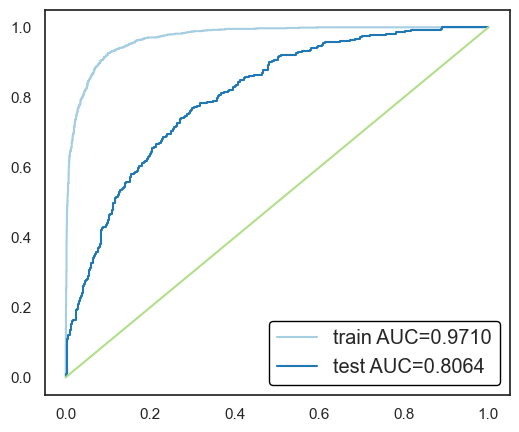

In [40]:
show_roc_curve_of_model(grid_boosted_catty2, X_train, X_test, y_train, y_test)

# Предсказания

In [41]:
best_model = grd_search

In [42]:
X_test = pd.read_csv('D:/Код_НИИАС/DLS/data/test.csv')
X_test = prepare_data(X_test)
X_test = label_onehot_encoding(X_test)

submission = pd.read_csv('D:/Код_НИИАС/DLS/data/submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('D:/Код_НИИАС/DLS/data/my_submission.csv')